In [1]:
import numpy as np
from csv import reader

from matplotlib import pyplot as plt
from sklearn import metrics

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared, DotProduct


In [2]:
# Load a CSV file
def load_csv(filename):
  file = open(filename, 'r')
  lines = reader(file)
  dataset = list(lines)
  return dataset

In [3]:
filename =  'train_data_big.csv'
dataset = load_csv(filename)

In [4]:
print('Loaded data file {0} with {1} rows and {2} columns').format(filename, len(dataset),
len(dataset[0]))

Loaded data file train_data_big.csv with 3351168 rows and 12 columns


In [5]:
filename1 =  'labels_data_big.csv'
dataset1 = load_csv(filename1)
print('Loaded data file {0} with {1} rows and {2} columns').format(filename1, len(dataset1),
len(dataset1[0]))

Loaded data file labels_data_big.csv with 3351168 rows and 1 columns


In [6]:
X1= np.asarray(dataset)[:,:]
X2=np.asarray(dataset1)[:,:]
X1array=np.concatenate((X1, X2), axis=1)
print X1array.shape #X1 array es la matriu de totes les comptes té 13 columnes.

(3351168, 13)


In [7]:
zero_accounts=np.sum(np.where((np.abs(X1array[:,:-1].astype(float))<=1e-05),1,0),axis=1)
zero_accounts[0:30]

array([ 3,  0,  0, 11,  8,  6, 11, 10,  0,  9,  6, 11, 11, 11, 11,  9, 11,
        6, 11,  7, 10, 11, 10,  5, 11,  6, 11, 12, 10, 10])

In [8]:
from collections import Counter
print Counter(zero_accounts)
zerosdecom=Counter(zero_accounts)
zerosdecom1=[zerosdecom[i] for i in np.arange(13)]

Counter({11: 992108, 10: 500957, 0: 359508, 9: 287009, 8: 225553, 7: 183299, 6: 146958, 4: 124984, 5: 118625, 12: 107245, 1: 105842, 3: 102927, 2: 96153})


7.59795808506


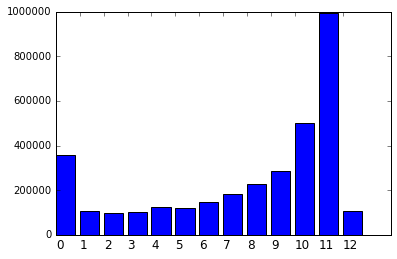

<function matplotlib.pyplot.show>

In [9]:
#Plotting the distribution of zeros
print zero_accounts.mean()
plt.bar(np.arange(13),zerosdecom1)
plt.xticks(np.arange(13),horizontalalignment='left',fontsize=12)

plt.figure(figsize=(10,10))
plt.show()
plt.figure()
plt.show

In [10]:
#Cleaning data, we drop accounts with 12 0's
wrk_accounts = zero_accounts<12
accountclean=X1array.astype(float)[wrk_accounts==True]
accountclean.shape

(3243923, 13)

In [11]:
print accountclean[44]
accountclean[0][12]

[   0.    0.    0.    0.    0.    0.    0. -300.    0.    0.    0.    0.
    0.]


-4200.0

## Dynamic Time Warping 

We want to begin the process of clusteritzation, buf before we have to provide a definition of similarity bewtween each account. Dynamic time warping finds the optimal non-linear alignment between two time series. The Euclidean distances between alignments are then much less susceptable to pessimistic similarity measurements due to distortion in the time axis. There is a price to pay for this, however, because dynamic time warping is quadratic in the length of the time series used. Note that small values for the distance between two time series implies more similarity.

In [17]:
import random
N=15000
numaccountsclust=np.asarray(list(map(lambda _: random.choice(accountclean), range(N))))
print numaccountsclust.shape

(15000, 13)


In [18]:
print len(numaccountsclust)

15000


In [12]:
def DTWDistance(s1, s2):
    DTW={}
    
    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

In [13]:
def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):
        
        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        
        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2
    
    return np.sqrt(LB_sum)

Let's build a matrix containing the similarities between 2.000 bank accounts.

In [21]:
#Treiem el valor al mes 13
data1=numaccountsclust[:,:-1]
print data1.shape

(15000, 12)


In [17]:
print len(data1)


15000


In [18]:
num_clust=40
centroids=random.sample(data1,num_clust)
print 'Centroides inicials :\n'
print '\n'.join(str(p) for p in centroids)
counter=0
num_iter=1
for n in range(num_iter):
    counter+=1
    #print counter
    assignments={}
    #assign data points to clusters
    for ind,i in enumerate(data1):
        min_dist=float('inf')
        closest_clust=None
        for c_ind,j in enumerate(centroids):
            if LB_Keogh(i,j,5)<min_dist:
                cur_dist=DTWDistance(i,j)
                if cur_dist<min_dist:
                    min_dist=cur_dist
                    closest_clust=c_ind
        if closest_clust in assignments:
            assignments[closest_clust].append(ind)
        else:
            assignments[closest_clust]=[]
print "\nThe assignments are the following \n"
for i in np.arange(num_clust):
    print "Cluster ",i,len(assignments[i])
#print assignments[0],'\n\n',assignments[1],'\n\n',assignments[2],'\n\n',assignments[3],'\n\n'


print "Busquem el millor centroide de cada cluster\n"
centroidscent=np.zeros((num_clust))
distot=np.zeros((num_clust))
for l in np.arange(num_clust):
    minimdistcentr=float('inf')
    closestcentr=0
    print "Cluster;",l
    for k in np.arange(len(assignments[l])):
        distcent=0
        for q in np.arange(len(assignments[l])):
            distcent+=DTWDistance(data1[assignments[l][k]],data1[assignments[l][q]])
        if distcent<minimdistcentr:
            minimdistcentr=distcent
            #print minimdistcentr
            closestcentr=assignments[l][k]
            #print closestcentr
    print minimdistcentr
    print closestcentr
    centroidscent[l]=closestcentr
    distot[l]=minimdistcentr
print "Els centroides finals son les comptes:",centroidscent
print "Les respectives distances són:",distot

    

Centroides inicials :

[ -60.    0.    0.  -59. -127.    0.    0.    0.    0. -694. -239.    0.]
[   0.    0.    0.  -47.    0.    0.    0.    0.    0.  -44. -174.    0.]
[  0.   0.   0.   0.   0.   0.   0.   0.   0. -85.   0.   0.]
[   0.    0. -121.    0.    0.    0. -126.    0.    0. -127. -130. -133.]
[   0. -246.    0. -123. -246.    0.    0.    0.    0.    0.    0.    0.]
[ 2409.  1833.   927.  3150.  1795.  1534.  1950.  1988.  2123.  3017.
  2721.  1879.]
[ 0.  0.  0.  0.  0. -2. -3. -3. -3.  0. -3. -3.]
[  0.   0.   0.   0.   0. -25.   0.   0. -25.   0.   0.   0.]
[  0.   0.   0.   0.   0. -30.   0.   0.   0.   0.   0. -30.]
[  0.   0. -18.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
[   0.    0. -113.    0.    0.    0.    0.    0.    0. -170.    0.    0.]
[   0.  -30. -170.    0. -285.    0.    0.  -30.    0.    0.  -30.    0.]
[   0.    0.    0.    0. -176.    0.    0.    0.    0.    0.    0.    0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.]
[    0.     0.     0.  3

[   0. -110.    0.    0.    0.    0.    0.    0.    0.    0. -790.    0.]
[   0.    0.    0.  -47.    0.    0.    0.    0.    0.  -44. -174.    0.]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0. -85.   0.]
[   0. -160.    0.    0.    0.    0.    0.    0.    0. -160.    0. -160.]
[ -74.    0. -259.    0.  -77.    0.    0. -180.    0.    0.  -74.    0.]
[ 1631.  1631.  3262.  1631.  1635.  1631.  1631.  1631.  1631.  3262.
  1631.  1631.]
[ 0. -4. -2. -5. -5. -2. -3. -5.  0. -2. -4.  0.]
[  0.   0. -30.   0. -30.   0.   0.   0.   0.   0.   0.   0.]
[  0.   0.   0.   0.   0. -30.   0.   0.   0.   0.   0. -30.]
[  0. -20.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
[   0.    0.    0.    0. -136.    0.    0.    0.    0.    0. -148.    0.]
[   0.  -88.    0.    0.    0.    0.    0.    0.    0. -333.  -19.  -46.]
[   0.    0.    0. -175.    0.    0.    0.    0.    0.    0.    0.    0.]
[-3. -1.  0.  0. -2.  0.  3.  0.  0.  0.  0.  0.]
[    0.     0.     0.     0.  3513.     0.     

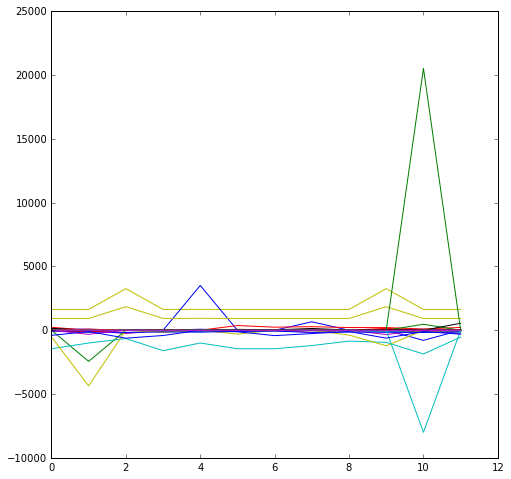

In [19]:
finalcentroids={}
plt.figure(figsize=(8,8))
for i in np.arange(num_clust):
    print data1[centroidscent[i].astype(int)]
    finalcentroids[i]=data1[centroidscent[i].astype(int)]
    plt.plot(data1[centroidscent[i].astype(int)])

plt.show()

In [14]:
clustersarraydef4=np.zeros((40,12))
clustersarraydef4[0]=np.array([   0., -110.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0., -790.,    0.])
clustersarraydef4[1]=np.array([   0.,    0.,    0.,  -47.,    0.,    0.,    0.,    0.,    0.,  -44., -174.,    0.])
clustersarraydef4[2]=np.array([  0.,   0.,   0.,  0.,   0.,   0.,   0.,   0.,   0.,   0., -85.,   0.])
clustersarraydef4[3]=np.array([   0., -160.,    0.,    0.,    0.,    0.,    0.,    0.,    0., -160.,    0., -160.])
clustersarraydef4[4]=np.array([ -74.,    0., -259.,    0.,  -77.,    0.,    0., -180.,    0.,    0.,  -74.,    0.])
clustersarraydef4[5]=np.array([ 1631.,  1631.,  3262.,  1631.,  1635.,  1631.,  1631.,  1631.,  1631.,  3262.,
  1631.,  1631.])
clustersarraydef4[6]=np.array([ 0., -4., -2., -5., -5., -2., -3., -5.,  0., -2., -4.,  0.])
clustersarraydef4[7]=np.array([  0.,   0., -30.,   0., -30.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])
clustersarraydef4[8]=np.array([  3820.,   3599.,   4421.,  14948.,   4731.,   3820.,   4677.,
         7488.,      0.,   3744.,   7716.,   3744.])
clustersarraydef4[9]=np.array([  0., -20.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])
clustersarraydef4[10]=np.array([   0.,    0.,    0.,    0., -136.,    0.,    0.,    0.,    0.,    0., -148.,    0.])
clustersarraydef4[11]=np.array([   0.,  -88.,    0.,    0.,    0.,    0.,    0.,    0.,    0., -333.,  -19.,  -46.])
clustersarraydef4[12]=np.array([   0.,    0.,    0., -175.,    0.,    0.,    0.,    0.,    0.,    0.,   0.,    0.])
clustersarraydef4[13]=np.array([-3., -1.,  0.,  0., -2.,  0.,  3.,  0.,  0.,  0.,  0.,  0.])
clustersarraydef4[14]=np.array([    0.,     0.,     0.,     0.,  3513.,     0.,     0.,     0.,     0.,     0.,
     0.,     0.])
clustersarraydef4[15]=np.array([    0., -2438.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
     0.,    0.])
clustersarraydef4[16]=np.array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  150.,    0.,   50.])
clustersarraydef4[17]=np.array([-1450., -1000.,  -650., -1600., -1000., -1450., -1450., -1200.,  -850.,  -950.,
 -1860.,  -540.])
clustersarraydef4[18]=np.array([   0.,  -18.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0., -279.])
clustersarraydef4[19]=np.array([ -5.24000000e+02,  -4.36000000e+03,   0.00000000e+00,  -1.00000000e+02,
   0.00000000e+00,  -3.02000000e+02,   0.00000000e+00,   0.00000000e+00,
  -3.78000000e+02 , -1.21600000e+03,  -1.00000000e+00,   0.00000000e+00])
clustersarraydef4[20]=np.array([  0., -11.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., -10.,   0.])
clustersarraydef4[21]=np.array([ 107.,   79.,    0.,    0.,   80.,    0.,    0.,  665.,    0.,    0.,   78.,    0.])
clustersarraydef4[22]=np.array([  0.,  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., -50.,   0.])
clustersarraydef4[23]=np.array([ 233.,    0.,    0.,    0.,    0.,  370.,  242.,  280.,  213.,  210.,  100.,  222.])
clustersarraydef4[24]=np.array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., -15.])
clustersarraydef4[25]=np.array([-45.,   0.,   0.,   0.,   0.,   0., -11.,   0.,   0., -51., -15.,   0.])
clustersarraydef4[26]=np.array([-62.,   0.,   0.,   0.,   0., -58., -58., -39., -58.,   0., -67., -58.])
clustersarraydef4[27]=np.array([  0., -44.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])
clustersarraydef4[28]=np.array([ -67., -141., -173., -131., -141.,  -99.,  -67., -164., -143., -152., -168., -128.])
clustersarraydef4[29]=np.array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  470.,    0.])
clustersarraydef4[30]=np.array([   0., -100.,    0.,   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.])
clustersarraydef4[31]=np.array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,    0.,     0.,
 -8000.,     0.])
clustersarraydef4[32]=np.array([   0., -319.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.])
clustersarraydef4[33]=np.array([  924.,   924.,  1848.,   924.,   938.,   924.,   924.,   924.,   924.,  1848.,
   924.,   924.])
clustersarraydef4[34]=np.array([ 150.,    0.,    0.,   30.,   20.,   70.,   30.,  140.,   20.,   70.,   0.,  550.])
clustersarraydef4[35]=np.array([-400., -100., -620., -410.,   0., -120., -420., -260., -100., -620., -100., -310.])
clustersarraydef4[36]=np.array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,      0.,      0.,
      0.,  20536.,      0.])
clustersarraydef4[37]=np.array([  0.,  89.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])
clustersarraydef4[38]=np.array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., -52.,   0., -15.])
clustersarraydef4[39]=np.array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., -20.,   0.])

In [15]:
num_clust=40
assignmentsclus={}
assignmentsclus[0]=[]
assignmentsclus[1]=[]
assignmentsclus[2]=[]
assignmentsclus[3]=[]
assignmentsclus[4]=[]
assignmentsclus[5]=[]
assignmentsclus[6]=[]
assignmentsclus[7]=[]
assignmentsclus[8]=[]
assignmentsclus[9]=[]
assignmentsclus[10]=[]
assignmentsclus[11]=[]
assignmentsclus[12]=[]
assignmentsclus[13]=[]
assignmentsclus[14]=[]
assignmentsclus[15]=[]
assignmentsclus[16]=[]
assignmentsclus[17]=[]
assignmentsclus[18]=[]
assignmentsclus[19]=[]
assignmentsclus[20]=[]
assignmentsclus[21]=[]
assignmentsclus[22]=[]
assignmentsclus[23]=[]
assignmentsclus[24]=[]
assignmentsclus[25]=[]
assignmentsclus[26]=[]
assignmentsclus[27]=[]
assignmentsclus[28]=[]
assignmentsclus[29]=[]
assignmentsclus[30]=[]
assignmentsclus[31]=[]
assignmentsclus[32]=[]
assignmentsclus[33]=[]
assignmentsclus[34]=[]
assignmentsclus[35]=[]
assignmentsclus[36]=[]
assignmentsclus[37]=[]
assignmentsclus[38]=[]
assignmentsclus[39]=[]
for i in np.arange(100000):
    minimdistcentrclus=float('inf')
    clusternum=None
    for j in np.arange(num_clust):
        distanceclust=DTWDistance(accountclean[i][:-1],clustersarraydef4[j][:])
        if distanceclust<minimdistcentrclus:
            minimdistcentrclus=distanceclust
            clusternum=j
    if clusternum in assignmentsclus:
        assignmentsclus[clusternum].append(i)
    #else:
        #assignmentsclus[clusternum]=[]

#print assignmentsclus

In [16]:
print len(assignmentsclus[0])
print len(assignmentsclus[1])
print len(assignmentsclus[2])
print len(assignmentsclus[3])
print len(assignmentsclus[4])
print len(assignmentsclus[5])
print len(assignmentsclus[6])
print len(assignmentsclus[7])
print len(assignmentsclus[8])
print len(assignmentsclus[9])
print len(assignmentsclus[10])
print len(assignmentsclus[11])
print len(assignmentsclus[12])
print len(assignmentsclus[13])
print len(assignmentsclus[14])
print len(assignmentsclus[15])
print len(assignmentsclus[16])
print len(assignmentsclus[17])
print len(assignmentsclus[18])
print len(assignmentsclus[19])
print len(assignmentsclus[20])
print len(assignmentsclus[21])
print len(assignmentsclus[22])
print len(assignmentsclus[23])
print len(assignmentsclus[24])
print len(assignmentsclus[25])
print len(assignmentsclus[26])
print len(assignmentsclus[27])
print len(assignmentsclus[28])
print len(assignmentsclus[29])
print len(assignmentsclus[30])
print len(assignmentsclus[31])
print len(assignmentsclus[32])
print len(assignmentsclus[33])
print len(assignmentsclus[34])
print len(assignmentsclus[35])
print len(assignmentsclus[36])
print len(assignmentsclus[37])
print len(assignmentsclus[38])
print len(assignmentsclus[39])

3531
1175
2612
1320
3243
1373
1582
3949
124
6367
2352
1924
3823
7874
1476
1234
2326
1611
1468
554
2447
3072
3042
1418
1922
5576
4902
2680
2608
1503
3337
1443
3770
1838
968
4437
860
2083
2065
111


In [17]:
len(assignmentsclus[0])+len(assignmentsclus[1])+len(assignmentsclus[2])+len(assignmentsclus[3])+len(assignmentsclus[4])+len(assignmentsclus[5])+len(assignmentsclus[6])+len(assignmentsclus[7])+len(assignmentsclus[8])+len(assignmentsclus[9])+len(assignmentsclus[10])+len(assignmentsclus[11])+len(assignmentsclus[12])+len(assignmentsclus[13])+len(assignmentsclus[14])+len(assignmentsclus[15])+len(assignmentsclus[16])+len(assignmentsclus[17])+len(assignmentsclus[18])+len(assignmentsclus[19])+len(assignmentsclus[20])+len(assignmentsclus[21])+len(assignmentsclus[22])+len(assignmentsclus[23])+len(assignmentsclus[24])+len(assignmentsclus[25])+len(assignmentsclus[26])+len(assignmentsclus[27])+len(assignmentsclus[28])+len(assignmentsclus[29])+len(assignmentsclus[30])+len(assignmentsclus[31])+len(assignmentsclus[32])+len(assignmentsclus[33])+len(assignmentsclus[34])+len(assignmentsclus[35])+len(assignmentsclus[36])+len(assignmentsclus[37])+len(assignmentsclus[38])+len(assignmentsclus[39])

100000

In [18]:
#np.arange(accountclean.shape[0])
from sklearn import cross_validation
from sklearn import neighbors
from sklearn import metrics

def regressionaccounts(n_folds,accountsreg,quant,gp,clusternum):

    #quant=accountcluster1.shape[0]
    a=np.arange(12)+1 #vector del 1 al 12
    a=a.reshape(-1,1)
    xs=np.arange(13,14,1).reshape(-1,1) #vector que conte el 13
    compt=0
    compt1=0
    compt2=0
    compt3=0
    compt4=0
    errort=0
    denom=0
    j=0
    lambd=10
    ypredopt={}
    errorrmse=0
    errormae=0
    #n_folds=3
    for i in np.arange(quant):
        kf=cross_validation.KFold(n=a.shape[0], n_folds=n_folds, shuffle=False, random_state=0)
        #yhat = accountclean[i].copy()
        error=0
        #print "Iteracio:",i
        gp = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
        j=0
        lml=np.zeros((n_folds,1))
        ypredopt=np.zeros((n_folds,1))
        sigma=np.zeros((n_folds,1))
        for train_index, test_index in kf:
            X_train, X_test = a[train_index], a[test_index]
            y_train, y_test = accountsreg[i][train_index], accountsreg[i][test_index]
            if j!=0:
                kernel_gpml=gp.kernel_
           #    print kernel_gpml
                gp = GaussianProcessRegressor(kernel=kernel_gpml, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
            gp.fit(X_train, y_train)
            #yhat[test_index]= gp.predict(X_test)
            #print("GPML kernel: %s" % gp.kernel_)
            lml[j]=gp.log_marginal_likelihood(gp.kernel_.theta)
            ypredopt[j],sigma[j]=gp.predict(xs, return_std=True)
            j+=1
        #lml1=lml.reshape(1,-1)
        likelibest=np.argmax(lml)
        #print likelibest
        y_pred=ypredopt[likelibest]
        #sigmapred=sigma[likelibest]
        sigmapred=sigma.max()
        #print accountcluster1[i][12], y_pred
        #print y_pred-sigmapred,y_pred+sigmapred
        if (accountsreg[i][12]<0 and y_pred<0) or (accountsreg[i][12]>0 and y_pred>0) or (np.abs((accountsreg[i][12]-y_pred))<=1e-1):
            compt+=1
        if (accountsreg[i][12]<=0 and y_pred<0) or (accountsreg[i][12]>=0 and y_pred>0) or (np.abs((accountsreg[i][12]-y_pred))<=1e-1):
            compt1+=1
        if (accountsreg[i][12]<=(y_pred+sigmapred)) and ((accountsreg[i][12]>=(y_pred-sigmapred))) or (np.abs((accountsreg[i][12]-y_pred))<=1e-1):
            compt2+=1
        if (accountsreg[i][12]<=(y_pred+1.9600*sigmapred)) and ((accountsreg[i][12]>=(y_pred-1.9600*sigmapred))) or (np.abs((accountsreg[i][12]-y_pred))<=1e-1):
            compt3+=1
        if (accountsreg[i][12]<0 and y_pred<0) or (accountsreg[i][12]>0 and y_pred>0) or (np.abs((accountsreg[i][12]-y_pred))<=30):
            compt4+=1
        if (accountsreg[i][12]>(y_pred+1.9600*sigmapred)) or ((accountsreg[i][12]<(y_pred-1.9600*sigmapred))):
            print "Iteracio:",i
            print accountsreg[i][12], y_pred
            print y_pred-sigmapred,y_pred+sigmapred
            print y_pred-1.9600*sigmapred,y_pred+1.9600*sigmapred
            print DTWDistance(accountsreg[i][0:12],clustersarraydef4[clusternum][:])
        error=np.abs(y_pred-accountsreg[i][12])
        denom=np.sum(np.abs(np.asarray([t - s for s, t in zip(accountsreg[i], accountsreg[i][1:12])][:]))) #naive
        errorrmse+=error**2
        errormae+=error
        errort+=error/float((denom/float(11))+lambd)
        #print '\n'
    mae=errormae/float(quant)
    mase=errort/float(quant)
    rmse=np.sqrt(errorrmse/float(quant)) 
    print 'La predicció de compte en negatiu en predicció i real correctes és de:',compt/float(quant)
    print 'La predicció de compte en negatiu en predicció i real o 0 correctes és de:',compt1/float(quant)
    print 'La predicció de compte esta compresa en la zona determinada:',compt2/float(quant)
    print 'La predicció de compte ens permet assegurar el signe final:',compt3/float(quant)
    print 'Comptes signe',compt4/float(quant)
    print 'The Mean Absolute Scaled error is',mase 
    print 'The MAE error is',mae
    print 'The RMSE is',rmse
    return mase

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


(3531, 13)


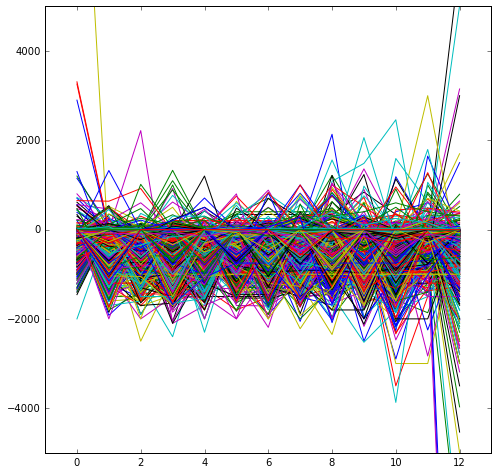

Iteracio: 9
-1450.0 [-270.]
[-746.59614593] [ 206.59614593]
[-1204.12844602] [ 664.12844602]
832.646383527
Iteracio: 32
3150.0 [-74.875]
[-408.02769367] [ 258.27769367]
[-727.8542796] [ 578.1042796]
501.219512789
Iteracio: 48
-825.0 [-83.37499932]
[-409.26088117] [ 242.51088252]
[-722.11132774] [ 555.36132909]
429.357659766
Iteracio: 69
-710.0 [-92.625]
[-405.34801908] [ 220.09801908]
[-705.56211739] [ 520.31211739]
698.254251688
Iteracio: 121
-1160.0 [-145.]
[-625.91062677] [ 335.91062677]
[-1087.58482846] [ 797.58482846]
1258.09379619
Iteracio: 148
-940.0 [-40.00000093]
[-348.85981999] [ 268.85981814]
[-645.3652463] [ 565.36524444]
607.20671933
Iteracio: 167
-1660.0 [-202.5]
[-617.8444639] [ 212.8444639]
[-1016.57514924] [ 611.57514924]
943.239100123
Iteracio: 185
-2500.0 [-62.5]
[-410.48520572] [ 285.48520572]
[-744.55100321] [ 619.55100321]
553.35341329
Iteracio: 212
-1200.0 [-137.5]
[-581.90970711] [ 306.90970711]
[-1008.54302593] [ 733.54302593]
939.255023942
Iteracio: 235
-2000.

Iteracio: 1917
-750.0 [-2.5]
[-258.36853995] [ 253.36853995]
[-504.0023383] [ 499.0023383]
381.051177665
Iteracio: 1941
-450.0 [-37.5]
[-237.50018624] [ 162.50018624]
[-429.50036504] [ 354.50036504]
313.36879232
Iteracio: 2016
-620.0 [ 0.]
[-233.15734084] [ 233.15734084]
[-456.98838804] [ 456.98838804]
139.014387745
Iteracio: 2032
-2785.0 [ 0.]
[-381.8975618] [ 381.8975618]
[-748.51922112] [ 748.51922112]
510.395924749
Iteracio: 2045
-900.0 [ 0.]
[-396.86302348] [ 396.86302348]
[-777.85152602] [ 777.85152602]
424.499705536
Iteracio: 2092
-590.0 [ 0.]
[-240.7640182] [ 240.7640182]
[-471.89747568] [ 471.89747568]
126.269552941
Iteracio: 2115
-794.0 [ 0.]
[-395.87053994] [ 395.87053994]
[-775.90625829] [ 775.90625829]
421.602893728
Iteracio: 2170
-1488.0 [-573.625]
[-962.10669342] [-185.14330659]
[-1335.04911909] [ 187.79911909]
1022.79470081
Iteracio: 2200
-1250.0 [-444.00173659]
[-799.81431149] [-88.18916169]
[-1141.39438339] [ 253.39091022]
529.811287158
Iteracio: 2232
-800.0 [-37.5]
[

array([ 0.53158612])

In [72]:
#Llegim les comptes del 1er cluster
accountcluster1=np.zeros((len(assignmentsclus[0]),13))
for i in np.arange(len(assignmentsclus[0])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster1[i]=accountclean[assignmentsclus[0][i].astype(int)]
print accountcluster1.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster1.shape[0]):
        plt.plot(accountcluster1[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 50.0**2 * RBF(length_scale=20.0)  # long term smooth rising trend
k2 = 3.0**2 * RBF(length_scale=10.0) 
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k3 = 0.5**2* RationalQuadratic(length_scale=1., alpha=0.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=0.2**2)  # noise terms
kernel_gpmlini = k1+k2+k3+k4


gp1 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster1,accountcluster1.shape[0],gp1,0)

(1175, 13)


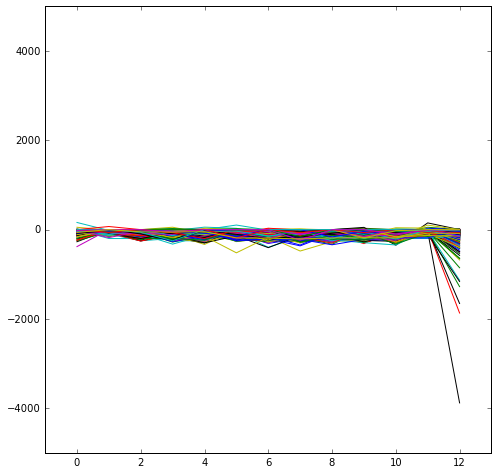

Iteracio: 10
-1135.0 [-24.75]
[-129.71543853] [ 80.21543853]
[-230.48225951] [ 180.98225951]
182.194950534
Iteracio: 19
-115.0 [-8.5]
[-46.99259242] [ 29.99259242]
[-83.94548114] [ 66.94548114]
68.5492523665
Iteracio: 24
-179.0 [-9.375]
[-69.28736518] [ 50.53736518]
[-126.80323575] [ 108.05323575]
102.659631794
Iteracio: 29
-1278.0 [-18.125]
[-65.80277917] [ 29.55277917]
[-111.57344718] [ 75.32344718]
75.3657747257
Iteracio: 41
-497.0 [-11.5]
[-91.73083322] [ 68.73083322]
[-168.7524331] [ 145.7524331]
89.7607932229
Iteracio: 67
-237.0 [-11.25]
[-81.5919193] [ 59.0919193]
[-149.12016184] [ 126.62016184]
69.3469537903
Iteracio: 100
-279.0 [-14.12499958]
[-67.00677259] [ 38.75677343]
[-117.77327468] [ 89.52327552]
93.7283308291
Iteracio: 107
-194.0 [-16.125]
[-67.59813745] [ 35.34813745]
[-117.0123494] [ 84.7623494]
45.9456200306
Iteracio: 123
-522.0 [-6.62499256]
[-92.38692495] [ 79.13693982]
[-174.71838003] [ 161.46839491]
119.511505722
Iteracio: 126
-194.0 [-22.12495998]
[-64.55359166]

Iteracio: 1107
-640.0 [-16.25]
[-67.97036675] [ 35.47036675]
[-117.62191884] [ 85.12191884]
93.600213675
Iteracio: 1120
-324.0 [-37.49999223]
[-95.65805123] [ 20.65806677]
[-151.48978787] [ 76.48980341]
119.991666377
Iteracio: 1126
-117.0 [-18.125]
[-59.38864462] [ 23.13864462]
[-99.00174346] [ 62.75174346]
96.441692229
Iteracio: 1134
0.0 [-178.05883432]
[-240.69574646] [-115.42192217]
[-300.82718213] [-55.29048651]
198.285148208
Iteracio: 1160
-148.0 [-3.]
[-56.29965562] [ 50.29965562]
[-107.46732502] [ 101.46732502]
146.130079039
Iteracio: 1165
-142.0 [-36.25]
[-73.41096847] [ 0.91096847]
[-109.0854982] [ 36.5854982]
129.645670965
Iteracio: 1166
-154.0 [-27.5]
[-85.70652907] [ 30.70652907]
[-141.58479697] [ 86.58479697]
103.252118622
La predicció de compte en negatiu en predicció i real correctes és de: 0.496170212766
La predicció de compte en negatiu en predicció i real o 0 correctes és de: 0.983829787234
La predicció de compte esta compresa en la zona determinada: 0.853617021277
La

array([ 0.79628463])

In [73]:
#Llegim les comptes del 2on cluster
accountcluster2=np.zeros((len(assignmentsclus[1]),13))
for i in np.arange(len(assignmentsclus[1])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster2[i]=accountclean[assignmentsclus[1][i].astype(int)]
print accountcluster2.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster2.shape[0]):
        plt.plot(accountcluster2[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 70.0**2 * RBF(length_scale=25.0)  # long term smooth rising trend
#k2 = 3.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k2 = 5.0*ExpSineSquared(length_scale=2.0, periodicity=3.0)
k3 = 0.5**2* RationalQuadratic(length_scale=1., alpha=0.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=0.2**2)  # noise terms
kernel_gpmlini = k1+k2+k3+k4


gp2 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster2,accountcluster2.shape[0],gp2,1)

(2612, 13)


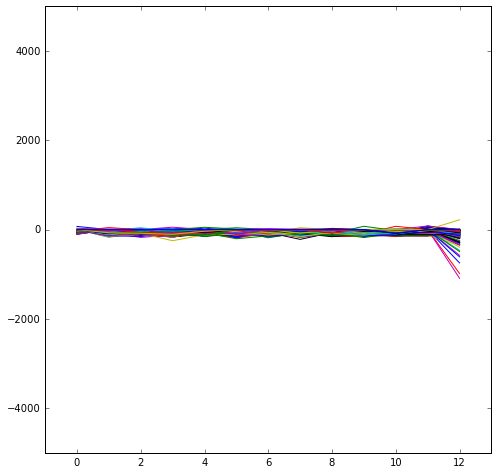

Iteracio: 1
-154.0 [ 0.]
[-26.12687317] [ 26.12687317]
[-51.20867141] [ 51.20867141]
6.0
Iteracio: 2
-108.0 [-3.125]
[-31.58083294] [ 25.33083294]
[-58.89843257] [ 52.64843257]
25.495097568
Iteracio: 21
-82.0 [ 0.]
[-22.48891299] [ 22.48891299]
[-44.07826947] [ 44.07826947]
17.0
Iteracio: 37
-179.0 [-1.87505176]
[-31.40891021] [ 27.6588067]
[-59.76141433] [ 56.01131081]
31.7175030543
Iteracio: 43
-86.0 [ 0.]
[-29.15238773] [ 29.15238773]
[-57.13867995] [ 57.13867995]
16.4924225025
Iteracio: 44
-62.0 [-4.37497364]
[-30.20495099] [ 21.45500371]
[-55.00172925] [ 46.25178197]
36.4005494464
Iteracio: 156
-83.0 [ 0.]
[-25.86503521] [ 25.86503521]
[-50.69546901] [ 50.69546901]
39.5600808897
Iteracio: 188
-56.0 [-2.49999837]
[-25.01666122] [ 20.01666448]
[-46.63265756] [ 41.63266082]
26.2488094968
Iteracio: 198
-63.0 [-2.12500013]
[-26.18742487] [ 21.93742462]
[-49.28735262] [ 45.03735237]
28.1780056072
Iteracio: 206
-145.0 [-4.62500026]
[-35.45115448] [ 26.20115395]
[-65.04426253] [ 55.794262

Iteracio: 1525
-98.0 [-2.74999999]
[-39.90483543] [ 34.40483545]
[-75.57347745] [ 70.07347747]
31.9374388453
Iteracio: 1528
-60.0 [-0.875]
[-24.0253245] [ 22.2753245]
[-46.24963602] [ 44.49963602]
16.5529453572
Iteracio: 1578
-60.0 [ 0.]
[-29.10360122] [ 29.10360122]
[-57.0430584] [ 57.0430584]
3.0
Iteracio: 1579
-340.0 [ 0.875]
[-45.22256792] [ 46.97256792]
[-89.47623313] [ 91.22623313]
71.5821206727
Iteracio: 1590
-74.0 [ 0.]
[-22.81935693] [ 22.81935693]
[-44.72593958] [ 44.72593958]
16.0
Iteracio: 1599
-181.0 [ 0.]
[-22.48899917] [ 22.48899917]
[-44.07843838] [ 44.07843838]
17.0
Iteracio: 1609
-70.0 [ 0.]
[-23.15036185] [ 23.15036185]
[-45.37470923] [ 45.37470923]
15.0
Iteracio: 1613
-82.0 [ 0.]
[-24.47324504] [ 24.47324504]
[-47.96756029] [ 47.96756029]
11.0
Iteracio: 1637
-164.0 [-4.375]
[-34.73096671] [ 25.98096671]
[-63.87269475] [ 55.12269475]
35.3553390593
Iteracio: 1647
-115.0 [-10.53707765]
[-54.93425975] [ 33.86010445]
[-97.55555456] [ 76.48139927]
83.6600262969
Iteracio: 

array([ 0.50947889])

In [74]:
#Llegim les comptes del 3er cluster
accountcluster3=np.zeros((len(assignmentsclus[2]),13))
for i in np.arange(len(assignmentsclus[2])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster3[i]=accountclean[assignmentsclus[2][i].astype(int)]
print accountcluster3.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster3.shape[0]):
        plt.plot(accountcluster3[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 50.0**2 * RBF(length_scale=20.0)  # long term smooth rising trend
#k2 = 3.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k3 = 0.5**2* RationalQuadratic(length_scale=1., alpha=0.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=0.2**2)  # noise terms
kernel_gpmlini = k1+k3+k4


gp3 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster3,accountcluster3.shape[0],gp3,2)

(1320, 13)


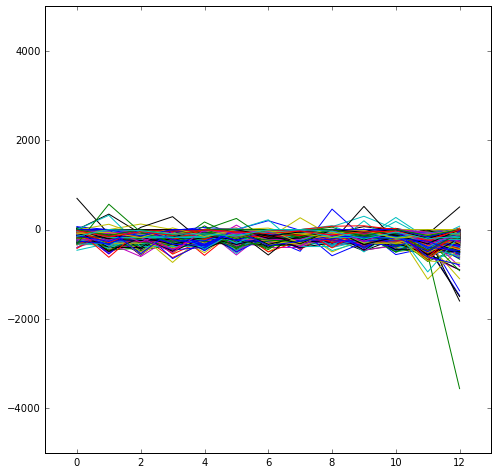

Iteracio: 17
-308.0 [-118.51057399]
[-188.40167271] [-48.61947527]
[-255.49712748] [ 18.4759795]
128.179561553
Iteracio: 32
0.0 [-168.70181634]
[-251.23151444] [-86.17211824]
[-330.46002461] [-6.94360807]
177.732945736
Iteracio: 36
-140.0 [-5.]
[-67.60873554] [ 57.60873554]
[-127.71312165] [ 117.71312165]
145.602197786
Iteracio: 48
-220.0 [-46.24954981]
[-132.40847905] [ 39.90937942]
[-215.12105111] [ 122.62195148]
145.945195193
Iteracio: 49
-1476.0 [-114.75001402]
[-281.01977849] [ 51.51975045]
[-440.63875238] [ 211.13872434]
526.061783444
Iteracio: 50
-663.0 [-46.75007946]
[-151.42354564] [ 57.92338672]
[-251.91007317] [ 158.40991426]
170.51392905
Iteracio: 78
-529.0 [-62.625]
[-197.57679177] [ 72.32679177]
[-327.13051187] [ 201.88051187]
334.208019054
Iteracio: 103
-285.0 [-27.75]
[-98.90818583] [ 43.40818583]
[-167.22004422] [ 111.72004422]
105.318564365
Iteracio: 105
-1371.0 [-132.125]
[-378.99183497] [ 114.74183497]
[-615.98399653] [ 351.73399653]
584.422792163
Iteracio: 112
-311

Iteracio: 974
-343.0 [-57.5000082]
[-149.66960783] [ 34.66959142]
[-238.15242346] [ 123.15240705]
164.158460032
Iteracio: 989
-461.0 [-33.24971129]
[-102.85213412] [ 36.35271153]
[-169.67046003] [ 103.17103745]
166.631329587
Iteracio: 1000
-488.0 [-119.25006257]
[-266.84848735] [ 28.3483622]
[-408.54297513] [ 170.04284999]
400.52840099
Iteracio: 1003
-367.0 [-28.]
[-132.46582986] [ 76.46582986]
[-232.75302653] [ 176.75302653]
197.749841972
Iteracio: 1021
-1600.0 [-56.25]
[-154.85742624] [ 42.35742624]
[-249.52055543] [ 137.02055543]
179.722007556
Iteracio: 1029
-272.0 [-34.25]
[-128.54741015] [ 60.04741015]
[-219.07292389] [ 150.57292389]
114.717043198
Iteracio: 1046
0.0 [-178.73874406]
[-237.31767731] [-120.15981081]
[-293.55345323] [-63.92403489]
126.684647847
Iteracio: 1050
-175.0 [-53.37500045]
[-114.22131622] [ 7.47131532]
[-172.63377936] [ 65.88377846]
156.448074453
Iteracio: 1053
-245.0 [-47.37502694]
[-145.2408374] [ 50.49078352]
[-239.19201544] [ 144.44196156]
180.430041844
It

array([ 0.84089987])

In [76]:
#Llegim les comptes del 4rt cluster
accountcluster4=np.zeros((len(assignmentsclus[3]),13))
for i in np.arange(len(assignmentsclus[3])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster4[i]=accountclean[assignmentsclus[3][i].astype(int)]
print accountcluster4.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster4.shape[0]):
        plt.plot(accountcluster4[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 95.0**2 * RBF(length_scale=35.0)  # long term smooth rising trend
#k2 = 3.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k3 = 5.5**2* RationalQuadratic(length_scale=4.2, alpha=0.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=12.5**2)  # noise terms
kernel_gpmlini = k1+k3+k4


gp4 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster4,accountcluster4.shape[0],gp4,3)

(3243, 13)


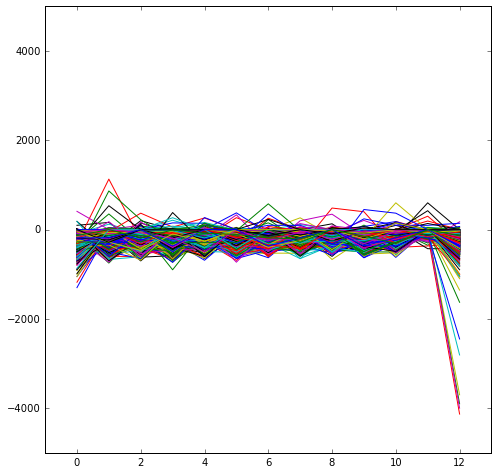

Iteracio: 2
-198.0 [-20.86815944]
[-107.38332423] [ 65.64700535]
[-190.43788243] [ 148.70156354]
254.173169316
Iteracio: 84
-446.0 [-111.13728844]
[-268.73420016] [ 46.45962328]
[-420.02723541] [ 197.75265853]
331.694136216
Iteracio: 92
-380.0 [-105.]
[-203.99482004] [-6.00517996]
[-299.02984728] [ 89.02984728]
241.398011591
Iteracio: 93
-482.0 [-82.375]
[-185.69300107] [ 20.94300107]
[-284.87828209] [ 120.12828209]
229.549558919
Iteracio: 98
-234.0 [-79.50000009]
[-143.27094997] [-15.72905021]
[-204.49106185] [ 45.49106167]
226.881026091
Iteracio: 101
-486.0 [ 19.46012154]
[-142.14896962] [ 181.0692127]
[-297.29369714] [ 336.21394021]
302.978547095
Iteracio: 124
-680.0 [-131.25]
[-246.62309423] [-15.87690577]
[-357.38126469] [ 94.88126469]
321.250680933
Iteracio: 160
-260.0 [-71.25]
[-144.36821269] [ 1.86821269]
[-214.56169688] [ 72.06169688]
165.136307334
Iteracio: 168
-500.0 [-62.5]
[-280.08623105] [ 155.08623105]
[-488.96901286] [ 363.96901286]
544.94219877
Iteracio: 185
-413.0 [-3

Iteracio: 1573
-319.0 [-54.5]
[-160.34511185] [ 51.34511185]
[-261.95641922] [ 152.95641922]
137.709839881
Iteracio: 1592
-550.0 [-147.25]
[-327.75139234] [ 33.25139234]
[-501.03272898] [ 206.53272898]
498.689282018
Iteracio: 1596
-571.0 [-127.5]
[-270.56911294] [ 15.56911294]
[-407.91546136] [ 152.91546136]
336.236523894
Iteracio: 1605
-356.0 [-99.49999999]
[-223.47883028] [ 24.47883029]
[-342.49850735] [ 143.49850736]
266.784557274
Iteracio: 1628
-318.0 [-62.29290344]
[-180.48072246] [ 55.89491559]
[-293.94102872] [ 169.35522185]
175.231275747
Iteracio: 1634
0.0 [-218.25000002]
[-296.55758097] [-139.94241906]
[-371.73285869] [-64.76714134]
347.535609686
Iteracio: 1643
-480.0 [-88.75]
[-208.63931468] [ 31.13931468]
[-323.73305677] [ 146.23305677]
239.695640344
Iteracio: 1671
-440.0 [-31.74999999]
[-121.93972294] [ 58.43972295]
[-208.52185696] [ 145.02185697]
110.113577728
Iteracio: 1692
-554.0 [-85.]
[-250.8025569] [ 80.8025569]
[-409.97301152] [ 239.97301152]
317.274329248
Iteracio: 

Iteracio: 2907
-317.0 [-60.125]
[-169.94045448] [ 49.69045448]
[-275.36329077] [ 155.11329077]
136.75525584
Iteracio: 2909
-4000.0 [-17.49997239]
[-128.60242832] [ 93.60248354]
[-235.26078602] [ 200.26084124]
153.762804345
Iteracio: 2914
-249.0 [-41.5]
[-119.55568132] [ 36.55568132]
[-194.48913539] [ 111.48913539]
172.374592095
Iteracio: 2921
-504.0 [-95.375]
[-182.31894735] [-8.43105265]
[-265.78513681] [ 75.03513681]
192.470777003
Iteracio: 2937
-327.0 [-94.499684]
[-189.99830496] [ 0.99893696]
[-281.67698108] [ 92.67761308]
140.346001012
Iteracio: 2957
-257.0 [-48.49996667]
[-127.95904724] [ 30.95911391]
[-204.23976459] [ 107.23983126]
114.730118103
Iteracio: 2997
-294.0 [-66.25]
[-132.5795249] [ 0.0795249]
[-196.2558688] [ 63.7558688]
160.305957469
Iteracio: 3008
-442.0 [-84.875]
[-235.47754114] [ 65.72754114]
[-380.05598063] [ 210.30598063]
349.306455709
Iteracio: 3045
-398.0 [-149.25]
[-245.59046114] [-52.90953886]
[-338.07730384] [ 39.57730384]
270.392307583
Iteracio: 3072
-266.

array([ 0.65094479])

In [77]:
#Llegim les comptes del 5è cluster
accountcluster5=np.zeros((len(assignmentsclus[4]),13))
for i in np.arange(len(assignmentsclus[4])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster5[i]=accountclean[assignmentsclus[4][i].astype(int)]
print accountcluster5.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster5.shape[0]):
        plt.plot(accountcluster5[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 5450.0**2 * RBF(length_scale=180.0)  # long term smooth rising trend
#k2 = 3.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k2= 100*ExpSineSquared(length_scale=20.0, periodicity=4.0)
k3 = 2.5**2* RationalQuadratic(length_scale=1.0, alpha=1.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=0.2**2)  # noise terms
kernel_gpmlini = k1+k2+k3+k4


gp5 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster5,accountcluster5.shape[0],gp5,4)

(1373, 13)


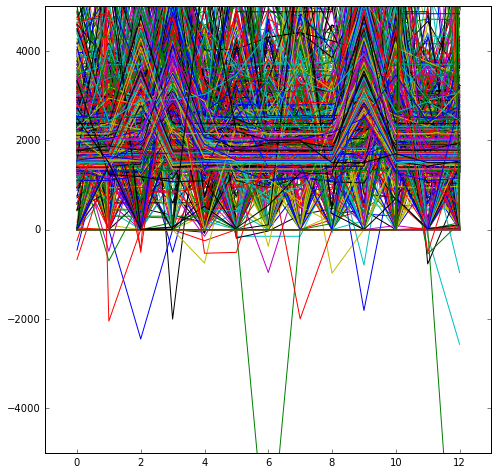

Iteracio: 24
12589.0 [ 1254.625]
[ 547.51821881] [ 1961.73178119]
[-131.30429113] [ 2640.55429113]
16344.9322115
Iteracio: 26
0.0 [ 1895.]
[ 1187.89321881] [ 2602.10678119]
[ 509.07070887] [ 3280.92929113]
1734.42987751
Iteracio: 42
3320.0 [ 1141.58500876]
[ 434.47822758] [ 1848.69178995]
[-244.34428236] [ 2527.51429989]
3145.65891349
Iteracio: 52
0.0 [ 1687.375]
[ 980.26821881] [ 2394.48178119]
[ 301.44570887] [ 3073.30429113]
824.437990391
Iteracio: 53
0.0 [ 1507.625]
[ 800.51821881] [ 2214.73178119]
[ 121.69570887] [ 2893.55429113]
5029.74383045
Iteracio: 59
0.0 [ 2339.5]
[ 1632.39321881] [ 3046.60678119]
[ 953.57070887] [ 3725.42929113]
3260.12668466
Iteracio: 101
4270.0 [ 2106.5]
[ 1399.39321881] [ 2813.60678119]
[ 720.57070887] [ 3492.42929113]
3724.52198275
Iteracio: 119
3001.0 [ 1554.25]
[ 930.71138549] [ 2177.78861451]
[ 332.11431556] [ 2776.38568444]
1135.00088106
Iteracio: 127
1806.0 [ 3296.625]
[ 2589.51821881] [ 4003.73178119]
[ 1910.69570887] [ 4682.55429113]
5255.2222598

Iteracio: 813
4112.0 [ 2419.125]
[ 1712.01821881] [ 3126.23178119]
[ 1033.19570887] [ 3805.05429113]
3262.1365698
Iteracio: 832
0.0 [ 2060.5]
[ 1353.39321881] [ 2767.60678119]
[ 674.57070887] [ 3446.42929113]
2800.23213323
Iteracio: 845
3874.0 [ 1954.625]
[ 1247.51821881] [ 2661.73178119]
[ 568.69570887] [ 3340.55429113]
3967.79094711
Iteracio: 851
3469.0 [ 1928.375]
[ 1491.92157519] [ 2364.82842481]
[ 1072.92628738] [ 2783.82371262]
1343.21442815
Iteracio: 865
3914.0 [ 1625.125]
[ 918.01821881] [ 2332.23178119]
[ 239.19570887] [ 3011.05429113]
7186.78599932
Iteracio: 873
4058.0 [ 2629.5]
[ 1922.39321881] [ 3336.60678119]
[ 1243.57070887] [ 4015.42929113]
2682.3497162
Iteracio: 881
4248.0 [ 2494.25]
[ 1787.14321881] [ 3201.35678119]
[ 1108.32070887] [ 3880.17929113]
6091.53962476
Iteracio: 883
0.0 [ 2475.125]
[ 1768.01821881] [ 3182.23178119]
[ 1089.19570887] [ 3861.05429113]
11056.252801
Iteracio: 901
4388.0 [ 2166.]
[ 1458.89321881] [ 2873.10678119]
[ 780.07070887] [ 3551.92929113]
4

array([ 0.48320683])

In [78]:
#Llegim les comptes del 6è cluster
accountcluster6=np.zeros((len(assignmentsclus[5]),13))
for i in np.arange(len(assignmentsclus[5])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster6[i]=accountclean[assignmentsclus[5][i].astype(int)]
print accountcluster6.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster6.shape[0]):
        plt.plot(accountcluster6[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 1350.0**2 * RBF(length_scale=250.0)  # long term smooth rising trend
#k2 = 3.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k3 = 10.5**2* RationalQuadratic(length_scale=1., alpha=0.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=15.5**2)  # noise terms
kernel_gpmlini = k1+k3+k4


gp6 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster6,accountcluster6.shape[0],gp6,5)

In [40]:
accountcluster6[1361]

array([  3820.,   3599.,   4421.,  14948.,   4731.,   3820.,   4677.,
         7488.,      0.,   3744.,   7716.,   3744.,   7197.])

(1582, 13)


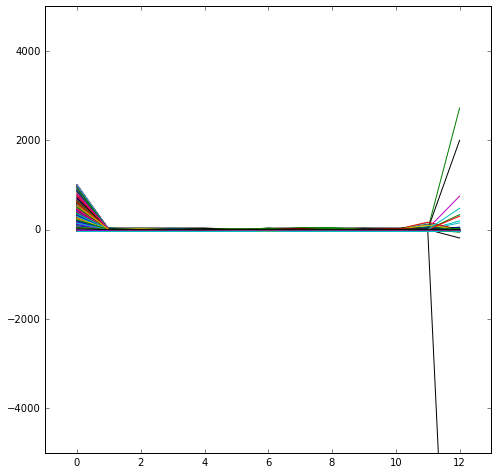

Iteracio: 18
-12.0 [-8.]
[-9.65360635] [-6.34639365]
[-11.24106844] [-4.75893156]
21.1660104885
Iteracio: 19
-12.0 [-3.125]
[-7.51248145] [ 1.26248145]
[-11.72446365] [ 5.47446365]
11.7046999107
Iteracio: 25
-14.0 [-1.75]
[-5.138862] [ 1.638862]
[-8.39216952] [ 4.89216952]
7.87400787401
Iteracio: 43
2723.0 [ 0.]
[-165.3594538] [ 165.3594538]
[-324.10452944] [ 324.10452944]
500.12798362
Iteracio: 46
750.0 [ 2.50000059]
[-47.10788322] [ 52.10788439]
[-94.73145168] [ 99.73145285]
151.749794069
Iteracio: 59
-10.0 [-1.0000002]
[-4.12000941] [ 2.12000902]
[-7.11521825] [ 5.11521786]
10.0498756211
Iteracio: 102
-9.0 [-0.75000036]
[-3.09202927] [ 1.59202855]
[-5.34037702] [ 3.8403763]
6.0827625303
Iteracio: 108
150.0 [ 0.]
[-16.53594635] [ 16.53594635]
[-32.41045484] [ 32.41045484]
51.2640224719
Iteracio: 121
0.0 [-12.]
[-15.9686604] [-8.0313396]
[-19.77857439] [-4.22142561]
37.7359245282
Iteracio: 153
-17.0 [-0.62499977]
[-2.79006848] [ 1.54006894]
[-4.86853444] [ 3.6185349]
5.29150262213
Ite

array([ 0.29490801])

In [80]:
#Llegim les comptes del 7è cluster
accountcluster7=np.zeros((len(assignmentsclus[6]),13))
for i in np.arange(len(assignmentsclus[6])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster7[i]=accountclean[assignmentsclus[6][i].astype(int)]
print accountcluster7.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster7.shape[0]):
        plt.plot(accountcluster7[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 55.0**2 * RBF(length_scale=27.5)  # long term smooth rising trend
k2 = 3.0**2 * RBF(length_scale=10.0)
    + ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k3 = 3.5**2* RationalQuadratic(length_scale=2., alpha=1.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=21.5**2)  # noise terms
kernel_gpmlini = k1+k2+k3+k4


gp7 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster7,accountcluster7.shape[0],gp7,6)

(3949, 13)


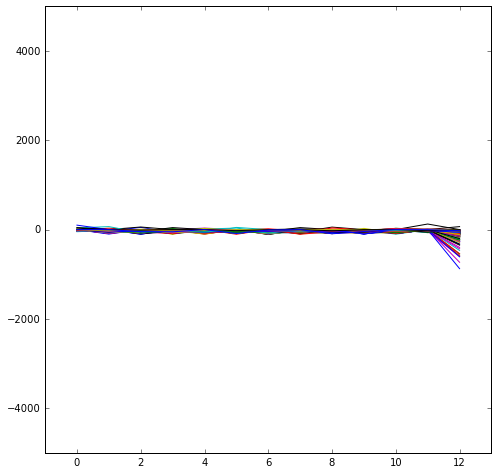

Iteracio: 20
-140.0 [-5.49999995]
[-25.90677721] [ 14.90677732]
[-45.49728339] [ 34.4972835]
24.4131112315
Iteracio: 22
-80.0 [-10.9999996]
[-35.71054117] [ 13.71054197]
[-59.43266108] [ 37.43266188]
53.1883445879
Iteracio: 23
-33.0 [-4.25]
[-16.96597689] [ 8.46597689]
[-29.17331471] [ 20.67331471]
19.6723155729
Iteracio: 38
-96.0 [-5.12499851]
[-27.50161711] [ 17.25162009]
[-48.98317097] [ 38.73317395]
31.9530906173
Iteracio: 80
-50.0 [-2.75]
[-16.2030389] [ 10.7030389]
[-29.11795624] [ 23.61795624]
9.64365076099
Iteracio: 104
-50.0 [-7.8750003]
[-27.37456599] [ 11.62456539]
[-46.09414906] [ 30.34414845]
33.3166624979
Iteracio: 110
-156.0 [ 0.]
[-24.24951767] [ 24.24951767]
[-47.52905463] [ 47.52905463]
36.7695526217
Iteracio: 116
-136.0 [-4.62499967]
[-20.56825906] [ 11.31825972]
[-35.87378808] [ 26.62378873]
22.3159136044
Iteracio: 198
-79.0 [-6.62499921]
[-27.28895109] [ 14.03895266]
[-47.1263449] [ 33.87634647]
32.8329103188
Iteracio: 206
-112.0 [-4.74999983]
[-23.04617675] [ 13.5

Iteracio: 1048
-89.0 [-8.]
[-39.43250294] [ 23.43250294]
[-69.60770576] [ 53.60770576]
60.4648658313
Iteracio: 1081
-34.0 [-4.25]
[-18.97245681] [ 10.47245681]
[-33.10601536] [ 24.60601536]
5.65685424949
Iteracio: 1087
-132.0 [-10.5]
[-34.3298037] [ 13.3298037]
[-57.20641525] [ 36.20641525]
50.3388517946
Iteracio: 1097
-80.0 [-7.3750002]
[-33.47097728] [ 18.72097688]
[-58.52311528] [ 43.77311488]
43.7035467668
Iteracio: 1105
-69.0 [-6.]
[-20.73092651] [ 8.73092651]
[-34.87261595] [ 22.87261595]
23.3666428911
Iteracio: 1117
-39.0 [-5.99999997]
[-18.27803643] [ 6.27803648]
[-30.06495142] [ 18.06495147]
31.3687742827
Iteracio: 1126
-109.0 [-4.375]
[-16.85936603] [ 8.10936603]
[-28.84435742] [ 20.09435742]
18.7082869339
Iteracio: 1127
-51.0 [-10.8749998]
[-30.36701496] [ 8.61701536]
[-49.07934951] [ 27.3293499]
47.9687398208
Iteracio: 1136
-50.0 [-4.62498717]
[-21.98756251] [ 12.73758816]
[-38.65563483] [ 29.40566049]
24.4540385213
Iteracio: 1137
-87.0 [-12.125]
[-38.54008951] [ 14.2900895

Iteracio: 2013
-30.0 [-3.25]
[-16.38809392] [ 9.88809392]
[-29.00066409] [ 22.50066409]
6.40312423743
Iteracio: 2035
-59.0 [ 0.]
[-24.55987701] [ 24.55987701]
[-48.13735893] [ 48.13735893]
39.2173431023
Iteracio: 2036
-51.0 [-10.625]
[-31.07463057] [ 9.82463057]
[-50.70627591] [ 29.45627591]
48.7237108603
Iteracio: 2046
-35.0 [-5.5]
[-17.15109603] [ 6.15109603]
[-28.33614821] [ 17.33614821]
13.3790881603
Iteracio: 2068
-88.0 [-8.125]
[-25.83796319] [ 9.58796319]
[-42.84240786] [ 26.59240785]
35.2136337233
Iteracio: 2076
-42.0 [-2.62500066]
[-17.4742532] [ 12.22425189]
[-31.72953565] [ 26.47953433]
17.4928556845
Iteracio: 2082
-165.0 [-5.375]
[-26.38952711] [ 15.63952711]
[-46.56347314] [ 35.81347314]
24.474476501
Iteracio: 2108
-101.0 [-2.875]
[-13.9873603] [ 8.2373603]
[-24.65522619] [ 18.90522619]
7.28010988928
Iteracio: 2135
-75.0 [-5.6833474]
[-23.17175518] [ 11.80506038]
[-39.96062665] [ 28.59393185]
11.0905365064
Iteracio: 2147
-159.0 [-7.]
[-26.03245747] [ 12.03245747]
[-44.3036

Iteracio: 3028
-87.0 [-11.99999997]
[-31.88051515] [ 7.88051521]
[-50.96580973] [ 26.96580978]
37.1214223865
Iteracio: 3032
-30.0 [-2.5]
[-13.61024211] [ 8.61024211]
[-24.27607453] [ 19.27607453]
10.0
Iteracio: 3034
-78.0 [-5.]
[-22.3205087] [ 12.3205087]
[-38.94819705] [ 28.94819705]
14.1421356237
Iteracio: 3043
-44.0 [-3.375]
[-13.24841721] [ 6.49841721]
[-22.72689773] [ 15.97689773]
24.6981780705
Iteracio: 3046
-53.0 [-7.12500013]
[-27.27095953] [ 13.02095927]
[-46.61108056] [ 32.3610803]
26.5141471671
Iteracio: 3048
-68.0 [-18.125]
[-43.47230731] [ 7.2223073]
[-67.80572232] [ 31.55572232]
69.1881492743
Iteracio: 3063
-58.0 [-4.18447121]
[-17.31602051] [ 8.94707809]
[-29.92230783] [ 21.55336542]
27.9284800875
Iteracio: 3083
-43.0 [-6.]
[-19.72439503] [ 7.72439503]
[-32.89981427] [ 20.89981427]
34.756294394
Iteracio: 3089
-86.0 [-12.41931854]
[-32.55016421] [ 7.71152714]
[-51.87577607] [ 27.037139]
46.2493243194
Iteracio: 3106
-66.0 [-5.5]
[-29.94250661] [ 18.94250661]
[-53.40731295]

array([ 0.55207797])

In [81]:
#Llegim les comptes del 8è cluster
accountcluster8=np.zeros((len(assignmentsclus[7]),13))
for i in np.arange(len(assignmentsclus[7])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster8[i]=accountclean[assignmentsclus[7][i].astype(int)]

print accountcluster8.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster8.shape[0]):
        plt.plot(accountcluster8[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 35.0**2 * RBF(length_scale=12.5)  # long term smooth rising trend
#k2 = 3.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k3 = 7.5**2* RationalQuadratic(length_scale=15.0, alpha=0.5)
k4 = 1.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=15.5**2)  # noise terms
kernel_gpmlini = k1+k3+k4


gp8 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster8,accountcluster8.shape[0],gp8,7)

In [39]:
accountcluster8[0:10]

array([[  0.,   0.,   0., -24.,   0.,   0.,   0.,   0.,   0.,  -4., -24.,
          0.,   0.],
       [  0.,   0.,   0., -29.,   0.,   0.,   0.,   0.,   0., -32.,   0.,
          0.,   0.],
       [  0., -62.,   0., -42.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.],
       [  0.,   0.,   0., -36., -16.,   0.,   0.,   0.,   0., -23.,   0.,
          0.,   0.],
       [  0.,   0.,   0., -69.,   0.,   0., -63.,   0.,   0., -62.,   0.,
          0., -55.],
       [  0.,   0.,   0., -36.,   0., -30.,   0., -40.,   0.,   0.,   0.,
          0.,   0.],
       [  0.,   0.,   0., -37.,   0.,   0.,   0.,   0.,   0., -41.,   0.,
          0.,   0.],
       [  0.,   0.,   0., -37.,   0.,   0.,   0.,   0.,   0., -35.,   0.,
          0.,   0.],
       [  0.,   0.,   0., -20.,   0.,   0.,   0.,   0.,   0., -33.,   0.,
          0.,   0.],
       [  0.,   0.,   0., -66.,   0.,   0.,   0.,   0.,   0., -55.,   0.,
          0.,   0.]])

(124, 13)


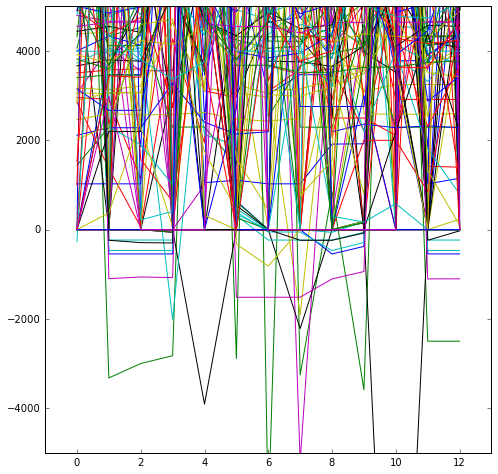

Iteracio: 1
-2500.0 [ 2711.]
[ 2078.54446797] [ 3343.45553203]
[ 1471.38715721] [ 3950.61284279]
33581.8546986
Iteracio: 2
0.0 [ 4875.]
[ 4242.54446797] [ 5507.45553203]
[ 3635.38715721] [ 6114.61284279]
23578.1603184
Iteracio: 3
3962.0 [ 5676.25]
[ 5128.52744249] [ 6223.97255751]
[ 4602.71378727] [ 6749.78621273]
9739.03239547
Iteracio: 4
0.0 [ 3996.375]
[ 3363.91946797] [ 4628.83053203]
[ 2756.76215721] [ 5235.98784279]
22190.415093
Iteracio: 6
0.0 [ 5816.25]
[ 5183.79446797] [ 6448.70553203]
[ 4576.63715721] [ 7055.86284279]
30131.5352413
Iteracio: 8
0.0 [ 6897.875]
[ 6265.41946797] [ 7530.33053203]
[ 5658.26215721] [ 8137.48784279]
39015.6333923
Iteracio: 12
3250.0 [ 7700.125]
[ 7067.66946797] [ 8332.58053203]
[ 6460.51215721] [ 8939.73784279]
25391.713353
Iteracio: 13
0.0 [ 2813.5]
[ 2181.04446797] [ 3445.95553203]
[ 1573.88715721] [ 4053.11284279]
11121.2081628
Iteracio: 14
65000.0 [ 0.]
[-632.45553203] [ 632.45553203]
[-1239.61284279] [ 1239.61284279]
95762.1329545
Iteracio: 16


Iteracio: 122
4152.0 [ 5485.375]
[ 4852.91946797] [ 6117.83053203]
[ 4245.76215721] [ 6724.98784279]
11077.789581
Iteracio: 123
0.0 [ 2349.375]
[ 1716.91946797] [ 2981.83053203]
[ 1109.76215721] [ 3588.98784279]
94719.9020164
La predicció de compte en negatiu en predicció i real correctes és de: 0.661290322581
La predicció de compte en negatiu en predicció i real o 0 correctes és de: 0.943548387097
La predicció de compte esta compresa en la zona determinada: 0.306451612903
La predicció de compte ens permet assegurar el signe final: 0.387096774194
Comptes signe 0.661290322581
The Mean Absolute Scaled error is [ 0.61734393]
The MAE error is [ 5404.74805586]
The RMSE is [ 21347.91488333]


array([ 0.61734393])

In [82]:
#Llegim les comptes del 9è cluster
accountcluster9=np.zeros((len(assignmentsclus[8]),13))
for i in np.arange(len(assignmentsclus[8])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster9[i]=accountclean[assignmentsclus[8][i].astype(int)]

print accountcluster9.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster9.shape[0]):
        plt.plot(accountcluster9[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 5540.0**2 * RBF(length_scale=210.0)  # long term smooth rising trend
k2 = 3.0**2 * RBF(length_scale=10.0) 
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k3 = 10.5**2* RationalQuadratic(length_scale=2.0, alpha=1.5)
k4 = 0.5**2 * RBF(length_scale=1.3) \
    + WhiteKernel(noise_level=20.3**2)  # noise terms
kernel_gpmlini = k1+k2+k3+k4


gp9 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster9,accountcluster9.shape[0],gp9,8)

(6367, 13)


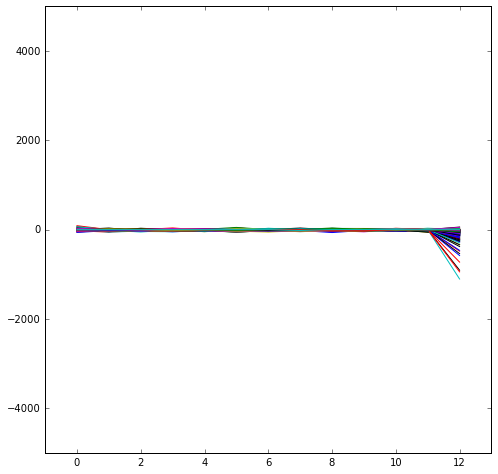

Iteracio: 80
-20.0 [ 0.]
[-9.36860528] [ 9.36860528]
[-18.36246636] [ 18.36246636]
0.0
Iteracio: 85
-57.0 [ 0.]
[-4.96081266] [ 4.96081266]
[-9.72319281] [ 9.72319281]
5.0
Iteracio: 88
-32.0 [-5.375]
[-16.21173437] [ 5.46173437]
[-26.61499936] [ 15.86499936]
32.4499614792
Iteracio: 90
-29.0 [-10.87500007]
[-17.09869323] [-4.65130691]
[-23.07343867] [ 1.32343853]
35.2987251894
Iteracio: 106
-206.0 [ 0.]
[-10.252341] [ 10.252341]
[-20.09458835] [ 20.09458835]
11.0
Iteracio: 110
0.0 [-22.37500006]
[-29.42589402] [-15.3241061]
[-36.19475222] [-8.5552479]
21.610182785
Iteracio: 117
-40.0 [ 0.]
[-6.61441653] [ 6.61441653]
[-12.96425639] [ 12.96425639]
0.0
Iteracio: 142
-483.0 [ 0.]
[-4.29935056] [ 4.29935056]
[-8.4267271] [ 8.4267271]
7.0
Iteracio: 161
-21.0 [ 0.]
[-5.9528903] [ 5.9528903]
[-11.66766498] [ 11.66766498]
2.0
Iteracio: 173
-60.0 [ 0.]
[-9.09326897] [ 9.09326897]
[-17.82280718] [ 17.82280718]
21.5870331449
Iteracio: 178
0.0 [-18.49998721]
[-24.77940382] [-12.22057059]
[-30.80764

Iteracio: 1309
-24.0 [-0.91202874]
[-6.97420743] [ 5.15014995]
[-12.79389898] [ 10.96984149]
8.94427191
Iteracio: 1325
-71.0 [ 0.]
[-4.29934827] [ 4.29934827]
[-8.42672261] [ 8.42672261]
7.0
Iteracio: 1326
-42.0 [ 0.]
[-4.63021144] [ 4.63021144]
[-9.07521443] [ 9.07521443]
6.0
Iteracio: 1329
-264.0 [ 0.]
[-9.26019208] [ 9.26019208]
[-18.14997648] [ 18.14997648]
8.0
Iteracio: 1342
-32.0 [ 0.]
[-7.93725633] [ 7.93725633]
[-15.5570224] [ 15.5570224]
4.0
Iteracio: 1358
-93.0 [-3.125]
[-11.84301594] [ 5.59301594]
[-20.21231124] [ 13.96231124]
19.4164878389
Iteracio: 1382
-71.0 [ 0.]
[-7.93725559] [ 7.93725559]
[-15.55702095] [ 15.55702095]
4.0
Iteracio: 1385
-52.0 [ 0.]
[-4.63006691] [ 4.63006691]
[-9.07493115] [ 9.07493115]
6.0
Iteracio: 1390
-30.0 [ 0.]
[-12.91075377] [ 12.91075377]
[-25.30507738] [ 25.30507738]
15.2970585408
Iteracio: 1400
-17.0 [ 0.]
[-7.96330677] [ 7.96330677]
[-15.60808127] [ 15.60808127]
4.24264068712
Iteracio: 1406
-150.0 [ 0.]
[-6.61438149] [ 6.61438149]
[-12.96418

Iteracio: 2702
0.0 [-22.875]
[-32.55207094] [-13.19792906]
[-41.84205904] [-3.90794096]
20.4205778567
Iteracio: 2713
0.0 [-24.37500589]
[-33.72055109] [-15.02946069]
[-42.69227448] [-6.0577373]
27.748873851
Iteracio: 2729
-538.0 [ 0.]
[-6.94500753] [ 6.94500753]
[-13.61221477] [ 13.61221477]
1.0
Iteracio: 2733
-37.0 [ 0.]
[-8.92941345] [ 8.92941345]
[-17.50165036] [ 17.50165036]
7.0
Iteracio: 2744
-39.0 [ 0.]
[-9.29158456] [ 9.29158456]
[-18.21150574] [ 18.21150574]
12.0415945788
Iteracio: 2755
-59.0 [ 0.]
[-10.58298013] [ 10.58298013]
[-20.74264105] [ 20.74264105]
12.0
Iteracio: 2756
-42.0 [ 0.]
[-4.96078583] [ 4.96078583]
[-9.72314023] [ 9.72314023]
5.0
Iteracio: 2757
-218.0 [-2.875]
[-13.05386915] [ 7.30386915]
[-22.82558354] [ 17.07558354]
5.0
Iteracio: 2797
-30.0 [-2.]
[-13.88420691] [ 9.88420691]
[-25.29304555] [ 21.29304555]
13.0766968306
Iteracio: 2820
-29.0 [ 0.]
[-5.78703435] [ 5.78703435]
[-11.34258733] [ 11.34258733]
12.2065556157
Iteracio: 2828
-75.0 [ 0.]
[-6.28366255] [ 

Iteracio: 4065
-44.0 [ 0.]
[-6.61451986] [ 6.61451986]
[-12.96445892] [ 12.96445892]
0.0
Iteracio: 4067
-57.0 [ 0.]
[-4.96079037] [ 4.96079037]
[-9.72314912] [ 9.72314912]
5.0
Iteracio: 4068
-90.0 [ 0.]
[-8.92944523] [ 8.92944523]
[-17.50171265] [ 17.50171265]
7.0
Iteracio: 4073
-340.0 [ 0.]
[-6.61438129] [ 6.61438129]
[-12.96418733] [ 12.96418733]
0.0
Iteracio: 4080
-148.0 [ 0.]
[-10.58300601] [ 10.58300601]
[-20.74269178] [ 20.74269178]
12.0
Iteracio: 4089
0.0 [-17.625]
[-24.69074278] [-10.55925722]
[-31.47385584] [-3.77614416]
22.3383079037
Iteracio: 4099
-24.0 [-2.50000129]
[-11.84003246] [ 6.84002987]
[-20.80646237] [ 15.80645979]
20.2237484162
Iteracio: 4113
-150.0 [ 0.]
[-5.00000393] [ 5.00000393]
[-9.8000077] [ 9.8000077]
7.07106781187
Iteracio: 4165
-70.0 [ 0.]
[-8.59873767] [ 8.59873767]
[-16.85352584] [ 16.85352584]
6.0
Iteracio: 4166
-190.0 [ 0.]
[-6.94558972] [ 6.94558972]
[-13.61335585] [ 13.61335585]
1.0
Iteracio: 4169
-100.0 [ 0.]
[-6.61445982] [ 6.61445982]
[-12.964341

Iteracio: 5147
0.0 [-28.75]
[-42.75892931] [-14.74107069]
[-56.20750145] [-1.29249855]
37.4699879904
Iteracio: 5150
0.0 [-21.74999906]
[-32.41246399] [-11.08753413]
[-42.64843032] [-0.85156779]
22.5610283454
Iteracio: 5152
-29.0 [-2.5]
[-13.63552861] [ 8.63552861]
[-24.32563607] [ 19.32563607]
21.2132034356
Iteracio: 5162
-68.0 [ 0.]
[-3.96863304] [ 3.96863304]
[-7.77852076] [ 7.77852076]
8.0
Iteracio: 5163
-24.0 [ 0.]
[-3.96876962] [ 3.96876962]
[-7.77878846] [ 7.77878846]
8.0
Iteracio: 5173
-165.0 [-2.1249997]
[-10.91419828] [ 6.66419888]
[-19.35182892] [ 15.10182952]
23.1948270095
Iteracio: 5182
-44.0 [ 0.]
[-7.27582115] [ 7.27582115]
[-14.26060946] [ 14.26060946]
2.0
Iteracio: 5218
-12.0 [ 0.]
[-3.96863736] [ 3.96863736]
[-7.77852923] [ 7.77852923]
8.0
Iteracio: 5249
0.0 [-20.]
[-29.42102313] [-10.57897687]
[-38.46520534] [-1.53479466]
19.5959179423
Iteracio: 5262
0.0 [-18.875]
[-28.14103211] [-9.60896789]
[-37.03642293] [-0.71357707]
18.8679622641
Iteracio: 5263
-40.0 [ 0.]
[-7.60

array([ 0.37581566])

In [83]:
#Llegim les comptes del 10è cluster
accountcluster10=np.zeros((len(assignmentsclus[9]),13))
for i in np.arange(len(assignmentsclus[9])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster10[i]=accountclean[assignmentsclus[9][i].astype(int)]

print accountcluster10.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster10.shape[0]):
        plt.plot(accountcluster10[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 20.0**2 * RBF(length_scale=10.0)  # long term smooth rising trend
#k2 = 3.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k3 = 1.5**2* RationalQuadratic(length_scale=2.0, alpha=0.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=0.2**2)  # noise terms
kernel_gpmlini = k1+k3+k4


gp10 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster10,accountcluster10.shape[0],gp10,9)

(2352, 13)


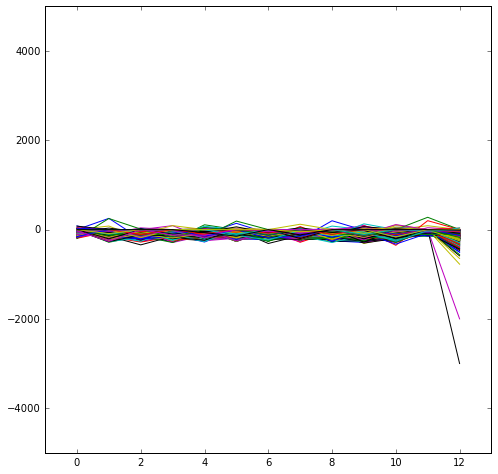

Iteracio: 83
-374.0 [-74.125]
[-178.96038177] [ 30.71038177]
[-279.60234828] [ 131.35234828]
199.175801743
Iteracio: 86
-137.0 [-22.125]
[-70.67895117] [ 26.42895117]
[-117.29074429] [ 73.04074429]
95.3624664111
Iteracio: 91
-350.0 [-43.75]
[-131.2501648] [ 43.7501648]
[-215.25032301] [ 127.75032301]
154.029218007
Iteracio: 140
-143.0 [-17.875]
[-80.66980509] [ 44.91980509]
[-140.95281797] [ 105.20281797]
12.0830459736
Iteracio: 146
-469.0 [-24.125]
[-66.12744828] [ 17.87744828]
[-106.44979863] [ 58.19979863]
115.49025933
Iteracio: 155
-163.0 [-49.125]
[-100.88405493] [ 2.63405493]
[-150.57274767] [ 52.32274767]
127.18097342
Iteracio: 164
-162.0 [-19.87499993]
[-75.35569003] [ 35.60569017]
[-128.61715253] [ 88.86715266]
93.9840411985
Iteracio: 171
-164.0 [-36.49999029]
[-89.26820411] [ 16.26822352]
[-139.92568937] [ 66.92570878]
116.172285852
Iteracio: 172
-159.0 [-15.625]
[-88.03608355] [ 56.78608355]
[-157.55072376] [ 126.30072376]
80.4922356504
Iteracio: 174
-214.0 [-49.99999026]
[-

Iteracio: 1214
-140.0 [-16.1249978]
[-77.27632258] [ 45.02632699]
[-135.98159437] [ 103.73159878]
50.4182506638
Iteracio: 1218
-501.0 [-12.75]
[-81.80510091] [ 56.30510091]
[-148.09799778] [ 122.59799778]
63.7573525172
Iteracio: 1273
-200.0 [-12.5]
[-82.09707008] [ 57.09707008]
[-148.91025736] [ 123.91025736]
63.2455532034
Iteracio: 1305
-157.0 [-21.125]
[-74.8324927] [ 32.5824927]
[-126.39168569] [ 84.14168569]
40.0374824383
Iteracio: 1314
-775.0 [-13.25]
[-73.76536468] [ 47.26536468]
[-131.86011477] [ 105.36011477]
128.980618699
Iteracio: 1329
-204.0 [-40.]
[-121.70067041] [ 41.70067041]
[-200.13331401] [ 120.13331401]
118.321595662
Iteracio: 1351
-94.0 [-11.75]
[-52.4531945] [ 28.9531945]
[-91.52826122] [ 68.02826122]
68.4105255059
Iteracio: 1359
-357.0 [-28.87499586]
[-117.25309538] [ 59.50310366]
[-202.09607091] [ 144.3460792]
158.719879032
Iteracio: 1372
-169.0 [ 19.66197622]
[-62.10245188] [ 101.42640432]
[-140.59630286] [ 179.92025529]
148.734663075
Iteracio: 1393
-151.0 [-21.3

array([ 0.60519901])

In [85]:
#Llegim les comptes del 11è cluster
accountcluster11=np.zeros((len(assignmentsclus[10]),13))
for i in np.arange(len(assignmentsclus[10])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster11[i]=accountclean[assignmentsclus[10][i].astype(int)]

print accountcluster11.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster11.shape[0]):
        plt.plot(accountcluster11[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 90.0**2 * RBF(length_scale=22.0)  # long term smooth rising trend
k2 = 50.0**2 * RBF(length_scale=10.0) \
    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k3 = 1.5**2* RationalQuadratic(length_scale=2.0, alpha=0.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=1.2**2)  # noise terms
kernel_gpmlini = k1+k2+k3+k4


gp11 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=1e-6,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster11,accountcluster11.shape[0],gp11,10)

(1924, 13)


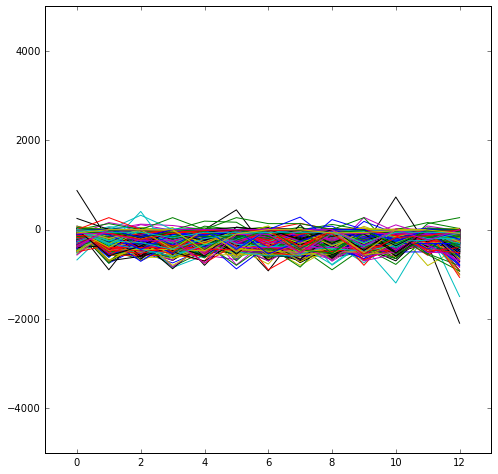

Iteracio: 15
-910.0 [-306.2147246]
[-460.84634291] [-151.58310628]
[-609.29269649] [-3.1367527]
525.426493432
Iteracio: 20
-491.0 [-26.375]
[-110.41135995] [ 57.66135995]
[-191.0862655] [ 138.3362655]
117.175082675
Iteracio: 47
-478.0 [-14.25]
[-152.09127033] [ 123.59127034]
[-284.41888986] [ 255.91888987]
112.062482571
Iteracio: 49
-342.0 [-24.625]
[-139.43462509] [ 90.18462509]
[-249.65186517] [ 200.40186517]
155.967945425
Iteracio: 54
-257.0 [-22.625]
[-116.25652557] [ 71.00652557]
[-206.14279011] [ 160.89279011]
132.939836016
Iteracio: 109
-276.0 [-43.125]
[-154.8785666] [ 68.6285666]
[-262.16199053] [ 175.91199053]
208.60968338
Iteracio: 120
-344.0 [-21.5]
[-143.12236871] [ 100.12236871]
[-259.87984267] [ 216.87984267]
165.332997311
Iteracio: 137
-298.0 [-18.62500003]
[-123.98393328] [ 86.73393321]
[-225.12850919] [ 187.87850913]
140.843885206
Iteracio: 150
-937.0 [-58.5]
[-292.49992987] [ 175.49992987]
[-517.13986254] [ 400.13986254]
291.420658156
Iteracio: 158
-660.0 [-82.5]
[-2

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.44947583e-07,  -4.94109305e-15,  -6.85793136e-09,
         3.47903596e-19,  -4.13175202e-17,  -1.40069224e+00,
         1.80771715e-05,   1.52467691e-06]), 'nit': 32, 'funcalls': 89}
  " state: %s" % convergence_dict)


Iteracio: 1365
-253.0 [-31.37500123]
[-141.76065377] [ 79.01065131]
[-247.73088021] [ 184.98087775]
150.927134737
Iteracio: 1375
-272.0 [-20.5]
[-107.20270864] [ 66.20270864]
[-190.43730893] [ 149.43730893]
107.098085884
Iteracio: 1398
-400.0 [-42.5]
[-203.49301316] [ 118.49301316]
[-358.04630579] [ 273.04630579]
226.656127206
Iteracio: 1405
-540.0 [-78.74999999]
[-302.11501363] [ 144.61501365]
[-516.54542673] [ 359.04542675]
419.689170697
Iteracio: 1408
-500.0 [-33.75]
[-190.01500011] [ 122.51500011]
[-340.02940021] [ 272.52940021]
265.043392674
Iteracio: 1436
-597.0 [-122.5]
[-310.79658066] [ 65.79658066]
[-491.56129809] [ 246.56129809]
403.567838164
Iteracio: 1485
-930.0 [-85.00000049]
[-311.27393414] [ 141.27393316]
[-528.49691045] [ 358.49690947]
570.299044362
Iteracio: 1497
-266.0 [-40.]
[-112.46525706] [ 32.46525706]
[-182.03190384] [ 102.03190384]
131.1106403
Iteracio: 1502
-708.0 [-131.75]
[-405.05884474] [ 141.55884473]
[-667.43533568] [ 403.93533568]
625.705202152
Iteracio: 

array([ 0.62075386])

In [86]:
#Llegim les comptes del 12è cluster
accountcluster12=np.zeros((len(assignmentsclus[11]),13))
for i in np.arange(len(assignmentsclus[11])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster12[i]=accountclean[assignmentsclus[11][i].astype(int)]

print accountcluster12.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster12.shape[0]):
        plt.plot(accountcluster12[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 315.0**2 * RBF(length_scale=65.0)  # long term smooth rising trend
k2 = 25.0**2 * RBF(length_scale=10.0)* ExpSineSquared(length_scale=3.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k3 = 2.5**2* RationalQuadratic(length_scale=2.0, alpha=0.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=0.2**2)  # noise terms
kernel_gpmlini = k1+k2+k3+k4


gp12 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=1e-7,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster12,accountcluster12.shape[0],gp12,11)

(3823, 13)


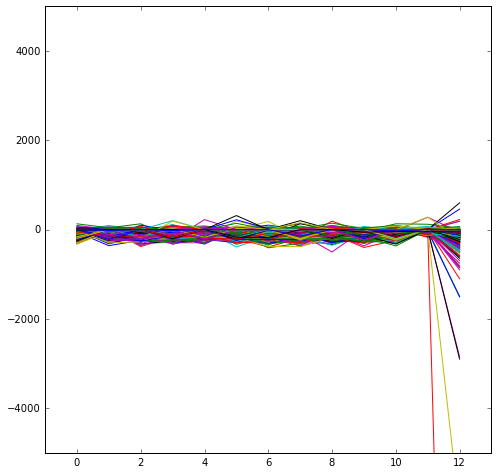

Iteracio: 20
-160.0 [ 0.]
[-56.55741139] [ 56.55741139]
[-110.85252632] [ 110.85252632]
4.0
Iteracio: 35
-185.0 [-38.25]
[-109.94891699] [ 33.44891699]
[-178.7798773] [ 102.2798773]
145.760076839
Iteracio: 39
-439.0 [ 0.]
[-62.83694384] [ 62.83694384]
[-123.16040993] [ 123.16040993]
15.0
Iteracio: 58
-281.0 [ 0.]
[-47.29349875] [ 47.29349875]
[-92.69525755] [ 92.69525755]
32.0
Iteracio: 66
190.0 [ 0.]
[-66.14378293] [ 66.14378293]
[-129.64181454] [ 129.64181454]
25.0
Iteracio: 72
-95.0 [ 0.]
[-46.30332741] [ 46.30332741]
[-90.75452173] [ 90.75452173]
35.0
Iteracio: 105
459.0 [ 12.49999969]
[-52.06731018] [ 77.06730956]
[-114.05192766] [ 139.05192704]
102.18121158
Iteracio: 122
-504.0 [-9.87499999]
[-69.98352705] [ 50.23352707]
[-127.68771302] [ 107.93771305]
37.0675059857
Iteracio: 125
-815.0 [ 0.]
[-49.27862168] [ 49.27862168]
[-96.58609849] [ 96.58609849]
26.0
Iteracio: 152
-168.0 [-6.37500004]
[-79.79459916] [ 67.04459909]
[-150.27741432] [ 137.52741425]
69.3541635376
Iteracio: 192


Iteracio: 1920
-207.0 [ 0.]
[-68.46154301] [ 68.46154301]
[-134.1846243] [ 134.1846243]
32.0
Iteracio: 1951
-139.0 [ 0.]
[-48.61571091] [ 48.61571091]
[-95.28679338] [ 95.28679338]
28.0
Iteracio: 1971
-138.0 [ 0.]
[-50.93071343] [ 50.93071343]
[-99.82419832] [ 99.82419832]
21.0
Iteracio: 2017
-160.0 [ 0.]
[-64.13268975] [ 64.13268975]
[-125.70007192] [ 125.70007192]
21.9317121995
Iteracio: 2040
-1512.0 [ 0.]
[-47.29349875] [ 47.29349875]
[-92.69525755] [ 92.69525755]
32.0
Iteracio: 2050
-139.0 [ 0.]
[-61.84859422] [ 61.84859422]
[-121.22324467] [ 121.22324467]
12.0
Iteracio: 2078
-302.0 [-55.875]
[-161.94096677] [ 50.19096677]
[-263.76429488] [ 152.01429488]
201.935633309
Iteracio: 2169
-185.0 [ 0.]
[-62.83659446] [ 62.83659446]
[-123.15972515] [ 123.15972515]
15.0
Iteracio: 2261
-278.0 [-26.375]
[-85.83637322] [ 33.08637322]
[-142.91929152] [ 90.16929152]
115.607093208
Iteracio: 2262
-274.0 [ 0.]
[-46.63445551] [ 46.63445551]
[-91.40353281] [ 91.40353281]
34.0
Iteracio: 2275
-520.0 [-

Iteracio: 3577
-345.0 [ 0.]
[-74.41175725] [ 74.41175725]
[-145.84704422] [ 145.84704422]
50.0
Iteracio: 3580
-240.0 [-65.12499717]
[-146.25565611] [ 16.00566178]
[-224.1410887] [ 93.89109436]
170.938585463
Iteracio: 3660
-174.0 [ 0.]
[-60.52156141] [ 60.52156141]
[-118.62226035] [ 118.62226035]
8.0
Iteracio: 3692
-217.0 [-18.875]
[-90.91581817] [ 53.16581817]
[-160.07500362] [ 122.32500362]
43.2666153056
Iteracio: 3704
-247.0 [ 0.]
[-81.68791195] [ 81.68791195]
[-160.10830742] [ 160.10830742]
72.0
Iteracio: 3750
-141.0 [-8.87500004]
[-59.94955806] [ 42.19955797]
[-108.98113375] [ 91.23113367]
49.638694584
Iteracio: 3765
-268.0 [ 0.]
[-64.16102191] [ 64.16102191]
[-125.75560295] [ 125.75560295]
19.0
Iteracio: 3804
-155.0 [-14.625]
[-71.42288774] [ 42.17288774]
[-125.94885997] [ 96.69885997]
88.7299273075
Iteracio: 3807
-220.0 [ 0.]
[-67.79737537] [ 67.79737537]
[-132.88285572] [ 132.88285572]
30.0
Iteracio: 3818
-500.0 [ 0.]
[-66.14787993] [ 66.14787993]
[-129.64984467] [ 129.64984467]

array([ 0.68347837])

In [87]:
#Llegim les comptes del 13è cluster
accountcluster13=np.zeros((len(assignmentsclus[12]),13))
for i in np.arange(len(assignmentsclus[12])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster13[i]=accountclean[assignmentsclus[12][i].astype(int)]

print accountcluster13.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster13.shape[0]):
        plt.plot(accountcluster13[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 85.0**2 * RBF(length_scale=22.5)  # long term smooth rising trend
k2 = 12.0**2 * RBF(length_scale=10.0)* ExpSineSquared(length_scale=5.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k3 = 5.5**2* RationalQuadratic(length_scale=2.0, alpha=0.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=0.2**2)  # noise terms
kernel_gpmlini = k1+k2+k3+k4


gp13 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster13,accountcluster13.shape[0],gp13,12)

(7874, 13)


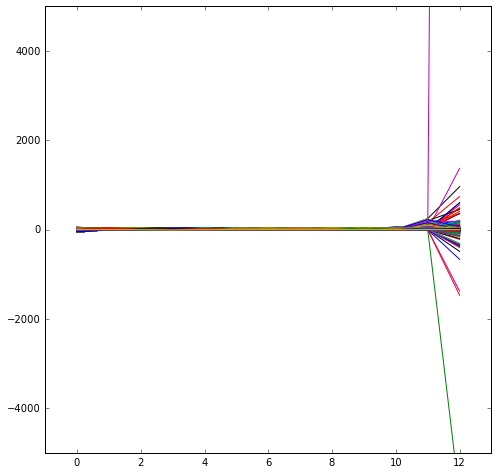

Iteracio: 32
-98.0 [ 0.]
[-1.32288321] [ 1.32288321]
[-2.5928511] [ 2.5928511]
6.2449979984
Iteracio: 80
-72.0 [-0.625]
[-3.27075509] [ 2.02075509]
[-5.81067997] [ 4.56067998]
8.71779788708
Iteracio: 106
-47.0 [ 0.]
[-6.61438158] [ 6.61438158]
[-12.96418791] [ 12.96418791]
17.4068951855
Iteracio: 142
-125.0 [ 0.]
[-15.87450859] [ 15.87450859]
[-31.11403683] [ 31.11403683]
45.1552876195
Iteracio: 145
54.0 [-0.125]
[-12.87279189] [ 12.62279189]
[-25.11067211] [ 24.86067211]
35.2136337233
Iteracio: 177
-12.0 [ 0.]
[-0.33077926] [ 0.33077926]
[-0.64832735] [ 0.64832735]
4.472135955
Iteracio: 200
91187.0 [ 0.375]
[-2.26779666] [ 3.01779666]
[-4.80488144] [ 5.55488144]
7.0
Iteracio: 243
-46.0 [ 0.]
[-2.31504752] [ 2.31504752]
[-4.53749313] [ 4.53749313]
6.63324958071
Iteracio: 273
24.0 [ 1.49999378]
[-6.63555228] [ 9.63553984]
[-14.4456765] [ 17.44566406]
23.8327505756
Iteracio: 289
-33.0 [ 0.]
[-6.28391524] [ 6.28391524]
[-12.31647386] [ 12.31647386]
16.4316767252
Iteracio: 346
26.0 [ 0.]
[

Iteracio: 1990
555.0 [ 2.125]
[-5.71320813] [ 9.96320813]
[-13.23788793] [ 17.48788793]
25.4558441227
Iteracio: 1992
1372.0 [ 0.]
[-13.55947966] [ 13.55947966]
[-26.57658014] [ 26.57658014]
38.1837661841
Iteracio: 2037
-48.0 [-0.62499987]
[-6.60282254] [ 5.35282279]
[-12.34153229] [ 11.09153254]
16.4012194669
Iteracio: 2088
5.0 [ 1.375]
[-0.42344307] [ 3.17344307]
[-2.14994843] [ 4.89994842]
8.66025403784
Iteracio: 2092
160.0 [ 1.87500089]
[-1.66053201] [ 5.41053379]
[-5.0546436] [ 8.80464537]
10.0995049384
Iteracio: 2116
-1470.0 [ 0.]
[-9.92157419] [ 9.92157419]
[-19.44628541] [ 19.44628541]
27.2580263409
Iteracio: 2146
-5.0 [ 0.]
[-0.661452] [ 0.661452]
[-1.29644592] [ 1.29644592]
4.35889894354
Iteracio: 2169
-7.0 [ 0.]
[-2.6457607] [ 2.6457607]
[-5.18569097] [ 5.18569097]
7.4161984871
Iteracio: 2207
-4.0 [-0.5]
[-2.23205663] [ 1.23205664]
[-3.89483101] [ 2.89483101]
3.87298334621
Iteracio: 2220
-12.0 [-0.5]
[-2.7220526] [ 1.7220526]
[-4.8552231] [ 3.8552231]
7.14142842854
Iteracio: 

Iteracio: 3967
-132.0 [-2.37500022]
[-10.32404862] [ 5.57404818]
[-17.95513509] [ 13.20513464]
24.0208242989
Iteracio: 3986
-12.0 [ 0.]
[-2.18536144] [ 2.18536144]
[-4.28330842] [ 4.28330842]
4.89897948557
Iteracio: 4090
-22.0 [ 0.]
[-9.92157113] [ 9.92157113]
[-19.44627942] [ 19.44627942]
27.2580263409
Iteracio: 4102
181.0 [ 3.12499999]
[-10.51390395] [ 16.76390394]
[-23.60725174] [ 29.85725173]
42.9418211072
Iteracio: 4119
170.0 [ 0.]
[-6.61438005] [ 6.61438005]
[-12.9641849] [ 12.9641849]
17.4068951855
Iteracio: 4144
-32.0 [ 0.]
[-4.29935014] [ 4.29935014]
[-8.42672627] [ 8.42672627]
10.677078252
Iteracio: 4161
10.0 [ 0.]
[-1.6536071] [ 1.6536071]
[-3.24106992] [ 3.24106992]
4.24264068712
Iteracio: 4168
-60.0 [ 0.]
[-0.99216641] [ 0.99216641]
[-1.94464617] [ 1.94464617]
5.65685424949
Iteracio: 4221
-4.0 [ 0.]
[-1.32289126] [ 1.32289126]
[-2.59286687] [ 2.59286687]
4.79583152331
Iteracio: 4226
100.0 [ 2.5]
[-6.16025406] [ 11.16025406]
[-14.47409795] [ 19.47409795]
28.6879765756
Itera

Iteracio: 6035
-30.0 [ 0.]
[-3.30719344] [ 3.30719344]
[-6.48209914] [ 6.48209914]
9.11043357914
Iteracio: 6041
23.0 [ 2.875]
[-7.08429218] [ 12.83429218]
[-16.64521267] [ 22.39521267]
29.3087017795
Iteracio: 6065
-47.0 [ 0.]
[-2.64575818] [ 2.64575818]
[-5.18568603] [ 5.18568603]
7.4161984871
Iteracio: 6073
10.0 [ 0.]
[-1.65360679] [ 1.65360679]
[-3.24106931] [ 3.24106931]
4.24264068712
Iteracio: 6090
600.0 [ 0.]
[-13.22885608] [ 13.22885608]
[-25.92855792] [ 25.92855792]
37.1887079636
Iteracio: 6096
-11.0 [-0.24999999]
[-1.81180597] [ 1.311806]
[-3.31113972] [ 2.81113975]
7.14142842854
Iteracio: 6133
-25.0 [ 0.875]
[-5.68244012] [ 7.43244011]
[-11.97758264] [ 13.72758263]
18.1107702763
Iteracio: 6153
2.0 [ 0.25]
[-0.44599933] [ 0.94599933]
[-1.11415868] [ 1.61415868]
4.12310562562
Iteracio: 6188
-7.0 [-0.24999984]
[-1.64194811] [ 1.14194843]
[-2.97821845] [ 2.47821876]
3.31662479036
Iteracio: 6196
40.0 [ 0.]
[-6.61449318] [ 6.61449318]
[-12.96440664] [ 12.96440664]
17.4068951855
Iter

array([ 1.3220765])

In [88]:
#Llegim les comptes del 14è cluster
accountcluster14=np.zeros((len(assignmentsclus[13]),13))
for i in np.arange(len(assignmentsclus[13])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster14[i]=accountclean[assignmentsclus[13][i].astype(int)]

print accountcluster14.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster14.shape[0]):
        plt.plot(accountcluster14[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 45.0**2 * RBF(length_scale=22.0)  # long term smooth rising trend
#k2 = 3.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k3 = 4.5**2* RationalQuadratic(length_scale=2.0, alpha=1.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=4.2**2)  # noise terms
kernel_gpmlini = k1+k2+k3+k4


gp14 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster14,accountcluster14.shape[0],gp14,13)

(1476, 13)


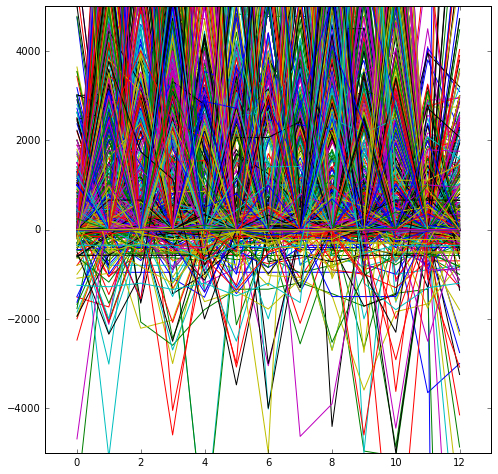

Iteracio: 6
3000.0 [ 203.75]
[-428.70553203] [ 836.20553203]
[-1035.86284279] [ 1443.36284279]
1834.94223342
Iteracio: 39
-11548.0 [-30.00000001]
[-662.45553204] [ 602.45553203]
[-1269.61284279] [ 1209.61284278]
586.73673824
Iteracio: 69
15000.0 [ 0.]
[-632.45553203] [ 632.45553203]
[-1239.61284279] [ 1239.61284279]
8487.0
Iteracio: 78
-4871.0 [-294.5]
[-926.95553203] [ 337.95553203]
[-1534.11284279] [ 945.11284279]
6713.24526589
Iteracio: 106
1173.0 [-67.125]
[-614.84798797] [ 480.59798797]
[-1140.66205643] [ 1006.41205643]
2544.31483901
Iteracio: 118
1441.0 [ 293.24999924]
[-254.47255827] [ 840.97255676]
[-780.28621349] [ 1366.78621197]
2127.71450153
Iteracio: 144
2450.0 [ 0.]
[-547.72255766] [ 547.72255766]
[-1073.53621301] [ 1073.53621301]
3687.0
Iteracio: 168
-73000.0 [ 318.25]
[-314.20553203] [ 950.70553203]
[-921.36284279] [ 1557.86284279]
3235.44417353
Iteracio: 221
1500.0 [ 250.]
[-382.45553203] [ 882.45553203]
[-989.61284279] [ 1489.61284279]
2826.18789184
Iteracio: 222
-6250

Iteracio: 1077
0.0 [ 1750.]
[ 1117.54446797] [ 2382.45553203]
[ 510.38715721] [ 2989.61284279]
6253.59952347
Iteracio: 1080
3000.0 [ 162.5]
[-469.95553203] [ 794.95553203]
[-1077.11284279] [ 1402.11284279]
1765.26740184
Iteracio: 1088
2208.0 [-294.75]
[-927.20553203] [ 337.70553203]
[-1534.36284279] [ 944.86284279]
1176.60571136
Iteracio: 1089
2020.0 [ 215.]
[-332.72255759] [ 762.72255759]
[-858.53621287] [ 1288.53621287]
2692.07522183
Iteracio: 1138
2554.0 [ 320.]
[-312.45553203] [ 952.45553203]
[-919.61284279] [ 1559.61284279]
2300.34693036
Iteracio: 1152
0.0 [ 1241.25]
[ 608.79446797] [ 1873.70553203]
[ 1.63715721] [ 2480.86284279]
5318.2756604
Iteracio: 1160
5600.0 [ 375.]
[-257.45553203] [ 1007.45553203]
[-864.61284279] [ 1614.61284279]
2042.19710116
Iteracio: 1220
2400.0 [ 65.]
[-567.45553203] [ 697.45553203]
[-1174.61284279] [ 1304.61284279]
5450.16128202
Iteracio: 1223
22095.0 [ 0.]
[-632.45553203] [ 632.45553203]
[-1239.61284279] [ 1239.61284279]
513.0
Iteracio: 1232
2020.0 [ 

array([ 0.41009903])

In [89]:
#Llegim les comptes del 15è cluster
accountcluster15=np.zeros((len(assignmentsclus[14]),13))
for i in np.arange(len(assignmentsclus[14])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster15[i]=accountclean[assignmentsclus[14][i].astype(int)]

print accountcluster15.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster15.shape[0]):
        plt.plot(accountcluster15[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 2840.0**2 * RBF(length_scale=410.0)  # long term smooth rising trend
k2 = 39.0**2 * RBF(length_scale=10.0)* ExpSineSquared(length_scale=20.0, periodicity=3.0)  # seasonal component
# medium term irregularity
k3 = 10.5**2* RationalQuadratic(length_scale=2.0, alpha=0.5)
k4 = 0.5**2 * RBF(length_scale=1.3) \
    + WhiteKernel(noise_level=10.2**2)  # noise terms
kernel_gpmlini = k1+k2+k3+k4


gp15 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster15,accountcluster15.shape[0],gp15,14)

(1234, 13)


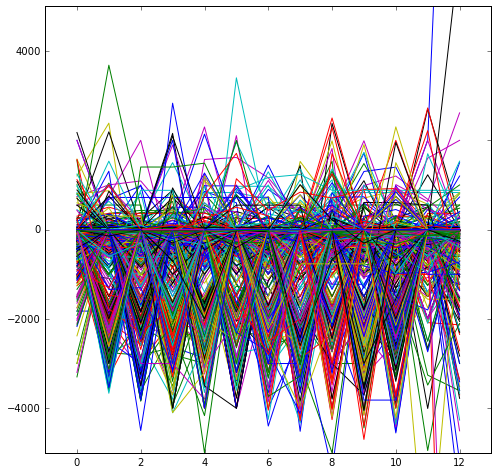

Iteracio: 10
-4266.0 [-995.5]
[-1627.95553203] [-363.04446797]
[-2235.11284279] [ 244.11284279]
1815.12230993
Iteracio: 17
-1921.0 [ 0.]
[-632.45553203] [ 632.45553203]
[-1239.61284279] [ 1239.61284279]
1062.0
Iteracio: 19
-3517.0 [-339.25]
[-971.70553203] [ 293.20553203]
[-1578.86284279] [ 900.36284279]
2892.82370704
Iteracio: 28
18500.0 [ 492.37529021]
[-140.08024183] [ 1124.83082224]
[-747.23755258] [ 1731.98813299]
3395.52985556
Iteracio: 63
-1900.0 [-30.25]
[-577.97255808] [ 517.47255808]
[-1103.78621383] [ 1043.28621383]
275.399709513
Iteracio: 69
-2289.0 [ 284.74941756]
[-347.70611447] [ 917.20494959]
[-954.86342523] [ 1524.36226035]
1300.85164412
Iteracio: 72
-2347.0 [ 156.49999949]
[-475.95553255] [ 788.95553152]
[-1083.1128433] [ 1396.11284227]
2085.95829297
Iteracio: 81
2000.0 [ 0.]
[-632.45553203] [ 632.45553203]
[-1239.61284279] [ 1239.61284279]
1658.86828892
Iteracio: 109
2615.0 [ 514.35215171]
[-118.10338033] [ 1146.80768374]
[-725.26069108] [ 1753.96499449]
3777.5077763

array([ 0.37439561])

In [91]:
#Llegim les comptes del 16è cluster
accountcluster16=np.zeros((len(assignmentsclus[15]),13))
for i in np.arange(len(assignmentsclus[15])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster16[i]=accountclean[assignmentsclus[15][i].astype(int)]

print accountcluster16.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster16.shape[0]):
        plt.plot(accountcluster16[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 2340.0**2 * RBF(length_scale=320.0)  # long term smooth rising trend
k2 = 54.0**2 * RBF(length_scale=10.0)*ExpSineSquared(length_scale=28.0, periodicity=3.0)  # seasonal component
# medium term irregularity
k3 = 10.5**2* RationalQuadratic(length_scale=2.0, alpha=0.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=10.2**2)  # noise terms
kernel_gpmlini = k1+k2+k3+k4


gp16 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster16,accountcluster16.shape[0],gp16,15)

(2326, 13)


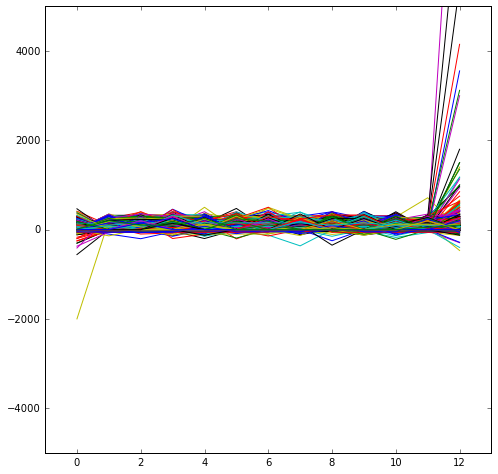

Iteracio: 11
160.0 [ 6.375]
[-59.76878334] [ 72.51878334]
[-123.26681535] [ 136.01681535]
70.7177488329
Iteracio: 36
200.0 [-2.5]
[-37.41239694] [ 32.41239694]
[-70.92829801] [ 65.92829801]
343.087452408
Iteracio: 67
400.0 [ 4.62500136]
[-94.59073065] [ 103.84073337]
[-189.83783339] [ 199.0878361]
150.562279473
Iteracio: 82
210.0 [ 12.5]
[-57.3891015] [ 82.3891015]
[-124.48263894] [ 149.48263894]
100.503731274
Iteracio: 86
505.0 [ 25.27200834]
[-76.21701038] [ 126.76102706]
[-173.64646835] [ 224.19048503]
191.311264697
Iteracio: 102
500.0 [ 25.]
[-71.8247281] [ 121.8247281]
[-164.77646707] [ 214.77646707]
217.944947177
Iteracio: 119
400.0 [ 43.7499999]
[-68.77085426] [ 156.27085406]
[-176.79087425] [ 264.29087406]
233.238075794
Iteracio: 138
350.0 [ 57.54373038]
[-7.18012865] [ 122.26758941]
[-69.31503332] [ 184.40249408]
141.067359797
Iteracio: 162
245.0 [ 35.]
[-66.11882444] [ 136.11882444]
[-163.19289591] [ 233.19289591]
263.818119165
Iteracio: 164
604.0 [ 75.08229384]
[-152.9270664

Iteracio: 1454
350.0 [ 2.5]
[-50.41452553] [ 55.41452553]
[-101.21247003] [ 106.21247003]
54.7722557505
Iteracio: 1456
300.0 [ 14.74999954]
[-115.15358768] [ 144.65358676]
[-239.86103142] [ 269.36103049]
247.838657195
Iteracio: 1494
-400.0 [ 1.]
[-51.25359774] [ 53.25359774]
[-101.41705157] [ 103.41705157]
51.2640224719
Iteracio: 1508
137.0 [ 0.]
[-45.90250852] [ 45.90250852]
[-89.96891669] [ 89.96891669]
58.172158289
Iteracio: 1540
197.0 [ 7.375]
[-79.27335053] [ 94.02335053]
[-162.45576704] [ 177.20576703]
230.705439901
Iteracio: 1550
1172.0 [ 29.25]
[-80.95087469] [ 139.45087469]
[-186.7437144] [ 245.2437144]
221.325552072
Iteracio: 1557
260.0 [ 0.]
[-91.24277168] [ 91.24277168]
[-178.83583249] [ 178.83583249]
122.474487139
Iteracio: 1577
500.0 [ 56.25]
[-148.38381989] [ 260.88381989]
[-344.83228699] [ 457.33228699]
497.493718553
Iteracio: 1579
11200.0 [ 0.]
[-93.00313966] [ 93.00313966]
[-182.28615374] [ 182.28615374]
140.445719052
Iteracio: 1586
450.0 [ 18.75]
[-71.17182392] [ 108

array([ 0.88858045])

In [92]:
#Llegim les comptes del 17è cluster
accountcluster17=np.zeros((len(assignmentsclus[16]),13))
for i in np.arange(len(assignmentsclus[16])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster17[i]=accountclean[assignmentsclus[16][i].astype(int)]

print accountcluster17.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster17.shape[0]):
        plt.plot(accountcluster17[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 103.5**2 * RBF(length_scale=45.0)  # long term smooth rising trend
k2 = 30.0**2 * RBF(length_scale=10.0)*ExpSineSquared(length_scale=18.0, periodicity=2.0)  # seasonal component
# medium term irregularity
k3 = 2.5**2* RationalQuadratic(length_scale=2.0, alpha=0.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=9.2**2)  # noise terms
kernel_gpmlini = k1+k2+k3+k4


gp17 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster17,accountcluster17.shape[0],gp17,16)

(1611, 13)


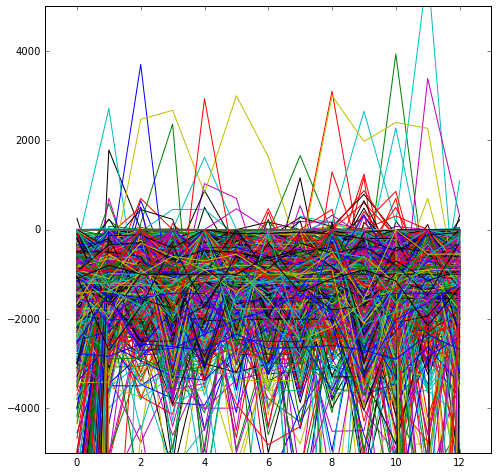

Iteracio: 2
-13485.0 [-500.]
[-1132.45553203] [ 132.45553203]
[-1739.61284279] [ 739.61284279]
6564.99047981
Iteracio: 13
-1715.0 [-3556.]
[-4188.45553203] [-2923.54446797]
[-4795.61284279] [-2316.38715721]
8586.5830806
Iteracio: 27
-2400.0 [-485.93049089]
[-1113.56271977] [ 141.70173799]
[-1716.0896595] [ 744.22867771]
1550.44509738
Iteracio: 32
-2202.0 [-961.375]
[-1593.83053203] [-328.91946797]
[-2200.98784279] [ 278.23784279]
2375.24272444
Iteracio: 35
-2500.0 [-937.5]
[-1569.95553203] [-305.04446797]
[-2177.11284279] [ 302.11284279]
4038.39076861
Iteracio: 41
0.0 [-975.00002085]
[-1286.99962734] [-663.00041436]
[-1586.51924957] [-363.48079213]
1137.40933705
Iteracio: 48
-315.0 [-1349.61585308]
[-1643.0387559] [-1056.19295025]
[-1924.72474262] [-774.50696354]
1546.85778273
Iteracio: 68
-2550.0 [-1134.5]
[-1766.95553203] [-502.04446797]
[-2374.11284279] [ 105.11284279]
1427.67363217
Iteracio: 70
-100.0 [-827.5]
[-1091.77968248] [-563.22031752]
[-1345.48817766] [-309.51182234]
1134.4

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 1, 'task': 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT', 'grad': array([ -2.68513897e+03,  -0.00000000e+00,  -1.80441057e-01,
         4.74788660e-08,  -5.69515429e-08,  -1.80441000e-01,
        -0.00000000e+00,  -2.68513897e+03]), 'nit': 834, 'funcalls': 15014}
  " state: %s" % convergence_dict)


Iteracio: 263
-2502.0 [-1094.87500137]
[-1727.3305334] [-462.41946933]
[-2334.48784415] [ 144.73784142]
2133.63891041
Iteracio: 265
-2400.0 [-581.625]
[-1214.08053203] [ 50.83053203]
[-1821.23784279] [ 657.98784279]
2850.51925094
Iteracio: 271
-10700.0 [-700.00000179]
[-1323.96908239] [-76.03092119]
[-1922.97939977] [ 522.97939619]
1655.38515156
Iteracio: 282
-8000.0 [-1364.37498464]
[-1996.83051667] [-731.91945261]
[-2603.98782743] [-124.76214185]
4232.04737686
Iteracio: 289
-2400.0 [-499.99997294]
[-1132.45550497] [ 132.4555591]
[-1739.61281572] [ 739.61286985]
2972.84375641
Iteracio: 290
-18387.0 [-1064.625]
[-1697.08053203] [-432.16946797]
[-2304.23784279] [ 174.98784279]
3423.25576024
Iteracio: 293
-2454.0 [-1073.625]
[-1706.08053203] [-441.16946797]
[-2313.23784279] [ 165.98784279]
2107.846057
Iteracio: 294
-140.0 [-1186.25011461]
[-1683.04123214] [-689.45899708]
[-2159.96070497] [-212.53952425]
1256.34390196
Iteracio: 301
-2500.0 [-975.]
[-1607.45553203] [-342.54446797]
[-2214.6

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 1, 'task': 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT', 'grad': array([ -2.99083180e-02,  -0.00000000e+00,  -2.99093451e-02,
        -0.00000000e+00,  -0.00000000e+00,  -2.99083180e-02,
        -0.00000000e+00,  -2.31019539e+03]), 'nit': 834, 'funcalls': 15014}
  " state: %s" % convergence_dict)


Iteracio: 836
-2566.0 [-1117.12500111]
[-1749.58053314] [-484.66946907]
[-2356.73784389] [ 122.48784168]
2173.50385323
Iteracio: 848
0.0 [-1587.49999905]
[-2135.22294315] [-1039.77705496]
[-2661.03696948] [-513.96302863]
3009.76743288
Iteracio: 858
-3040.0 [-1777.49998439]
[-2409.95551643] [-1145.04445236]
[-3017.11282718] [-537.88714161]
3885.56302227
Iteracio: 859
-9664.0 [-1183.75]
[-1816.20553203] [-551.29446797]
[-2423.36284279] [ 55.86284279]
4065.15411762
Iteracio: 861
-100.0 [-1081.25]
[-1531.78747249] [-630.71252752]
[-1964.30344607] [-198.19655394]
969.690672328


/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 1, 'task': 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT', 'grad': array([ -7.17511920e+05,  -0.00000000e+00,  -4.77256795e+01,
        -1.39736604e-03,   1.16833519e-04,  -4.77260076e+01,
        -0.00000000e+00,  -7.17511920e+05]), 'nit': 834, 'funcalls': 15014}
  " state: %s" % convergence_dict)


Iteracio: 873
-3298.0 [-517.75]
[-1150.20553203] [ 114.70553203]
[-1757.36284279] [ 721.86284279]
3128.10293948
Iteracio: 879
-2500.0 [-954.89027211]
[-1587.34580414] [-322.43474007]
[-2194.50311489] [ 284.72257068]
4501.39978229
Iteracio: 880
-2200.0 [-450.]
[-1082.45553203] [ 182.45553203]
[-1689.61284279] [ 789.61284279]
1626.46856717
Iteracio: 882
-2400.0 [-925.]
[-1372.21469656] [-477.78530344]
[-1801.54080526] [-48.45919474]
1480.4053499
Iteracio: 893
-3286.0 [-1737.875]
[-2370.33053203] [-1105.41946797]
[-2977.48784279] [-498.26215721]
5846.2077452
Iteracio: 897
-2882.0 [-1124.75]
[-1757.20553203] [-492.29446797]
[-2364.36284279] [ 114.86284279]
2633.60551336
Iteracio: 912
-178.0 [-1205.41189901]
[-1601.48076041] [-809.34303762]
[-1981.70686735] [-429.11693068]
1388.83728349
Iteracio: 913
0.0 [-1312.5]
[-1944.95553203] [-680.04446797]
[-2552.11284279] [-72.88715721]
8915.17806889
Iteracio: 915
0.0 [-1640.]
[-2272.45553203] [-1007.54446797]
[-2879.61284279] [-400.38715721]
40116.

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 1, 'task': 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT', 'grad': array([ -6.34231337e+02,  -0.00000000e+00,  -4.21383287e-02,
        -1.23766022e-06,   1.03480545e-07,  -4.21385251e-02,
        -0.00000000e+00,  -6.34231337e+02]), 'nit': 834, 'funcalls': 15014}
  " state: %s" % convergence_dict)


Iteracio: 985
-6764.0 [-2959.875]
[-3592.33053203] [-2327.41946797]
[-4199.48784279] [-1720.26215721]
8839.17875145
Iteracio: 998
-2585.0 [-1055.25000293]
[-1686.52163811] [-423.97836776]
[-2292.54240787] [ 182.04240201]
1798.50938279
Iteracio: 1017
-3325.0 [-817.69859556]
[-1450.15412759] [-185.24306352]
[-2057.31143834] [ 421.91424723]
2482.84614908
Iteracio: 1020
-2486.0 [-1119.25]
[-1751.70553203] [-486.79446797]
[-2358.86284279] [ 120.36284279]
2093.57803771


/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 1, 'task': 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT', 'grad': array([ -1.91447931e+02,  -0.00000000e+00,  -1.26864973e-02,
        -3.75328647e-07,   3.13811595e-08,  -1.26865849e-02,
        -0.00000000e+00,  -1.91447931e+02]), 'nit': 834, 'funcalls': 15014}
  " state: %s" % convergence_dict)


Iteracio: 1024
-2450.0 [-732.125]
[-1364.58053203] [-99.66946797]
[-1971.73784279] [ 507.48784279]
1950.16178816
Iteracio: 1026
-1358.0 [-762.5]
[-922.91986709] [-602.08013291]
[-1076.9229395] [-448.0770605]
1288.60350768
Iteracio: 1047
0.0 [-2000.00009575]
[-2632.45562778] [-1367.54456372]
[-3239.61293854] [-760.38725296]
3970.56671018
Iteracio: 1056
-87.0 [-1218.12499971]
[-1709.57631272] [-726.6736867]
[-2181.3695732] [-254.88042621]
1221.23994366
Iteracio: 1057
-2500.0 [-1573.75]
[-1793.98692667] [-1353.51307333]
[-2005.41437627] [-1142.08562373]
1439.58188374
Iteracio: 1069
0.0 [-1875.]
[-2507.45553203] [-1242.54446797]
[-3114.61284279] [-635.38715721]
20209.0623236
Iteracio: 1082
-4000.0 [-1187.49996991]
[-1819.95550194] [-555.04443787]
[-2427.11281269] [ 52.11287288]
3451.21949461
Iteracio: 1091
-1426.0 [-815.50012658]
[-1122.28548378] [-508.71476939]
[-1416.79942668] [-214.20082649]
1369.14535386
Iteracio: 1100
-1640.0 [-1023.75]
[-1324.3134265] [-723.1865735]
[-1612.85431594] 

array([ 0.85162424])

In [93]:
#Llegim les comptes del 18è cluster
accountcluster18=np.zeros((len(assignmentsclus[17]),13))
for i in np.arange(len(assignmentsclus[17])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster18[i]=accountclean[assignmentsclus[17][i].astype(int)]

print accountcluster18.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster18.shape[0]):
        plt.plot(accountcluster18[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 3140.0**2 * RBF(length_scale=450.0)  # long term smooth rising trend
#k2 = 3.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k2= 51.0*ExpSineSquared(length_scale=24.0, periodicity=4.0) 
k3 = 3.5**2* RationalQuadratic(length_scale=14.0, alpha=0.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=10.2**2)  # noise terms
kernel_gpmlini = k1+k2+k3+k4


gp18 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster18,accountcluster18.shape[0],gp18,17)

(1468, 13)


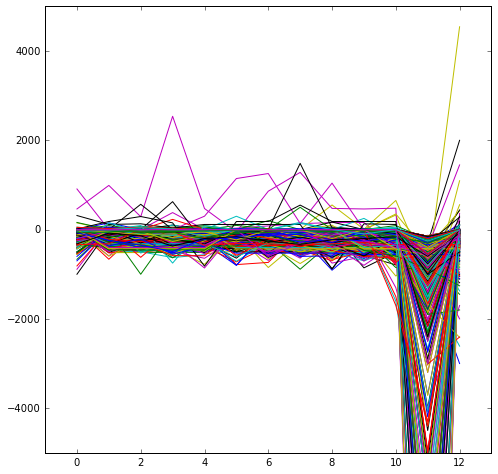

Iteracio: 2
-1100.0 [ 0.]
[-132.28756538] [ 132.28756538]
[-259.28362815] [ 259.28362815]
122.331516789
Iteracio: 6
-600.0 [-106.25247382]
[-315.88277305] [ 103.37782541]
[-517.12786032] [ 304.62291268]
516.333225737
Iteracio: 16
-720.0 [-43.75]
[-240.5009887] [ 153.0009887]
[-429.38193785] [ 341.88193785]
394.358973525
Iteracio: 35
-590.0 [-38.75]
[-229.47222255] [ 151.97222255]
[-412.56555621] [ 335.06555621]
360.824056848
Iteracio: 44
-1048.0 [-9.125]
[-75.27114958] [ 57.02114958]
[-138.77145318] [ 120.52145318]
89.8109124773
Iteracio: 48
2000.0 [ 0.]
[-120.63194492] [ 120.63194492]
[-236.43861203] [ 236.43861203]
171.248357656
Iteracio: 78
-850.0 [-75.]
[-435.56358226] [ 285.56358227]
[-781.70462124] [ 631.70462124]
928.813759588
Iteracio: 94
-260.0 [ 0.]
[-59.52938387] [ 59.52938387]
[-116.67759239] [ 116.67759239]
100.623058987
Iteracio: 134
-1110.0 [-151.25]
[-318.27611969] [ 15.77611969]
[-478.62119459] [ 176.12119459]
488.968301631
Iteracio: 136
-2610.0 [-139.99999813]
[-519.9

Iteracio: 1267
-977.0 [-5.]
[-205.94035714] [ 195.94035714]
[-398.84309999] [ 388.84309999]
281.099626467
Iteracio: 1268
-1800.0 [ 0.]
[-626.49922641] [ 626.49922641]
[-1227.93848375] [ 1227.93848375]
1636.09474053
Iteracio: 1273
-250.0 [-28.74999996]
[-113.88853976] [ 56.38853983]
[-195.62153796] [ 138.12153803]
175.353927815
Iteracio: 1278
-250.0 [-32.64442939]
[-120.97226329] [ 55.68340451]
[-205.76698384] [ 140.47812505]
180.626686843
Iteracio: 1316
-700.0 [-42.5]
[-252.60414395] [ 167.60414394]
[-454.30412213] [ 369.30412213]
629.956347694
Iteracio: 1361
-202.0 [-3.25]
[-60.35078873] [ 53.85078873]
[-115.16754591] [ 108.66754591]
131.487642005
Iteracio: 1369
-900.0 [-262.49999504]
[-473.13264536] [-51.86734471]
[-675.33998967] [ 150.3399996]
641.633072714
Iteracio: 1371
-583.0 [-204.91772319]
[-375.04675441] [-34.78869197]
[-538.37062438] [ 128.535178]
398.332775453
Iteracio: 1378
-6000.0 [ 0.]
[-632.45609118] [ 632.45609118]
[-1239.61393872] [ 1239.61393872]
5721.02831666
Iteraci

array([ 0.84423523])

In [94]:
#Llegim les comptes del 19è cluster
accountcluster19=np.zeros((len(assignmentsclus[18]),13))
for i in np.arange(len(assignmentsclus[18])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster19[i]=accountclean[assignmentsclus[18][i].astype(int)]

print accountcluster19.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster19.shape[0]):
        plt.plot(accountcluster19[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 243.0**2 * RBF(length_scale=56.0)  # long term smooth rising trend
k2 = 3.0**2 * RBF(length_scale=4.0) 
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k3 = 3.5**2* RationalQuadratic(length_scale=5.0, alpha=1.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=0.2**2)  # noise terms
kernel_gpmlini = k1+k2+k3+k4


gp19 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster19,accountcluster19.shape[0],gp19,18)

(554, 13)


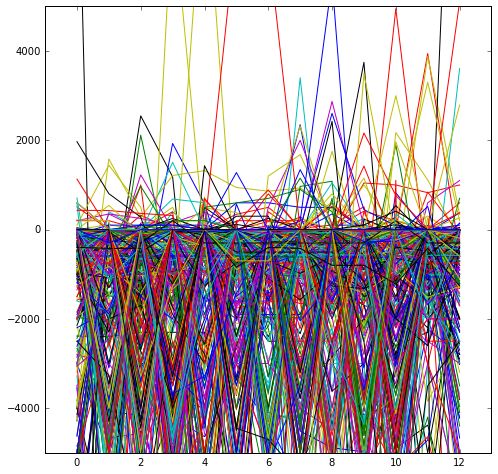

Iteracio: 4
-2965.0 [-1078.75]
[-1711.20553213] [-446.29446787]
[-2318.36284297] [ 160.86284297]
2895.48976859
Iteracio: 19
-6200.0 [-650.]
[-1357.10678119] [ 57.10678119]
[-2035.92929113] [ 735.92929113]
1872.15090204
Iteracio: 24
0.0 [-1684.125]
[-2316.58077516] [-1051.66922484]
[-2923.73831931] [-444.51168069]
3983.50737416
Iteracio: 25
0.0 [-3931.625]
[-4638.73178119] [-3224.51821881]
[-5317.55429113] [-2545.69570887]
20547.3208716
Iteracio: 27
-26.0 [-1580.25]
[-2287.35678119] [-873.14321881]
[-2966.17929113] [-194.32070887]
6022.82309221
Iteracio: 35
-4226.0 [-1014.87502283]
[-1647.33164664] [-382.41839903]
[-2254.49000549] [ 224.73995983]
5366.40810971


/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 1, 'task': 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT', 'grad': array([ -1.26185443e+00,  -0.00000000e+00,  -1.26185443e+00,
        -0.00000000e+00,  -1.26172864e+00,  -7.77339286e-04,
         6.34400694e-05,  -1.26185443e+00,  -0.00000000e+00,
        -9.71150419e+04]), 'nit': 834, 'funcalls': 15014}
  " state: %s" % convergence_dict)


Iteracio: 55
0.0 [-1780.62498877]
[-2487.73176995] [-1073.51820758]
[-3166.55427989] [-394.69569764]
9409.79585326
Iteracio: 62
0.0 [-1597.6361707]
[-2304.74295188] [-890.52938951]
[-2983.56546182] [-211.70687957]
3890.72551075
Iteracio: 65
-11500.0 [-921.875]
[-1628.98178119] [-214.76821881]
[-2307.80429113] [ 464.05429113]
3030.41647303
Iteracio: 69
-6960.0 [-1894.42794641]
[-2601.5347276] [-1187.32116522]
[-3280.35723754] [-508.49865528]
6844.01183517
Iteracio: 74
-18000.0 [-6875.00000001]
[-7582.10678119] [-6167.89321882]
[-8260.92929113] [-5489.07070888]
92827.7042375
Iteracio: 75
-8001.0 [-4655.24997449]
[-5287.70560347] [-4022.79434552]
[-5894.86300728] [-3415.6369417]
12187.3417528
Iteracio: 76
-576.0 [-2821.625]
[-3528.73178119] [-2114.51821881]
[-4207.55429113] [-1435.69570887]
12660.6959129
Iteracio: 77
-14526.0 [-7655.24999967]
[-8362.35678086] [-6948.14321849]
[-9041.1792908] [-6269.32070855]
27635.794036
Iteracio: 80
0.0 [-2252.5]
[-2884.95553208] [-1620.04446792]
[-3492.

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 1, 'task': 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT', 'grad': array([ -9.35237078e-04,  -0.00000000e+00,  -9.35237078e-04,
        -0.00000000e+00,  -9.35101023e-04,  -8.66879243e-07,
         7.41198187e-08,  -9.35237078e-04,  -0.00000000e+00,
        -7.31673137e+01]), 'nit': 834, 'funcalls': 15014}
  " state: %s" % convergence_dict)


Iteracio: 102
-2000.0 [ 0.]
[-632.45553283] [ 632.45553283]
[-1239.61284435] [ 1239.61284435]
2224.76470666
Iteracio: 103
-3198.0 [-312.49996668]
[-1019.60674786] [ 394.60681451]
[-1698.4292578] [ 1073.42932445]
2534.95108434
Iteracio: 116
0.0 [-1640.2702072]
[-2347.37698839] [-933.16342601]
[-3026.19949833] [-254.34091607]
3260.60929889
Iteracio: 125
0.0 [-3000.]
[-3707.10678119] [-2292.89321881]
[-4385.92929113] [-1614.07070887]
14843.7394547
Iteracio: 126
-4668.0 [-506.12486505]
[-1213.23164623] [ 200.98191614]
[-1892.05415617] [ 879.80442608]
2946.05023718
Iteracio: 133
-5000.0 [-520.]
[-1152.45553372] [ 112.45553372]
[-1759.6128461] [ 719.6128461]
2749.61615503
Iteracio: 141
-5450.0 [-738.75]
[-1371.20558411] [-106.29441589]
[-1978.36294485] [ 500.86294485]
2294.74290499
Iteracio: 142
-32414.0 [-17124.5]
[-17831.60678119] [-16417.39321881]
[-18510.42929113] [-15738.57070887]
282550.992952
Iteracio: 152
0.0 [-1500.00010812]
[-2207.10688931] [-792.89332694]
[-2885.92939925] [-114.07

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 1, 'task': 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT', 'grad': array([ -1.34128544e-03,  -0.00000000e+00,  -1.34128544e-03,
        -0.00000000e+00,  -1.34110723e-03,  -1.14813064e-06,
         9.74695932e-08,  -1.34128544e-03,  -0.00000000e+00,
        -1.04437544e+02]), 'nit': 834, 'funcalls': 15014}
  " state: %s" % convergence_dict)


Iteracio: 234
0.0 [-1408.02412789]
[-2040.48007144] [-775.56818435]
[-2647.63777724] [-168.41047855]
2796.76545316
Iteracio: 236
-100.0 [-2142.50005159]
[-2849.60683278] [-1435.39327041]
[-3528.42934272] [-756.57076047]
5091.7978161
Iteracio: 237
-2000.0 [-62.5]
[-769.60678119] [ 644.60678119]
[-1448.42929113] [ 1323.42929113]
1215.76025597
Iteracio: 241
-5582.0 [-468.23298138]
[-1015.95553899] [ 79.48957624]
[-1541.76919429] [ 605.30323154]
2849.02755339
Iteracio: 266
-2702.0 [-994.125]
[-1701.23178119] [-287.01821881]
[-2380.05429113] [ 391.80429113]
6946.97308185
Iteracio: 269
0.0 [-3249.3749836]
[-3956.48176479] [-2542.26820242]
[-4635.30427473] [-1863.44569248]
18798.1786352
Iteracio: 270
-5160.0 [-6679.87500279]
[-7386.98178398] [-5972.7682216]
[-8065.80429392] [-5293.94571167]
12943.590576
Iteracio: 280
-2000.0 [-391.74995465]
[-1024.20610782] [ 240.70619851]
[-1631.36401485] [ 847.86410555]
2776.33373354
Iteracio: 288
-3966.0 [-1553.625]
[-2260.73178119] [-846.51821881]
[-2939.

array([ 0.60266012])

In [95]:
#Llegim les comptes del 20è cluster
accountcluster20=np.zeros((len(assignmentsclus[19]),13))
for i in np.arange(len(assignmentsclus[19])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster20[i]=accountclean[assignmentsclus[19][i].astype(int)]

print accountcluster20.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster20.shape[0]):
        plt.plot(accountcluster20[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 3650.0**2 * RBF(length_scale=720.0)  # long term smooth rising trend
k2 = 30.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k3 = 4.5**2* RationalQuadratic(length_scale=21.0, alpha=0.5)
k4 = 0.5**2 * RBF(length_scale=1.3) \
    + WhiteKernel(noise_level=20.2**2)  # noise terms
kernel_gpmlini = k1+k2+k3+k4


gp20 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster20,accountcluster20.shape[0],gp20,19)

(554, 13)


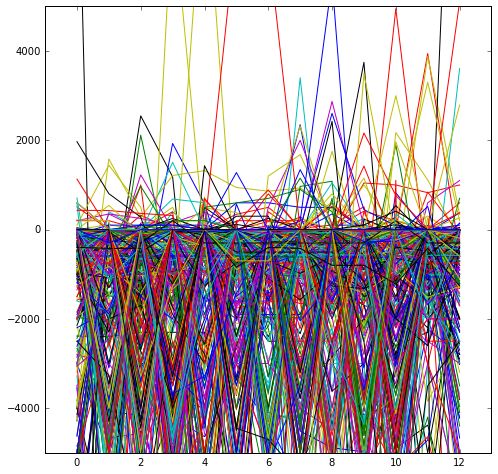

0
-4200.0 [-2624.99999552]
1
0.0 [-333.33333319]
2
-513.0 [-32.83333333]
3
0.0 [-500.]
4
-2965.0 [-1089.5]
5
0.0 [-416.66666667]
6
-2900.0 [-2062.500004]
7
0.0 [-831.91606418]
8
0.0 [-417.83333333]
9
0.0 [-416.66660095]
10
0.0 [-450.00006573]
11
0.0 [-359.41661985]
12
0.0 [-650.]
13
0.0 [-1726.33333333]
14
-50.0 [-458.33330362]
15
0.0 [-494.24182377]
16
0.0 [-649.41677971]
17
0.0 [-585.72720936]
18
-905.0 [-905.83333333]
19
-6200.0 [-916.66662963]
20
-120.0 [-835.]
21
0.0 [-613.33305299]
22
-305.0 [-1521.75]
23
0.0 [-812.33333334]
24
0.0 [-1866.83333333]
25
0.0 [-5949.83333333]
26
-180.0 [-836.33321497]
27
-26.0 [-1234.75]
28
-1225.0 [-2952.33062206]
29
0.0 [-472.99994067]
30
0.0 [-416.66666667]
31
0.0 [-333.16666667]
32
150.0 [-653.41668005]
33
0.0 [-349.91662556]
34
0.0 [-356.41654275]
35
-4226.0 [-1780.91666667]
36
0.0 [-1110.6666272]
37
0.0 [-377.49999658]
38
-980.0 [-1400.47558396]
39
-250.0 [-1094.66666666]
40
0.0 [-666.75]
41
0.0 [-416.66666667]
42
376.0 [-535.08333333]
43
0.0 [

337
0.0 [-641.33333333]
338
0.0 [-1300.81631584]
339
0.0 [-452.4999548]
340
-6000.0 [-3620.83333333]
341
-2500.0 [-3061.91668366]
342
-2000.0 [-625.00000155]
343
0.0 [-750.00002619]
344
700.0 [-308.33333333]
345
0.0 [-1339.37093844]
346
0.0 [-307.33333333]
347
-900.0 [-775.00018511]
348
-2139.0 [-728.7780733]
349
-372.0 [-1319.66666667]
350
0.0 [-791.66664383]
351
-1175.0 [-1115.25]
352
0.0 [-375.24999607]
353
-1095.0 [-389.75]
354
0.0 [-873.66666667]
355
0.0 [-525.]
356
0.0 [-1041.84383223]
357
-3808.0 [-1427.49995746]
358
0.0 [-594.0000811]
359
-2000.0 [-833.33333333]
360
0.0 [-394.83333333]
361
-73.0 [-1335.41666667]
362
-89.0 [-331.16666667]
363
-1200.0 [-1041.66666667]
364
0.0 [-380.24992095]
365
-4100.0 [-1640.99972128]
366
-2500.0 [-2583.33333333]
367
-300.0 [-540.25]
368
-5639.0 [-627.08333333]
369
0.0 [-372.75]
370
0.0 [-333.33333328]
371
0.0 [-836.83333333]
372
-250.0 [-713.24994726]
373
0.0 [-374.99995718]
374
0.0 [-569.16666667]
375
0.0 [-666.66666667]
376
-311.0 [-794.6666

In [40]:
#Llegim les comptes del 20è cluster
accountcluster20=np.zeros((len(assignmentsclus[19]),13))
for i in np.arange(len(assignmentsclus[19])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster20[i]=accountclean[assignmentsclus[19][i].astype(int)]

print accountcluster20.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster20.shape[0]):
        plt.plot(accountcluster20[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 3650.0**2 * RBF(length_scale=720.0)  # long term smooth rising trend
k2 = 30.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k3 = 4.5**2* RationalQuadratic(length_scale=21.0, alpha=0.5)
k4 = 0.5**2 * RBF(length_scale=1.3) \
    + WhiteKernel(noise_level=20.2**2)  # noise terms
kernel_gpmlini = k1+k2+k3+k4


gp20 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regression1(accountcluster20,accountcluster20.shape[0],gp20,19)

(2447, 13)


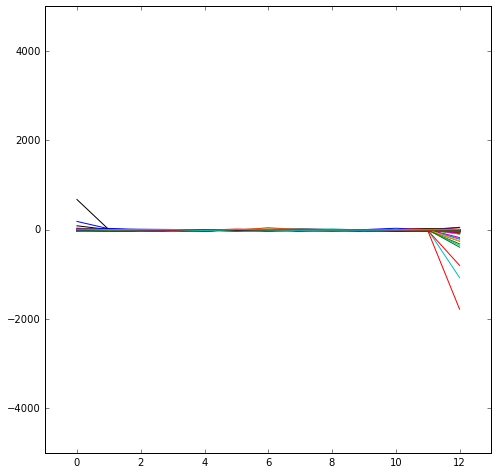

Iteracio: 0
-40.0 [-3.375]
[-10.99077697] [ 4.24077697]
[-18.30192286] [ 11.55192286]
14.9331845231
Iteracio: 14
-30.0 [-9.375]
[-19.29656716] [ 0.54656716]
[-28.82127164] [ 10.07127164]
25.8069758011
Iteracio: 15
-320.0 [-13.5000005]
[-22.9276926] [-4.0723084]
[-31.97827702] [ 4.97827602]
25.4558441227
Iteracio: 18
0.0 [-13.75]
[-18.9156956] [-8.5843044]
[-23.87476337] [-3.62523663]
23.0
Iteracio: 25
-79.0 [-3.625]
[-10.77955197] [ 3.52955197]
[-17.64792185] [ 10.39792185]
14.4568322948
Iteracio: 33
-19.0 [-0.66115766]
[-7.78506096] [ 6.46274563]
[-14.62400813] [ 13.3016928]
11.3578166916
Iteracio: 44
-26.0 [ 0.]
[-6.3233312] [ 6.3233312]
[-12.39372915] [ 12.39372915]
6.32455532034
Iteracio: 56
-26.0 [-1.625]
[-8.49035458] [ 5.24035458]
[-15.08109497] [ 11.83109497]
10.4880884817
Iteracio: 58
-43.0 [-12.125]
[-22.18032526] [-2.06967474]
[-31.83343751] [ 7.58343751]
38.4187454246
Iteracio: 84
-25.0 [-1.12500021]
[-6.25912012] [ 4.00911969]
[-11.18787524] [ 8.93787481]
9.48683298051
Ite

Iteracio: 1069
-40.0 [ 0.]
[-7.77720693] [ 7.77720693]
[-15.24332559] [ 15.24332559]
10.7703296143
Iteracio: 1070
-96.0 [-9.24999999]
[-20.17874575] [ 1.67874577]
[-30.67034168] [ 12.1703417]
35.902646142
Iteracio: 1082
0.0 [-9.62373242]
[-12.99889075] [-6.24857409]
[-16.23904274] [-3.0084221]
15.3622914957
Iteracio: 1095
-20.0 [-2.]
[-6.76969683] [ 2.76969683]
[-11.34860579] [ 7.34860579]
5.47722557505
Iteracio: 1099
-44.0 [-1.12499974]
[-6.81353424] [ 4.56353476]
[-12.27452735] [ 10.02452787]
5.09901951359
Iteracio: 1108
-801.0 [-4.12499953]
[-9.30722575] [ 1.05722669]
[-14.28216293] [ 6.03216386]
16.0
Iteracio: 1109
-353.0 [-1.25001246]
[-5.80351533] [ 3.30349041]
[-10.17487808] [ 7.67485316]
10.0
Iteracio: 1125
-15.0 [ 0.]
[-5.555128] [ 5.555128]
[-10.88805088] [ 10.88805088]
4.0
Iteracio: 1129
-12.0 [-2.14765325]
[-6.64765569] [ 2.35234919]
[-10.96765803] [ 6.67235152]
21.3307290077
Iteracio: 1134
-7.0 [ 0.]
[-2.82566466] [ 2.82566466]
[-5.53830273] [ 5.53830273]
5.65685424949
Ite

Iteracio: 2189
0.0 [-11.75]
[-15.65285703] [-7.84714297]
[-19.39959979] [-4.10040021]
15.7797338381
Iteracio: 2196
-35.0 [-0.5]
[-4.35478841] [ 3.35478841]
[-8.05538528] [ 7.05538528]
7.14142842854
Iteracio: 2208
-9.0 [-1.00000056]
[-4.68908901] [ 2.68908789]
[-8.23061391] [ 6.2306128]
8.48528137424
Iteracio: 2216
-40.0 [-2.875]
[-12.64021891] [ 6.89021891]
[-22.01482906] [ 16.26482906]
18.547236991
Iteracio: 2217
-256.0 [-3.74999994]
[-11.17883028] [ 3.67883041]
[-18.31050741] [ 10.81050754]
22.8473193176
Iteracio: 2222
-20.0 [ 0.]
[-8.66027055] [ 8.66027055]
[-16.97413027] [ 16.97413027]
13.4536240471
Iteracio: 2226
-23.0 [-3.]
[-10.15454404] [ 4.15454404]
[-17.02290632] [ 11.02290632]
12.7279220614
Iteracio: 2234
0.0 [-12.25000041]
[-16.79385433] [-7.70614649]
[-21.15595409] [-3.34404672]
16.0312195419
Iteracio: 2254
0.0 [-9.5]
[-13.44500108] [-5.55499892]
[-17.23220212] [-1.76779788]
14.2478068488
Iteracio: 2265
-44.0 [-2.5]
[-8.88234507] [ 3.88234507]
[-15.00939633] [ 10.00939633]

array([ 0.44378966])

In [96]:
#Llegim les comptes del 21è cluster
accountcluster21=np.zeros((len(assignmentsclus[20]),13))
for i in np.arange(len(assignmentsclus[20])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster21[i]=accountclean[assignmentsclus[20][i].astype(int)]

print accountcluster21.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster21.shape[0]):
        plt.plot(accountcluster21[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 35.0**2 * RBF(length_scale=12.0)  # long term smooth rising trend
#k2 = 3.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k2=7.5*DotProduct(sigma_0=5.0)
k3 = 1.5**2* RationalQuadratic(length_scale=2.0, alpha=0.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=0.2**2)  # noise terms
kernel_gpmlini = k1+k2+k3+k4


gp21 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster21,accountcluster21.shape[0],gp21,20)

(3072, 13)


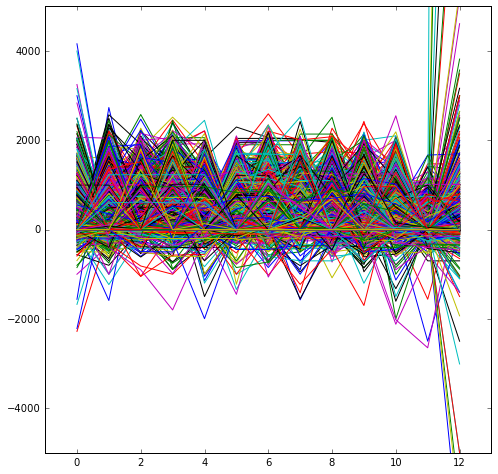

Iteracio: 35
1250.0 [ 613.75]
[ 368.13825062] [ 859.36174938]
[ 132.35097122] [ 1095.14902879]
1543.477891
Iteracio: 47
1600.0 [ 0.]
[-529.15024984] [ 529.15024984]
[-1037.13448968] [ 1037.13448968]
950.998948475
Iteracio: 48
1000.0 [ 165.125]
[-139.2193575] [ 469.4693575]
[-431.3899407] [ 761.6399407]
695.548704262
Iteracio: 51
3495.0 [ 143.125]
[-404.59802542] [ 690.84802542]
[-930.41212983] [ 1216.66212983]
1608.34946451
Iteracio: 55
-2500.0 [-198.75]
[-746.47300981] [ 348.97300981]
[-1272.28709923] [ 874.78709923]
1734.25920785
Iteracio: 113
1850.0 [ 131.25]
[-501.20553203] [ 763.70553203]
[-1108.36284279] [ 1370.86284279]
1576.09454031
Iteracio: 124
1214.0 [ 100.25]
[-406.46587981] [ 606.96587981]
[-892.91312443] [ 1093.41312443]
1162.59537243
Iteracio: 135
1000.0 [ 56.25]
[-200.45691038] [ 312.95691038]
[-446.89554434] [ 559.39554434]
370.943391908
Iteracio: 145
38000.0 [ 0.]
[-496.09923913] [ 496.09923913]
[-972.35450869] [ 972.35450869]
852.876896158
Iteracio: 159
3000.0 [ 25.]

Iteracio: 1706
1000.0 [ 83.55750962]
[-178.08710199] [ 345.20212124]
[-429.26592915] [ 596.38094839]
583.266662857
Iteracio: 1734
1765.0 [ 196.875]
[-51.56825066] [ 445.31825066]
[-290.0737713] [ 683.8237713]
543.075501197
Iteracio: 1746
1150.0 [-143.75]
[-776.20553203] [ 488.70553203]
[-1383.36284279] [ 1095.86284279]
1829.98606552
Iteracio: 1764
1258.0 [ 49.625]
[-120.18960031] [ 219.43960031]
[-283.2116166] [ 382.4616166]
425.46210172
Iteracio: 1766
1185.0 [ 0.]
[-261.26742298] [ 261.26742298]
[-512.08414905] [ 512.08414905]
214.007009231
Iteracio: 1767
131801.0 [ 0.]
[-547.72301767] [ 547.72301767]
[-1073.53711464] [ 1073.53711464]
1345.26205626
Iteracio: 1802
840.0 [ 82.625]
[-200.49339049] [ 365.74339049]
[-472.28704537] [ 637.53704537]
413.479140949
Iteracio: 1836
1337.0 [ 216.625]
[-300.31145105] [ 733.56145105]
[-796.57044406] [ 1229.82044406]
1325.1022602
Iteracio: 1851
20000.0 [ 0.]
[-330.71890812] [ 330.71890812]
[-648.20905991] [ 648.20905991]
377.357920283
Iteracio: 1852


array([ 0.86160564])

In [98]:
#Llegim les comptes del 22è cluster
accountcluster22=np.zeros((len(assignmentsclus[21]),13))
for i in np.arange(len(assignmentsclus[21])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster22[i]=accountclean[assignmentsclus[21][i].astype(int)]

print accountcluster22.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster22.shape[0]):
        plt.plot(accountcluster22[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 680.0**2 * RBF(length_scale=210.0)  # long term smooth rising trend
#k2 = 3.0**2 * RBF(length_scale=10.0) \
k2= 100* ExpSineSquared(length_scale=21.0, periodicity=4.0)+0.001  # seasonal component
# medium term irregularity
k3 = 1.5**2* RationalQuadratic(length_scale=2.0, alpha=0.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=0.2**2)  # noise terms
kernel_gpmlini = k1+k2+k3+k4


gp22 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster22,accountcluster22.shape[0],gp22,21)

(3042, 13)


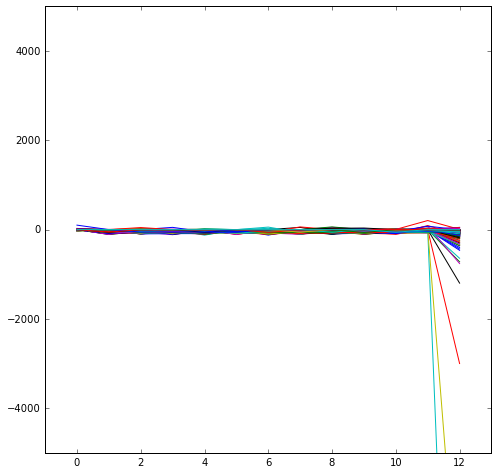

Iteracio: 11
-361.0 [-4.49999944]
[-30.58555113] [ 21.58555225]
[-55.62768075] [ 46.62768187]
38.6393581727
Iteracio: 34
-70.0 [-4.97644118]
[-33.69687652] [ 23.74399416]
[-61.26849445] [ 51.31561208]
54.083269132
Iteracio: 50
0.0 [-53.125]
[-79.01437756] [-27.23562245]
[-103.86818001] [-2.38182]
78.1984654581
Iteracio: 55
-41.0 [ 0.]
[-16.20551386] [ 16.20551386]
[-31.76280716] [ 31.76280716]
1.0
Iteracio: 68
-79.0 [-3.25]
[-21.93152712] [ 15.43152712]
[-39.86579315] [ 33.36579315]
26.3058928759
Iteracio: 93
-50.0 [ 1.25004896]
[-19.92630066] [ 22.42639857]
[-40.25559629] [ 42.7556942]
22.360679775
Iteracio: 107
-147.0 [ 0.]
[-22.15864703] [ 22.15864703]
[-43.43094818] [ 43.43094818]
17.0
Iteracio: 111
-76.0 [ 0.]
[-34.64101938] [ 34.64101938]
[-67.89639798] [ 67.89639798]
65.574385243
Iteracio: 144
-53.0 [-2.5]
[-24.68082174] [ 19.68082174]
[-45.9744106] [ 40.9744106]
33.7638860323
Iteracio: 168
-401.0 [ 0.]
[-16.86668681] [ 16.86668681]
[-33.05870614] [ 33.05870614]
1.0
Iteracio: 16

Iteracio: 1451
-53.0 [ 0.]
[-17.67245365] [ 17.67245365]
[-34.63800915] [ 34.63800915]
54.083269132
Iteracio: 1463
-120.0 [ 0.]
[-21.82863525] [ 21.82863525]
[-42.78412509] [ 42.78412509]
16.0
Iteracio: 1475
-60.0 [ 0.]
[-19.84363725] [ 19.84363725]
[-38.89352901] [ 38.89352901]
10.0
Iteracio: 1498
-41.0 [ 0.]
[-19.18170331] [ 19.18170331]
[-37.5961385] [ 37.5961385]
8.0
Iteracio: 1526
0.0 [-77.53351589]
[-110.73377801] [-44.33325377]
[-142.60602965] [-12.46100214]
79.385137148
Iteracio: 1535
-79.0 [ 0.]
[-19.8436011] [ 19.8436011]
[-38.89345815] [ 38.89345815]
10.0
Iteracio: 1556
-70.0 [ 0.]
[-18.52040337] [ 18.52040337]
[-36.29999061] [ 36.29999061]
6.0
Iteracio: 1569
-51.0 [-5.625]
[-22.77689648] [ 11.52689648]
[-39.2427171] [ 27.9927171]
24.6373699895
Iteracio: 1580
-72.0 [ 0.]
[-28.23696687] [ 28.23696687]
[-55.34445507] [ 55.34445507]
36.1386219992
Iteracio: 1613
-642.0 [ 0.]
[-19.84314099] [ 19.84314099]
[-38.89255635] [ 38.89255635]
10.0
Iteracio: 1615
-47.0 [ 0.]
[-21.49775358

Iteracio: 2950
-97.0 [-2.12499942]
[-18.81279896] [ 14.56280013]
[-34.83308653] [ 30.5830877]
17.0
Iteracio: 2954
-33.0 [ 0.]
[-15.54404121] [ 15.54404121]
[-30.46632077] [ 30.46632077]
3.0
Iteracio: 2987
-50.0 [ 0.]
[-16.53592761] [ 16.53592761]
[-32.41041811] [ 32.41041811]
0.0
Iteracio: 3007
-59.0 [ 0.]
[-25.54798368] [ 25.54798368]
[-50.07404801] [ 50.07404801]
12.7279220614
Iteracio: 3034
-60.0 [ 0.]
[-19.8436011] [ 19.8436011]
[-38.89345815] [ 38.89345815]
10.0
La predicció de compte en negatiu en predicció i real correctes és de: 0.67587113741
La predicció de compte en negatiu en predicció i real o 0 correctes és de: 0.942472057857
La predicció de compte esta compresa en la zona determinada: 0.91452991453
La predicció de compte ens permet assegurar el signe final: 0.942800788955
Comptes signe 0.9516765286
The Mean Absolute Scaled error is [ 0.88761031]
The MAE error is [ 19.14292987]
The RMSE is [ 363.61478462]


array([ 0.88761031])

In [ ]:
#Llegim les comptes del 23è cluster
accountcluster23=np.zeros((len(assignmentsclus[22]),13))
for i in np.arange(len(assignmentsclus[22])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster23[i]=accountclean[assignmentsclus[22][i].astype(int)]

print accountcluster23.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster23.shape[0]):
        plt.plot(accountcluster23[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 35.0**2 * RBF(length_scale=17.0)  # long term smooth rising trend
#k2 = 3.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k2= 3.0**2 * RBF(length_scale=2.0) 
k3 = 8.5**2* RationalQuadratic(length_scale=2.0, alpha=0.5)
k4 = 1.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=6.2**2)  # noise terms
kernel_gpmlini = k1+k2+k3+k4


gp23 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster23,accountcluster23.shape[0],gp23,22)

(1418, 13)


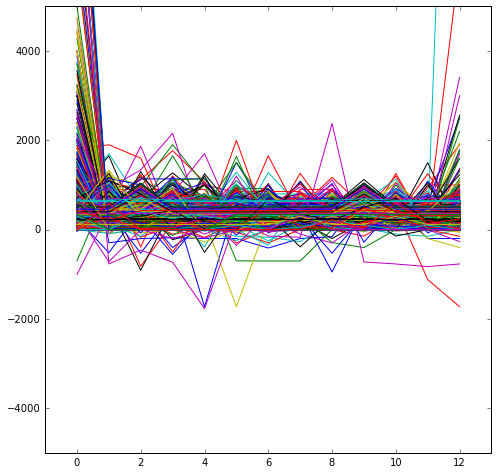

Iteracio: 8
1300.0 [ 262.5]
[ 108.24782165] [ 416.75217835]
[-39.83426956] [ 564.83426956]
317.622417345
Iteracio: 27
830.0 [ 446.125]
[ 289.85121227] [ 602.39878773]
[ 139.82837604] [ 752.42162396]
783.201123595
Iteracio: 37
1366.0 [ 0.28152985]
[-446.9324254] [ 447.4954851]
[-876.25782243] [ 876.82088214]
1200.88800477
Iteracio: 72
-1727.0 [ 59.125]
[-573.33053203] [ 691.58053203]
[-1180.48784279] [ 1298.73784279]
2540.84670927
Iteracio: 90
550.0 [ 237.49999823]
[ 145.85694429] [ 329.14305218]
[ 57.8796125] [ 417.12038397]
249.9899998
Iteracio: 116
520.0 [ 111.30262879]
[-96.26897162] [ 318.87422921]
[-295.53770801] [ 518.1429656]
513.215354408
Iteracio: 117
-75.0 [ 206.375]
[ 106.9012632] [ 305.8487368]
[ 11.40647588] [ 401.34352412]
399.924992967
Iteracio: 128
1328.0 [ 235.25]
[ 156.53893879] [ 313.96106121]
[ 80.97632002] [ 389.52367998]
200.691305243
Iteracio: 129
760.0 [ 135.00000001]
[ 27.43855055] [ 242.56144946]
[-75.82044092] [ 345.82044094]
298.010066944
Iteracio: 164
820.0

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 1, 'task': 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT', 'grad': array([ -4.61442076e-03,  -0.00000000e+00,  -4.61442383e-03,
        -8.96942891e-16,   8.33127038e-17,  -4.61442076e-03,
        -0.00000000e+00,  -3.57470096e+02]), 'nit': 834, 'funcalls': 15014}
  " state: %s" % convergence_dict)


Iteracio: 477
2200.0 [ 335.]
[ 1.5169602] [ 668.4830398]
[-318.62675801] [ 988.62675801]
820.864787891
Iteracio: 512
600.0 [ 300.]
[ 200.78432609] [ 399.21567391]
[ 105.53727914] [ 494.46272086]
669.705905603
Iteracio: 521
19100.0 [ 108.75]
[-9.02521202] [ 226.52521202]
[-122.08941555] [ 339.58941555]
345.673256125
Iteracio: 522
800.0 [ 187.5]
[-45.52947289] [ 420.52947289]
[-269.23776687] [ 644.23776687]
488.907966799
Iteracio: 582
0.0 [ 412.5]
[ 264.01283547] [ 560.98716453]
[ 121.46515752] [ 703.53484248]
707.298381166
Iteracio: 588
420.0 [ 300.]
[ 299.99665336] [ 300.00334664]
[ 299.99344059] [ 300.00655941]
659.474032847
Iteracio: 610
988.0 [ 381.375]
[ 116.73863063] [ 646.01136937]
[-137.31228396] [ 900.06228396]
776.69298954
Iteracio: 627
640.0 [ 240.]
[ 84.93951838] [ 395.06048162]
[-63.91854397] [ 543.91854397]
416.959230621
Iteracio: 665
1350.0 [ 259.99999996]
[-37.76019068] [ 557.7601906]
[-323.6099737] [ 843.60997361]
725.668657171
Iteracio: 671
316.0 [ 120.]
[ 47.88894243]

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 1, 'task': 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT', 'grad': array([ -4.44078892e-04,  -0.00000000e+00,  -4.44078871e-04,
        -9.50169132e-17,   8.82566328e-18,  -4.44078892e-04,
        -0.00000000e+00,  -3.53721848e+01]), 'nit': 834, 'funcalls': 15014}
  " state: %s" % convergence_dict)


Iteracio: 703
199.0 [ 0.]
[-82.78084828] [ 82.78084828]
[-162.25046264] [ 162.25046264]
325.229149985
Iteracio: 705
0.0 [ 192.75]
[ 95.1981707] [ 290.3018293]
[ 1.54841458] [ 383.95158542]
235.242428146
Iteracio: 730
6000.0 [ 45.25000569]
[-118.66722844] [ 209.16723981]
[-276.0277732] [ 366.52778458]
397.587726169
Iteracio: 731
500.0 [ 123.75]
[-8.57896563] [ 256.07896563]
[-135.61477263] [ 383.11477263]
406.907851976
Iteracio: 746
880.0 [ 315.25]
[ 72.04136569] [ 558.45863431]
[-161.43892325] [ 791.93892325]
1054.22341086
Iteracio: 753
0.0 [ 198.62498497]
[ 131.71646341] [ 265.53350653]
[ 67.48428271] [ 329.76568723]
216.480946044
Iteracio: 755
753.0 [ 257.75]
[ 34.92383431] [ 480.57616569]
[-178.98928475] [ 694.48928475]
687.088058403
Iteracio: 756
650.0 [ 37.5]
[-186.01900646] [ 261.01900646]
[-400.59725266] [ 475.59725266]
554.532235312
Iteracio: 760
0.0 [ 628.5310042]
[ 499.98740636] [ 757.07460204]
[ 376.58555243] [ 880.47645596]
422.977540775
Iteracio: 767
543.0 [ 73.75]
[-77.90

array([ 0.94013188])

In [19]:
#Llegim les comptes del 24è cluster
accountcluster24=np.zeros((len(assignmentsclus[23]),13))
for i in np.arange(len(assignmentsclus[23])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster24[i]=accountclean[assignmentsclus[23][i].astype(int)]

print accountcluster24.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster24.shape[0]):
        plt.plot(accountcluster24[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 532.0**2 * RBF(length_scale=45.0)  # long term smooth rising trend
#k2 = 12.0**2 * RBF(length_scale=10.0)*ExpSineSquared(length_scale=2.0, periodicity=2.0)+0.001  # seasonal component
# medium term irregularity
k2= 2.0**2 * RBF(length_scale=0.6)
k3 = 4.5**2* RationalQuadratic(length_scale=2.0, alpha=1.5)
k4 = 1.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=3.2**2)  # noise terms
kernel_gpmlini = k1+k3+k4


gp24 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=1e-7,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster24,accountcluster24.shape[0],gp24,23)

(1922, 13)


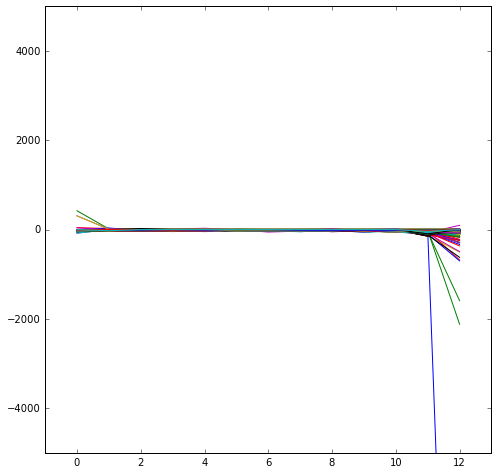

Iteracio: 2
-24.0 [-1.83333339]
[-12.69544233] [ 9.02877554]
[-23.12306691] [ 19.45640012]
31.9843711834
Iteracio: 3
0.0 [-18.]
[-26.48515521] [-9.51484479]
[-34.63090422] [-1.36909578]
17.7482393493
Iteracio: 10
-44.0 [ 0.]
[-10.19292082] [ 10.19292082]
[-19.97812481] [ 19.97812481]
19.1049731745
Iteracio: 31
18.0 [ 0.]
[-7.45198558] [ 7.45198558]
[-14.60589173] [ 14.60589173]
5.0
Iteracio: 35
-27.0 [-2.16666667]
[-13.53904418] [ 9.20571085]
[-24.45652659] [ 20.12319326]
33.2264954517
Iteracio: 38
-101.0 [-2.33333272]
[-10.02010765] [ 5.35344222]
[-17.39941159] [ 12.73274616]
16.8819430161
Iteracio: 40
-22.0 [-3.66666667]
[-11.8656263] [ 4.53229296]
[-19.73662754] [ 12.40329421]
27.0
Iteracio: 42
-50.0 [ 0.]
[-18.63421202] [ 18.63421202]
[-36.52305556] [ 36.52305556]
35.0
Iteracio: 45
-163.0 [ 0.]
[-7.08064029] [ 7.08064029]
[-13.87805496] [ 13.87805496]
4.0
Iteracio: 56
-25.0 [ 0.]
[-8.19878289] [ 8.19878289]
[-16.06961446] [ 16.06961446]
7.0
Iteracio: 66
-60.0 [ 0.]
[-4.47213882] [ 

Iteracio: 597
-168.0 [ 0.]
[-35.77788625] [ 35.77788625]
[-70.12465705] [ 70.12465705]
81.0
Iteracio: 599
-60.0 [ 0.]
[-20.49756949] [ 20.49756949]
[-40.17523619] [ 40.17523619]
40.0
Iteracio: 602
-10.0 [ 0.]
[-4.84179565] [ 4.84179565]
[-9.48991948] [ 9.48991948]
4.89897948557
Iteracio: 603
-64.0 [-2.66666667]
[-16.65109507] [ 11.31776174]
[-30.07614634] [ 24.74281301]
33.1209903234
Iteracio: 611
-39.0 [-12.]
[-21.88710394] [-2.11289606]
[-31.37872372] [ 7.37872372]
46.7546789102
Iteracio: 631
-17.0 [ 0.]
[-6.10309732] [ 6.10309732]
[-11.96207075] [ 11.96207075]
6.16441400297
Iteracio: 633
-35.0 [-1.66666666]
[-11.04047374] [ 7.70714041]
[-20.03932853] [ 16.7059952]
20.6155281281
Iteracio: 637
-34.0 [ 0.]
[-5.59013098] [ 5.59013098]
[-10.95665673] [ 10.95665673]
0.0
Iteracio: 638
-296.0 [-6.00000001]
[-13.71689887] [ 1.71689885]
[-21.12512177] [ 9.12512175]
22.427661492
Iteracio: 642
-60.0 [ 0.]
[-21.93778343] [ 21.93778343]
[-42.99805553] [ 42.99805553]
45.0
Iteracio: 657
-46.0 [-9.1

Iteracio: 1277
-30.0 [-2.66666667]
[-13.8383194] [ 8.50498606]
[-24.56310602] [ 19.22977269]
25.2586618806
Iteracio: 1291
-84.0 [ 0.]
[-8.57133399] [ 8.57133399]
[-16.79981462] [ 16.79981462]
8.0
Iteracio: 1302
-19.0 [ 0.]
[-6.51260379] [ 6.51260379]
[-12.76470342] [ 12.76470342]
7.0
Iteracio: 1304
-16.0 [ 0.]
[-4.0996957] [ 4.0996957]
[-8.03540357] [ 8.03540357]
4.0
Iteracio: 1306
-13.0 [ 0.]
[-3.37971768] [ 3.37971768]
[-6.62424664] [ 6.62424664]
9.2736184955
Iteracio: 1314
-47.0 [ 0.]
[-11.92569576] [ 11.92569576]
[-23.37436368] [ 23.37436368]
17.0
Iteracio: 1335
-36.0 [-5.]
[-16.00631373] [ 6.00631373]
[-26.57237491] [ 16.57237491]
29.6647939484
Iteracio: 1340
-30.0 [-1.]
[-12.05578715] [ 10.05578715]
[-22.66934281] [ 20.66934281]
19.0
Iteracio: 1347
-40.0 [ 0.]
[-14.90740952] [ 14.90740952]
[-29.21852265] [ 29.21852265]
25.0
Iteracio: 1351
-34.0 [ 0.]
[-8.58864563] [ 8.58864563]
[-16.83374543] [ 16.83374543]
70.0357051796
Iteracio: 1371
-36.0 [ 0.]
[-9.09985203] [ 9.09985203]
[-17

Iteracio: 1890
-19.0 [-2.]
[-7.96285562] [ 3.96285562]
[-13.68719701] [ 9.68719701]
12.0415945788
Iteracio: 1897
-28.0 [ 0.]
[-11.92569576] [ 11.92569576]
[-23.37436368] [ 23.37436368]
17.0
Iteracio: 1908
-72.0 [-3.83333335]
[-26.19446563] [ 18.52779893]
[-47.66115261] [ 39.99448592]
50.537115074
Iteracio: 1910
-21.0 [-3.5]
[-8.38558166] [ 1.38558166]
[-13.07574005] [ 6.07574005]
19.2093727123
La predicció de compte en negatiu en predicció i real correctes és de: 0.739334027055
La predicció de compte en negatiu en predicció i real o 0 correctes és de: 0.887096774194
La predicció de compte esta compresa en la zona determinada: 0.810093652445
La predicció de compte ens permet assegurar el signe final: 0.865764828304
Comptes signe 0.940686784599
The Mean Absolute Scaled error is [ 1.40403949]
The MAE error is [ 22.78128043]
The RMSE is [ 439.99298059]


array([ 1.40403949])

In [20]:
#Llegim les comptes del 25è cluster
accountcluster25=np.zeros((len(assignmentsclus[24]),13))
for i in np.arange(len(assignmentsclus[24])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster25[i]=accountclean[assignmentsclus[24][i].astype(int)]

print accountcluster25.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster25.shape[0]):
        plt.plot(accountcluster25[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 40.0**2 * RBF(length_scale=20.0)  # long term smooth rising trend
#k2 = 3.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k2= 3.0**2 * RBF(length_scale=1.2)  
k3 = 1.5**2* RationalQuadratic(length_scale=2.0, alpha=0.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=0.2**2)  # noise terms
kernel_gpmlini = k1+k2+k3+k4


gp25 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(2,accountcluster25,accountcluster25.shape[0],gp25,24)

(1922, 13)


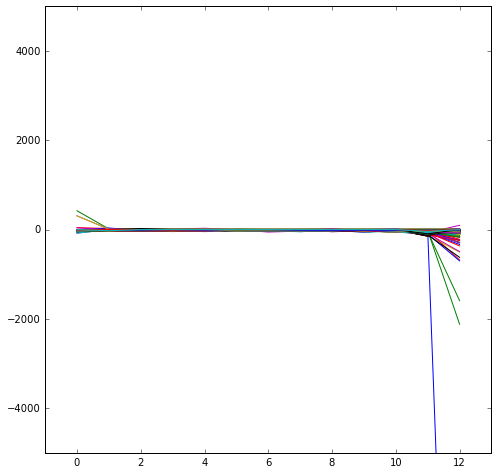

0
-15.0 [-38.99630387]
1
0.0 [-4.66667437]
2
-24.0 [-22.53642208]
3
0.0 [-15.00000001]
4
-6.0 [-21.29110629]
5
0.0 [-3.00000071]
6
-13.0 [-17.50003283]
7
-21.0 [-31.56213991]
8
-15.0 [-14.16667102]
9
0.0 [-2.33334558]
10
-44.0 [-19.61536434]
11
0.0 [-2.91671102]
12
0.0 [-5.83335573]
13
0.0 [-3.16667373]
14
0.0 [-0.9166926]
15
0.0 [-0.83333333]
16
0.0 [-7.25004128]
17
0.0 [-3.41667804]
18
0.0 [-2.91668385]
19
0.0 [-21.43434231]
20
-16.0 [-18.18866785]
21
0.0 [-5.41666667]
22
-25.0 [-16.18534916]
23
0.0 [-8.33337043]
24
-15.0 [-17.50000648]
25
-29.0 [-18.77010943]
26
0.0 [-10.08334258]
27
-24.0 [-19.18753781]
28
-18.0 [-15.83333333]
29
0.0 [-3.5]
30
0.0 [-12.25]
31
18.0 [-1.66668992]
32
0.0 [-2.833336]
33
0.0 [-3.83334255]
34
0.0 [-3.76134071]
35
-27.0 [-31.2626517]
36
0.0 [-11.66666667]
37
-6.0 [-8.90577614]
38
-101.0 [-13.0068743]
39
0.0 [-8.33337043]
40
-22.0 [-17.70809786]
41
0.0 [-0.58334639]
42
-50.0 [-4.16669419]
43
0.0 [-1.66667242]
44
0.0 [-8.66675126]
45
-163.0 [-1.58334385]
46

367
0.0 [-4.66668856]
368
0.0 [-8.75006151]
369
-37.0 [-26.8358718]
370
0.0 [-2.16667039]
371
0.0 [-3.33335054]
372
0.0 [-4.75001367]
373
-62.0 [-11.50000022]
374
-36.0 [-15.29523834]
375
0.0 [-14.5]
376
0.0 [-6.16668903]
377
0.0 [-3.58333394]
378
0.0 [-18.31827327]
379
-15.0 [-12.11165038]
380
0.0 [-1.00003424]
381
0.0 [-3.58334354]
382
-42.0 [-12.679955]
383
-15.0 [-13.20809634]
384
0.0 [-1.58334385]
385
0.0 [-3.25002643]
386
-106.0 [-102.39430466]
387
-217.0 [-1.00003424]
388
0.0 [-6.66666667]
389
0.0 [-12.]
390
0.0 [-5.16666667]
391
0.0 [-10.50000394]
392
-23.0 [-5.41667944]
393
0.0 [-7.75]
394
0.0 [-3.08334143]
395
0.0 [-1.75003402]
396
0.0 [-2.43875425]
397
0.0 [-1.66674847]
398
0.0 [-2.91668629]
399
-39.0 [-23.8977067]
400
-24.0 [-19.14651458]
401
0.0 [-5.00002414]
402
0.0 [-3.33333353]
403
-23.0 [-17.31395086]
404
0.0 [-1.66674847]
405
0.0 [-4.16669419]
406
0.0 [-5.75002449]
407
0.0 [-19.91774863]
408
0.0 [-5.41667012]
409
0.0 [-6.00041267]
410
-30.0 [-24.59152346]
411
0.0 [-1.

728
0.0 [-8.41666667]
729
-8.0 [-4.00000011]
730
-19.0 [-19.]
731
0.0 [-12.4104018]
732
0.0 [-123.39981412]
733
0.0 [-2.58334279]
734
-30.0 [-35.75340903]
735
0.0 [-14.82660203]
736
-24.0 [-61.07476122]
737
-4.0 [-5.58333333]
738
0.0 [-13.87404169]
739
0.0 [-7.16670198]
740
-16.0 [-14.08814926]
741
-26.0 [-16.13846843]
742
-15.0 [-14.25]
743
-17.0 [-17.]
744
-24.0 [-20.55021199]
745
-22.0 [-14.16465091]
746
-31.0 [-4.75016959]
747
0.0 [-7.44796021]
748
0.0 [-4.00026102]
749
-30.0 [-13.58333334]
750
0.0 [-1.08335082]
751
-90.0 [-4.33333518]
752
-87.0 [-27.5]
753
-23.0 [-20.2519182]
754
-16.0 [-9.94334691]
755
0.0 [-11.91681166]
756
0.0 [-8.66675126]
757
0.0 [-1.25000662]
758
0.0 [-26.17593192]
759
0.0 [-0.83335334]
760
0.0 [-11.58333333]
761
20.0 [-1.83334157]
762
-8.0 [-22.78977194]
763
0.0 [-2.58335959]
764
0.0 [-12.58333333]
765
0.0 [-17.86823844]
766
-21.0 [-17.21418828]
767
0.0 [-5.41666667]
768
-7.0 [-85.13153097]
769
0.0 [-2.50000648]
770
-22.0 [-11.5]
771
0.0 [-2.41667365]
772
0

1086
0.0 [-7.00054462]
1087
-31.0 [-14.08333333]
1088
0.0 [-1.58334385]
1089
0.0 [-11.41666667]
1090
-9.0 [-0.75000421]
1091
-20.0 [-13.33333333]
1092
-20.0 [-12.84853819]
1093
-32.0 [-22.27107011]
1094
0.0 [-2.50000648]
1095
0.0 [-72.48380512]
1096
-10.0 [-16.36076723]
1097
0.0 [-2.25016197]
1098
0.0 [-1.83336953]
1099
-20.0 [-4.166673]
1100
0.0 [-1.58334385]
1101
0.0 [-9.16666667]
1102
-34.0 [-25.82610514]
1103
-15.0 [-12.16666667]
1104
-29.0 [-21.34050346]
1105
-19.0 [-4.8333398]
1106
-31.0 [-17.25046333]
1107
-22.0 [-21.27029027]
1108
0.0 [-4.08341081]
1109
0.0 [-2.16685738]
1110
0.0 [-5.41667944]
1111
-97.0 [-11.52851319]
1112
0.0 [-7.91672186]
1113
0.0 [-10.41666667]
1114
-12.0 [-45.98898165]
1115
0.0 [-6.66669435]
1116
0.0 [-4.66666667]
1117
0.0 [-1.91666667]
1118
0.0 [-4.16669419]
1119
0.0 [-10.33333351]
1120
0.0 [-9.3333756]
1121
0.0 [-1.00003424]
1122
-11.0 [-1.50002358]
1123
-70.0 [-3.33335054]
1124
-9.0 [-15.04273551]
1125
-6.0 [-14.16666667]
1126
-25.0 [-16.36645797]
1127


1432
-28.0 [-12.43916531]
1433
0.0 [-11.08333431]
1434
0.0 [-6.50002984]
1435
0.0 [-2.66667489]
1436
0.0 [-7.00024519]
1437
0.0 [-4.33333638]
1438
0.0 [-1.66674847]
1439
0.0 [-9.66669374]
1440
-23.0 [-21.09713895]
1441
-20.0 [-16.9541385]
1442
0.0 [-1.25000662]
1443
-1592.0 [-4.16666667]
1444
-24.0 [-17.14123469]
1445
0.0 [-2.33334367]
1446
0.0 [-1.00003424]
1447
0.0 [-9.16684419]
1448
-6.0 [-11.65442629]
1449
0.0 [-4.50001366]
1450
0.0 [-16.8815619]
1451
-24.0 [-1.75003402]
1452
0.0 [-2.41671713]
1453
-14.0 [-13.03916602]
1454
-24.0 [-21.31478661]
1455
0.0 [-11.]
1456
-25.0 [-16.5468531]
1457
-17.0 [-16.33333283]
1458
0.0 [-16.72878296]
1459
-24.0 [-19.58333333]
1460
-49.0 [-1.58334385]
1461
0.0 [-8.33337043]
1462
0.0 [-17.04889164]
1463
0.0 [-10.16668684]
1464
-15.0 [-13.7500006]
1465
0.0 [-13.63865298]
1466
0.0 [-4.00000236]
1467
-8.0 [-5.86560151]
1468
0.0 [-5.52228827]
1469
-621.0 [-10.00000817]
1470
0.0 [-1.25000662]
1471
0.0 [-6.41666801]
1472
-15.0 [-18.84023156]
1473
0.0 [-4.5

1778
-18.0 [-12.31038128]
1779
-42.0 [-9.7539919]
1780
-244.0 [-9.08341436]
1781
0.0 [-14.61290315]
1782
0.0 [-34.34162428]
1783
0.0 [-2.91666702]
1784
-53.0 [-21.16184616]
1785
-31.0 [-22.71092175]
1786
0.0 [-2.50000097]
1787
0.0 [-4.16669419]
1788
-9.0 [-13.83333324]
1789
0.0 [-3.33335054]
1790
0.0 [-7.50000588]
1791
-12.0 [-6.2500009]
1792
0.0 [-4.33336264]
1793
-12.0 [-1.00003424]
1794
-18.0 [-13.91666667]
1795
0.0 [-15.84095877]
1796
-297.0 [-4.66667403]
1797
0.0 [-2.50000648]
1798
0.0 [-0.66667343]
1799
0.0 [-9.16666667]
1800
-23.0 [-10.16666667]
1801
0.0 [-9.9166829]
1802
-39.0 [-7.91666728]
1803
0.0 [-1.50000283]
1804
0.0 [-6.91669828]
1805
0.0 [-3.91666739]
1806
-14.0 [-13.25672462]
1807
0.0 [-57.56835221]
1808
0.0 [-3.75002282]
1809
0.0 [-5.91669039]
1810
-83.0 [-18.93849675]
1811
-61.0 [-52.62271296]
1812
0.0 [-5.83335573]
1813
-1.0 [-12.11557663]
1814
0.0 [-9.75007593]
1815
0.0 [-2.41667365]
1816
0.0 [-3.50007525]
1817
0.0 [-2.91668385]
1818
-7.0 [-1.50002358]
1819
0.0 [ 0.

In [39]:
#Llegim les comptes del 25è cluster
accountcluster25=np.zeros((len(assignmentsclus[24]),13))
for i in np.arange(len(assignmentsclus[24])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster25[i]=accountclean[assignmentsclus[24][i].astype(int)]

print accountcluster25.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster25.shape[0]):
        plt.plot(accountcluster25[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 40.0**2 * RBF(length_scale=20.0)  # long term smooth rising trend
#k2 = 3.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k2= 3.0**2 * RBF(length_scale=1.2)  
k3 = 1.5**2* RationalQuadratic(length_scale=2.0, alpha=0.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=0.2**2)  # noise terms
kernel_gpmlini = k1+k2+k3+k4


gp25 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regression1(accountcluster25,accountcluster25.shape[0],gp25,24)

(5576, 13)


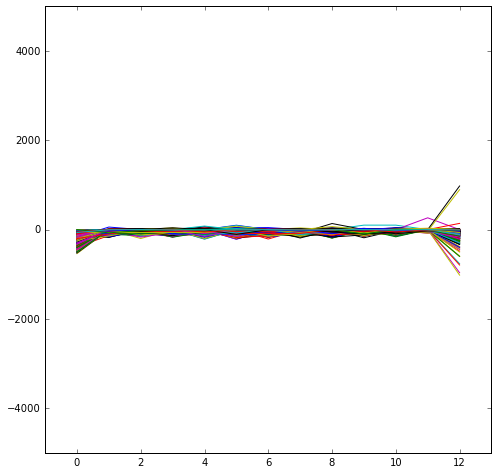

Iteracio: 35
-131.0 [-14.33869921]
[-52.65319083] [ 23.97579242]
[-89.43510279] [ 60.75770437]
70.313583325
Iteracio: 45
-125.0 [-4.37499989]
[-25.97772527] [ 17.22772549]
[-46.71634163] [ 37.96634186]
28.3901391332
Iteracio: 68
-594.0 [-17.24999238]
[-77.88001848] [ 43.38003372]
[-136.08484353] [ 101.58485878]
131.62066707
Iteracio: 69
-91.0 [-8.0428457]
[-25.03507915] [ 8.94938776]
[-41.34762327] [ 25.26193188]
47.6130234285
Iteracio: 73
-155.0 [-34.05774821]
[-51.06096558] [-17.05453084]
[-67.38405426] [-0.73144217]
65.4064217031
Iteracio: 105
-60.0 [-20.10265018]
[-35.13542769] [-5.06987268]
[-49.5668941] [ 9.36159373]
56.5154846038
Iteracio: 181
-51.0 [-4.12498944]
[-23.70781803] [ 15.45783915]
[-42.50733348] [ 34.2573546]
29.206163733
Iteracio: 231
-34.0 [-4.24999801]
[-18.97234929] [ 10.47235327]
[-33.10580651] [ 24.60581049]
27.4954541697
Iteracio: 244
0.0 [-35.87499998]
[-52.59066359] [-19.15933637]
[-68.63770065] [-3.1122993]
76.0328876211
Iteracio: 246
0.0 [-42.1472514]
[-60

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  2.24700715e-01,  -2.56937559e-01,   1.15059092e+00,
        -0.00000000e+00,  -2.85371375e-05,  -5.28882794e+02,
         4.29548522e-01,   9.58401114e-09,  -1.03538248e-04,
         3.04283544e-07,  -2.68422821e-09,   1.17407135e-07]), 'nit': 0, 'funcalls': 21}
  " state: %s" % convergence_dict)


Iteracio: 307
-57.0 [-8.625]
[-27.22447696] [ 9.97447696]
[-45.07997484] [ 27.82997484]
41.7372735094
Iteracio: 339
-72.0 [-29.16428833]
[-49.76826905] [-8.56030761]
[-69.54809054] [ 11.21951388]
47.0425339454


/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  3.39249277e+00,  -0.00000000e+00,   3.12864009e-09,
        -0.00000000e+00,  -2.55415375e-13,  -1.04887728e+03,
         4.43363580e-01,   1.04846895e-03,  -5.89825838e-05,
         1.57437766e-01,  -0.00000000e+00,   1.43160632e-05]), 'nit': 1, 'funcalls': 42}
  " state: %s" % convergence_dict)


Iteracio: 393
-85.0 [-23.16367332]
[-50.87567365] [ 4.54832701]
[-77.47919396] [ 31.15184733]
71.2671032104
Iteracio: 396
-47.0 [ 0.]
[-21.21237826] [ 21.21237826]
[-41.5762614] [ 41.5762614]
57.5152153782
Iteracio: 400
0.0 [-61.64314092]
[-83.87273419] [-39.41354764]
[-105.21314373] [-18.0731381]
76.2561472932
Iteracio: 447
-44.0 [-5.5]
[-24.99198688] [ 13.99198688]
[-43.70429429] [ 32.70429429]
54.295487842
Iteracio: 475
-110.0 [-8.74993784]
[-50.7135044] [ 33.21362872]
[-90.99852829] [ 73.49865261]
88.3855191759
Iteracio: 512
-276.0 [-12.58850049]
[-48.89536343] [ 23.71836245]
[-83.74995185] [ 58.57295087]
59.9916660879


/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  9.15578063e-01,  -0.00000000e+00,   9.15578063e-01,
        -0.00000000e+00,  -5.04068551e-14,  -2.07017911e+02,
         3.33614949e-01,   2.06901221e-04,  -1.16392623e-05,
         9.15578063e-01,  -0.00000000e+00,   9.15578063e-01]), 'nit': 1, 'funcalls': 42}
  " state: %s" % convergence_dict)


Iteracio: 535
-44.0 [ 0.]
[-19.51243963] [ 19.51243963]
[-38.24438168] [ 38.24438168]
56.0624651616
Iteracio: 543
-104.0 [-20.375]
[-62.56793002] [ 21.81793002]
[-103.07314284] [ 62.32314284]
87.0344759276
Iteracio: 595
-183.0 [-8.75000001]
[-55.63750558] [ 38.13750557]
[-100.64951093] [ 83.14951092]
106.26382263
Iteracio: 611
-61.0 [-2.37499984]
[-25.73641982] [ 20.98642014]
[-48.16338301] [ 43.41338333]
43.1045241245
Iteracio: 672
-389.0 [ 0.]
[-23.43010777] [ 23.43010777]
[-45.92301123] [ 45.92301123]
20.6397674406
Iteracio: 697
-127.0 [-4.84567388]
[-25.06948381] [ 15.37813604]
[-44.48434133] [ 34.79299357]
23.5372045919
Iteracio: 731
-260.0 [ 0.]
[-33.07190511] [ 33.07190511]
[-64.82093401] [ 64.82093401]
77.2787163454
Iteracio: 743
0.0 [-53.87359547]
[-72.27615414] [-35.4710368]
[-89.94261046] [-17.80458047]
60.1498129673
Iteracio: 774
-92.0 [-19.74999112]
[-43.63634845] [ 4.1363662]
[-66.56725148] [ 27.06726924]
52.4309069157
Iteracio: 825
-32.0 [-7.25]
[-19.82446379] [ 5.324463

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -2.04525625e-05,   4.31862726e-05,   3.54732745e-04,
         1.84578918e-04,  -2.18481577e+01,  -6.08357373e+06,
        -6.13625526e+01,   2.38153345e-01,   1.82120334e+02,
         4.75228558e-01,   1.91922712e-04,  -2.93655360e-02]), 'nit': 2, 'funcalls': 62}
  " state: %s" % convergence_dict)


Iteracio: 1155
-78.0 [-7.51064091]
[-41.24095968] [ 26.21967785]
[-73.6220657] [ 58.60078387]
54.1479454827
Iteracio: 1156
-47.0 [-5.49998249]
[-24.55257134] [ 13.55260636]
[-42.84305663] [ 31.84309165]
19.8997487421
Iteracio: 1189
-115.0 [-15.12498807]
[-44.72326921] [ 14.47329307]
[-73.1376191] [ 42.88764296]
60.2162768693


/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  7.42724163e-02,  -1.46986146e-01,   1.34082055e-02,
        -2.52788447e-02,  -1.22752763e-17,  -4.91979517e-02,
         6.20026703e-02,   3.84845188e-11,  -1.29092224e-04,
         6.74622142e-01,  -9.00186415e-01,   2.73843087e+00]), 'nit': 4, 'funcalls': 46}
  " state: %s" % convergence_dict)


Iteracio: 1201
-198.0 [-10.125]
[-37.87726132] [ 17.62726132]
[-64.51943218] [ 44.26943218]
65.7267069006
Iteracio: 1203
-104.0 [-8.4366739]
[-29.80196804] [ 12.92862025]
[-50.31265042] [ 33.43930263]
38.3275357935
Iteracio: 1233
0.0 [-72.62499245]
[-98.93426392] [-46.31572097]
[-124.19116453] [-21.05882036]
100.473877202
Iteracio: 1238
-80.0 [-6.46128016]
[-38.24738717] [ 25.32482685]
[-68.7620499] [ 55.83948958]
48.774993593
Iteracio: 1257
-131.0 [-5.26359367]
[-42.9926994] [ 32.46551207]
[-79.2126409] [ 68.68545357]
76.8049477573
Iteracio: 1275
0.0 [-70.]
[-93.15047347] [-46.84952653]
[-115.37492801] [-24.62507199]
99.1060038545
Iteracio: 1279
-90.0 [-7.49999972]
[-47.51191353] [ 32.51191408]
[-85.92335078] [ 70.92335134]
80.3865660418
Iteracio: 1292
-116.0 [-22.99087827]
[-49.67388941] [ 3.69213286]
[-75.2895801] [ 29.30782355]
75.9802605944
Iteracio: 1297
-87.0 [-11.09674815]
[-36.74820659] [ 14.55471029]
[-61.3736067] [ 39.1801104]
42.7901857907
Iteracio: 1376
-78.0 [-10.75433517

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.91635484e-01,   6.56816924e-10,   2.58370771e-03,
         5.35884330e-09,  -3.72177044e-04,  -2.70337230e+02,
         7.62624469e-07,  -8.86261152e-08,  -6.63187518e-08,
         2.46811260e-03,   4.28775126e-11,   6.18212779e-01]), 'nit': 0, 'funcalls': 21}
  " state: %s" % convergence_dict)


26.3058928759
Iteracio: 1493
-793.0 [-21.30607249]
[-57.61307243] [ 15.00092745]
[-92.46779238] [ 49.8556474]
75.2529069206
Iteracio: 1504
-121.0 [-12.375]
[-54.38913506] [ 29.63913506]
[-94.72270471] [ 69.97270471]
80.099937578
Iteracio: 1506
-184.0 [-15.2499966]
[-58.51354431] [ 28.01355111]
[-100.04655012] [ 69.54655691]
94.297401873
Iteracio: 1513
-48.0 [-15.62499999]
[-31.5265719] [ 0.27657191]
[-46.79208093] [ 15.54208094]
51.1859355683
Iteracio: 1530
-100.0 [-17.87723108]
[-46.4450586] [ 10.69059644]
[-73.87017302] [ 38.11571086]
55.1633936592
Iteracio: 1541
0.0 [-62.62499462]
[-93.16884834] [-32.0811409]
[-122.49094791] [-2.75904132]
93.423765713
Iteracio: 1544
-100.0 [ 0.]
[-16.96700333] [ 16.96700333]
[-33.25532653] [ 33.25532653]
33.6452076825
Iteracio: 1564
-162.0 [-9.99999347]
[-55.40463959] [ 35.40465265]
[-98.99309986] [ 78.99311293]
80.249610591
Iteracio: 1585
-72.0 [-13.8280289]
[-41.43692481] [ 13.780867]
[-67.94146488] [ 40.28540707]
66.9402718847
Iteracio: 1587
-377

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.11405649e-05,  -0.00000000e+00,  -4.99865477e+00,
        -0.00000000e+00,  -7.00097954e-01,  -1.25495123e+06,
        -3.13359337e-06,  -3.25105151e-06,   2.48221698e-07,
         4.99195212e-01,   1.54153853e-03,  -5.38150016e-01]), 'nit': 1, 'funcalls': 38}
  " state: %s" % convergence_dict)


Iteracio: 2009
-95.0 [-36.62499927]
[-49.93794356] [-23.31205498]
[-62.71837008] [-10.53162847]
60.0583050044
Iteracio: 2020
-55.0 [-15.12499982]
[-32.94176884] [ 2.69176921]
[-50.04586711] [ 19.79586747]
53.516352641
Iteracio: 2029
-93.0 [-25.81636822]
[-46.4339216] [-5.19881484]
[-66.22677285] [ 14.5940364]
47.2546294028
Iteracio: 2044
-188.0 [-18.03680789]
[-60.96364702] [ 24.89003123]
[-102.17341257] [ 66.09979679]
94.8103369892
Iteracio: 2049
0.0 [-55.86544208]
[-78.34610134] [-33.38478282]
[-99.92753423] [-11.80334993]
79.0063288604
Iteracio: 2063
-70.0 [-5.62492873]
[-31.2704685] [ 20.02061103]
[-55.89018667] [ 44.6403292]
26.5894716006
Iteracio: 2104
-114.0 [-36.36977768]
[-52.27561777] [-20.46393759]
[-67.54522426] [-5.19433111]
52.0960651105
Iteracio: 2108
-43.0 [-3.37498638]
[-19.69551536] [ 12.94554261]
[-35.36322319] [ 28.61325043]
29.478805946
Iteracio: 2134
-77.0 [-4.74999042]
[-26.01620019] [ 16.51621935]
[-46.43176157] [ 36.93178073]
20.8806130178
Iteracio: 2142
-40.0 

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  4.74222797e-02,   1.14380574e-06,   5.30250675e-07,
         4.30516655e-16,  -6.28344885e-04,  -1.11354557e+04,
         1.08485545e-01,  -1.56471929e-02,   1.20083656e-03,
         4.00995366e-05,   8.21064544e-11,   1.75198240e+00]), 'nit': 9, 'funcalls': 66}
  " state: %s" % convergence_dict)


Iteracio: 2383
-231.0 [-22.98851382]
[-72.28848946] [ 26.31146182]
[-119.61646607] [ 73.63943843]
114.664728666
Iteracio: 2390
-48.0 [-14.125]
[-29.26394306] [ 1.01394306]
[-43.7973284] [ 15.5473284]
44.6654228683
Iteracio: 2428
-62.0 [-8.9390077]
[-24.58948019] [ 6.71146479]
[-39.61393378] [ 21.73591839]
29.4448637287
Iteracio: 2434
-81.0 [-33.44081345]
[-49.35153715] [-17.53008975]
[-64.6258319] [-2.255795]
56.0089278598
Iteracio: 2456
0.0 [-61.25]
[-82.19373317] [-40.30626683]
[-102.29971701] [-20.20028299]
73.2120208709
Iteracio: 2494
-60.0 [-20.24999637]
[-38.15380402] [-2.34618872]
[-55.34145936] [ 14.84146662]
77.9294552785
Iteracio: 2498
-71.0 [-10.71246832]
[-40.76661429] [ 19.34167764]
[-69.61859441] [ 48.19365777]
62.6578007913
Iteracio: 2502
-250.0 [-7.49999973]
[-43.55550376] [ 28.55550431]
[-78.16878763] [ 63.16878818]
58.7537232863


/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.24482049e-02,  -3.68461310e-07,   8.35675132e-02,
        -4.87171554e-08,  -8.26243426e-05,  -5.75490108e+03,
        -1.84703763e+00,  -5.63493271e-01,   4.83229120e-02,
         4.16663374e-07,  -4.91995400e-09,  -3.14911869e-02]), 'nit': 0, 'funcalls': 21}
  " state: %s" % convergence_dict)


Iteracio: 2536
-482.0 [-26.18531086]
[-65.29730604] [ 12.92668432]
[-102.84482141] [ 50.47419969]
88.2836338174
Iteracio: 2539
-24.0 [-36.65903656]
[-39.49063855] [-33.82743456]
[-42.20897647] [-31.10909664]
80.3492377064
Iteracio: 2556
-233.0 [ 0.]
[-68.12814333] [ 68.12814333]
[-133.53116093] [ 133.53116093]
169.905856285
Iteracio: 2582
-120.0 [-14.99999982]
[-66.961525] [ 36.96152537]
[-116.84458918] [ 86.84458954]
103.595366692


/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  3.90175973e-09,  -4.30063622e-11,   7.67746279e-07,
        -5.22468536e-11,  -2.21059283e-13,  -8.65565108e+02,
         4.45502550e-01,   9.10931180e-04,  -5.14650281e-05,
         5.21780426e-07,  -4.75410034e-09,   3.01875396e+00]), 'nit': 1, 'funcalls': 42}
  " state: %s" % convergence_dict)


Iteracio: 2590
-34.0 [-4.24999801]
[-18.9724323] [ 10.47243628]
[-33.10596923] [ 24.60597321]
27.4954541697
Iteracio: 2596
-102.0 [-33.25000951]
[-60.14071717] [-6.35930185]
[-85.95579652] [ 19.45577751]
84.5044377533
Iteracio: 2606
-399.0 [-9.99999756]
[-54.44091983] [ 34.44092471]
[-97.10420521] [ 77.10421009]
82.5348411279
Iteracio: 2632
-177.0 [-12.12499623]
[-39.93125206] [ 15.6812596]
[-66.62525766] [ 42.3752652]
59.8080262172
Iteracio: 2646
0.0 [-33.3749793]
[-47.15022699] [-19.5997316]
[-60.37446478] [-6.37549381]
52.2589705218
Iteracio: 2674
0.0 [-52.98207718]
[-79.48753617] [-26.47661819]
[-104.93277679] [-1.03137757]
92.043467992
Iteracio: 2682
-81.0 [-20.90762686]
[-44.19069294] [ 2.37543923]
[-66.54243638] [ 24.72718267]
64.8228354826
Iteracio: 2685
-104.0 [-8.13002202]
[-35.52413814] [ 19.26409411]
[-61.82248963] [ 45.5624456]
44.8330235429
Iteracio: 2733
-85.0 [-14.27300667]
[-44.19793997] [ 15.65192663]
[-72.92587594] [ 44.3798626]
64.3117407633
Iteracio: 2786
-149.0 [-

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  8.40244192e-01,  -2.17164536e-04,   1.18524987e-01,
        -5.14947748e-06,  -1.96378748e+00,  -2.39136157e+06,
         8.40253959e-01,  -0.00000000e+00,  -0.00000000e+00,
         2.67492527e-01,  -1.13001958e-03,   8.40253959e-01]), 'nit': 4, 'funcalls': 46}
  " state: %s" % convergence_dict)


Iteracio: 2929
-175.0 [-29.99999956]
[-61.99127931] [ 1.99128018]
[-92.70290786] [ 32.70290874]
91.7877987534
Iteracio: 2956
-122.0 [-22.875]
[-64.35072652] [ 18.60072652]
[-104.16742397] [ 58.41742398]
103.508453761
Iteracio: 2983
-82.0 [-8.84774093]
[-45.11314707] [ 27.41766521]
[-79.92793697] [ 62.23245511]
56.6303805391
Iteracio: 2990
-132.0 [-17.25876729]
[-65.11446776] [ 30.59693319]
[-111.05594021] [ 76.53840564]
108.646214844
Iteracio: 2991
-83.0 [-30.62502492]
[-47.90759866] [-13.34245118]
[-64.49886945] [ 3.24881961]
63.1030902571
Iteracio: 3018
-197.0 [-2.95232504]
[-21.32988088] [ 15.42523081]
[-38.97233449] [ 33.06768442]
32.6802692767
Iteracio: 3044
-83.0 [-14.88076275]
[-36.08213105] [ 6.32060556]
[-56.43544463] [ 26.67391914]
44.6766158074
Iteracio: 3046
-199.0 [-0.62499972]
[-38.32696759] [ 37.07696814]
[-74.52085674] [ 73.2708573]
84.0416563378
Iteracio: 3057
-50.0 [-5.37498249]
[-24.21271013] [ 13.46274515]
[-42.29692866] [ 31.54696368]
20.2731349327
Iteracio: 3075
-

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  9.15401826e-01,  -0.00000000e+00,   9.15401826e-01,
        -0.00000000e+00,  -5.05884002e-14,  -2.07736660e+02,
         3.33614923e-01,   2.06876946e-04,  -1.16357381e-05,
         9.15401826e-01,  -0.00000000e+00,   9.15401826e-01]), 'nit': 1, 'funcalls': 42}
  " state: %s" % convergence_dict)


Iteracio: 3846
-85.0 [-17.625]
[-43.27454816] [ 8.02454816]
[-67.89811439] [ 32.64811439]
70.8519583357
Iteracio: 3853
-37.0 [-18.10886831]
[-27.46736127] [-8.75037536]
[-36.45151451] [ 0.23377788]
55.2539591342
Iteracio: 3860
0.0 [-44.75]
[-59.93018052] [-29.56981948]
[-74.50315382] [-14.99684618]
59.640590205


/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.31489162e-08,   1.79659611e-17,   1.68866085e+00,
        -2.21126935e+00,  -5.35243920e-12,  -8.00705166e+03,
         1.78492312e-08,  -0.00000000e+00,  -0.00000000e+00,
         1.52283082e-04,  -1.97502348e-04,   4.12384674e-06]), 'nit': 0, 'funcalls': 21}
  " state: %s" % convergence_dict)


Iteracio: 3900
-94.0 [-34.24992686]
[-59.12682617] [-9.37302755]
[-83.00864951] [ 14.50879579]
70.2353187506
Iteracio: 3910
-82.0 [-10.25]
[-45.75704246] [ 25.25704246]
[-79.84380322] [ 59.34380322]
68.5638388657
Iteracio: 3940
-79.0 [-6.80716494]
[-35.15788771] [ 21.54355783]
[-62.37458156] [ 48.76025169]
69.3541635376
Iteracio: 3949
0.0 [-41.74998756]
[-59.1663258] [-24.33364932]
[-75.88601052] [-7.6139646]
62.6178888178
Iteracio: 4031
-94.0 [-19.46191143]
[-54.5840143] [ 15.66019144]
[-88.30123305] [ 49.3774102]
75.8683069536
Iteracio: 4038
0.0 [-53.01930732]
[-76.18761296] [-29.85100168]
[-98.42918638] [-7.60942826]
66.7982035687
Iteracio: 4049
0.0 [-61.99353921]
[-86.76336815] [-37.22371027]
[-110.54240393] [-13.44467449]
81.2403840464
Iteracio: 4051
-78.0 [-31.42608887]
[-49.41045993] [-13.4417178]
[-66.67545615] [ 3.82327842]
61.8789140176
Iteracio: 4076
139.0 [-10.63256026]
[-81.34323908] [ 60.07811856]
[-149.22549075] [ 127.96037023]
170.801053861
Iteracio: 4099
-100.0 [-14.49

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.08935711e-07,  -5.24012622e-15,   1.78796661e+00,
        -0.00000000e+00,  -1.20662154e-13,  -4.95775683e+02,
         3.99991656e-01,  -4.97056690e-15,  -1.35894352e-08,
         6.33268561e-06,  -3.08129206e-09,   1.78796661e+00]), 'nit': 1, 'funcalls': 42}
  " state: %s" % convergence_dict)


Iteracio: 4144
-124.0 [-25.12105784]
[-59.60721206] [ 9.36509637]
[-92.71392011] [ 42.47180442]
78.9746794865
Iteracio: 4145
-252.0 [ 0.]
[-42.0013357] [ 42.0013357]
[-82.32261798] [ 82.32261798]
98.3412426198
Iteracio: 4152
-244.0 [-13.3267137]
[-52.39696954] [ 25.74354214]
[-89.90441514] [ 63.25098774]
91.8477000256
Iteracio: 4258
0.0 [-59.93248066]
[-83.58389186] [-36.28106947]
[-106.2892466] [-13.57571473]
82.5408989532
Iteracio: 4262
-160.0 [-18.24999953]
[-61.71541382] [ 25.21541475]
[-103.44221154] [ 66.94221247]
101.464279429
Iteracio: 4270
0.0 [-71.00997072]
[-91.32773634] [-50.6922051]
[-110.83279134] [-31.1871501]
104.79503805
Iteracio: 4298
-107.0 [-10.57280383]
[-47.54219133] [ 26.39658367]
[-83.03280333] [ 61.88719568]
78.1280999385
Iteracio: 4304
-60.0 [-22.4999999]
[-36.64214402] [-8.35785577]
[-50.21860238] [ 5.21860259]
69.1881492743
Iteracio: 4309
-110.0 [-34.39015558]
[-64.85214175] [-3.92816942]
[-94.09564847] [ 25.3153373]
79.353638858
Iteracio: 4322
-121.0 [-30.1

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.19024135e-08,  -0.00000000e+00,   1.79067655e+00,
        -0.00000000e+00,  -1.20639423e-13,  -4.95996768e+02,
         4.00607400e-01,   4.94250288e-04,  -2.78013830e-05,
         6.20110275e-11,  -1.26855782e-14,   1.79067655e+00]), 'nit': 1, 'funcalls': 42}
  " state: %s" % convergence_dict)


Iteracio: 4606
-301.0 [-23.49999056]
[-63.12330323] [ 16.12332211]
[-101.16168339] [ 54.16170228]
101.788997441
Iteracio: 4608
-67.0 [-14.40191524]
[-41.19716286] [ 12.39333239]
[-66.92060058] [ 38.1167701]
55.0726792521
Iteracio: 4616
0.0 [-67.99992044]
[-90.67467882] [-45.32516206]
[-112.44244686] [-23.55739401]
82.2192191644
Iteracio: 4631
-214.0 [-6.62498539]
[-32.17398496] [ 18.92401419]
[-56.70102455] [ 43.45105378]
46.4758001545
Iteracio: 4652
-116.0 [ 0.]
[-39.81528846] [ 39.81528846]
[-78.03796538] [ 78.03796538]
69.0362223764
Iteracio: 4661
-70.0 [-5.9349912]
[-35.09213138] [ 23.22214898]
[-63.08298596] [ 51.21300355]
43.0464865001
Iteracio: 4702
-1020.0 [-7.95798374]
[-54.49816687] [ 38.58219938]
[-99.17674267] [ 83.26077518]
94.8156105291
Iteracio: 4703
0.0 [-60.24993061]
[-81.50881098] [-38.99105023]
[-101.91733613] [-18.58252508]
71.6937933157
Iteracio: 4738
-320.0 [-13.94355568]
[-59.75227199] [ 31.86516062]
[-103.72863964] [ 75.84152827]
91.2852671574
Iteracio: 4805
-96

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  2.10528383e-01,  -5.43777649e-06,   1.14596421e+00,
        -0.00000000e+00,  -8.08418807e-14,  -3.28396423e+02,
         1.14596421e+00,  -0.00000000e+00,  -0.00000000e+00,
         2.10525666e-01,  -3.54856792e-09,   1.14596421e+00]), 'nit': 1, 'funcalls': 42}
  " state: %s" % convergence_dict)


Iteracio: 5085
0.0 [-31.5673383]
[-47.15578984] [-15.97888676]
[-62.12070332] [-1.01397327]
47.9478883789
Iteracio: 5091
-110.0 [-27.35030434]
[-64.63656005] [ 9.93595137]
[-100.43136553] [ 45.73075685]
90.0777441991
Iteracio: 5094
-128.0 [-13.73157379]
[-39.42902462] [ 11.96587704]
[-64.09857742] [ 36.63542984]
62.6976873577
Iteracio: 5112
-140.0 [-19.96665383]
[-58.83742795] [ 18.90412029]
[-96.15337111] [ 56.22006344]
93.3380951166
Iteracio: 5117
-139.0 [-21.46703152]
[-60.00411905] [ 17.07005601]
[-96.99972308] [ 54.06566005]
96.30160954
Iteracio: 5126
-143.0 [-2.42116072]
[-19.58034285] [ 14.73802141]
[-36.05315769] [ 31.21083625]
39.2555728528
Iteracio: 5178
-56.0 [-5.49998809]
[-21.09647092] [ 10.09649474]
[-36.06909444] [ 25.06911826]
26.8886593195
Iteracio: 5238
-126.0 [-4.00003331]
[-31.59277467] [ 23.59270805]
[-58.08180638] [ 50.08173976]
54.0925133452
Iteracio: 5255
-503.0 [-6.5319227]
[-28.61644962] [ 15.55260422]
[-49.81759546] [ 36.75375006]
19.5448202857
Iteracio: 5266

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -6.78425036e-04,  -0.00000000e+00,   2.39562612e-03,
         2.42332874e-10,  -1.35429116e-05,  -1.61672215e+01,
         2.89872994e-03,  -1.05279197e-06,   5.80081166e-08,
        -1.10574241e-03,   2.22577959e-70,  -4.96863493e-04]), 'nit': 12, 'funcalls': 64}
  " state: %s" % convergence_dict)


Iteracio: 5512
-111.0 [-11.5]
[-30.91004669] [ 7.91004669]
[-49.54369151] [ 26.54369151]
20.8806130178
Iteracio: 5520
-103.0 [-37.87500001]
[-65.78446316] [-9.96553686]
[-92.57754778] [ 16.82754776]
63.6160357143
Iteracio: 5528
-70.0 [-4.62499924]
[-20.64647818] [ 11.3964797]
[-36.02709796] [ 26.77709949]
24.6170672502
Iteracio: 5531
-146.0 [-25.87498781]
[-63.55020585] [ 11.80023022]
[-99.71841517] [ 47.96843954]
87.5556965594
Iteracio: 5560
-26.0 [-39.]
[-43.3004988] [-34.6995012]
[-47.42897764] [-30.57102236]
82.091412462
Iteracio: 5561
-107.0 [-8.49998907]
[-49.29808403] [ 32.29810589]
[-88.46425519] [ 71.46427705]
84.4926032266


/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  3.65463165e-03,  -1.29066641e-02,   2.57296350e-02,
        -1.39394077e-02,  -1.17509931e+00,  -8.72007447e+07,
         2.31759669e-01,  -1.24609428e-07,  -5.80924131e-02,
         1.46721426e+00,  -0.00000000e+00,   1.46721426e+00]), 'nit': 39, 'funcalls': 111}
  " state: %s" % convergence_dict)


La predicció de compte en negatiu en predicció i real correctes és de: 0.474533715925
La predicció de compte en negatiu en predicció i real o 0 correctes és de: 0.990674318508
La predicció de compte esta compresa en la zona determinada: 0.846843615495
La predicció de compte ens permet assegurar el signe final: 0.948170731707
Comptes signe 0.954985652798
The Mean Absolute Scaled error is [ 0.52006289]
The MAE error is [ 17.82967429]
The RMSE is [ 48.12547809]


array([ 0.52006289])

In [21]:
#Llegim les comptes del 26è cluster
accountcluster26=np.zeros((len(assignmentsclus[25]),13))
for i in np.arange(len(assignmentsclus[25])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster26[i]=accountclean[assignmentsclus[25][i].astype(int)]

print accountcluster26.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster26.shape[0]):
        plt.plot(accountcluster26[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 54.0**2 * RBF(length_scale=18.0)  # long term smooth rising trend
k2 = 3.0**2 * RBF(length_scale=1.1) + ExpSineSquared(length_scale=2.0, periodicity=3.0)  # seasonal component
# medium term irregularity
k3 = 1.5**2* RationalQuadratic(length_scale=2.0, alpha=0.9)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=34.2**2)  # noise terms
kernel_gpmlini = k1+k2+k3+k4


gp26 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster26,accountcluster26.shape[0],gp26,25)

(4902, 13)


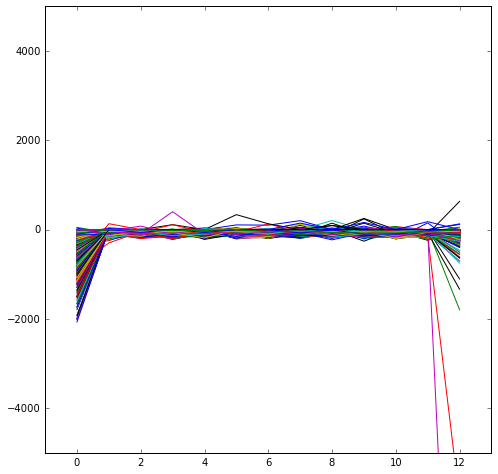

Iteracio: 1
0.0 [-98.1161375]
[-142.60620147] [-53.62607353]
[-185.31666289] [-10.91561212]
146.65946952
Iteracio: 19
-190.0 [-76.16868395]
[-120.27013666] [-32.06723124]
[-162.60753126] [ 10.27016336]
121.720992438
Iteracio: 35
0.0 [-54.96126456]
[-78.61144676] [-31.31108236]
[-101.31562167] [-8.60690744]
67.4240313242
Iteracio: 42
-157.0 [-26.375]
[-60.67683987] [ 7.92683987]
[-93.60660615] [ 40.85660615]
92.7739187488
Iteracio: 45
-463.0 [-48.62500158]
[-105.62925748] [ 8.37925432]
[-160.35334315] [ 63.10333998]
143.888845989
Iteracio: 57
-637.0 [-51.75]
[-86.3763728] [-17.1236272]
[-119.61769068] [ 16.11769068]
72.5189630373
Iteracio: 88
-127.0 [-48.2723051]
[-88.29979301] [-8.24481718]
[-126.7261814] [ 30.18157121]
88.9438024822
Iteracio: 115
-27.0 [-96.03398776]
[-124.82573288] [-67.24224264]
[-152.4658082] [-39.60216733]
87.6356092008
Iteracio: 137
-85.0 [-69.12499035]
[-75.20775449] [-63.04222622]
[-81.04720805] [-57.20277266]
150.319659393
Iteracio: 163
-297.0 [-49.]
[-49.6614

Iteracio: 1392
-60.0 [-33.74999983]
[-46.25720816] [-21.2427915]
[-58.26412815] [-9.23587151]
88.9325587173
Iteracio: 1403
-170.0 [-52.5]
[-104.42045768] [-0.57954232]
[-154.26409704] [ 49.26409704]
137.124031446
Iteracio: 1405
-220.0 [-15.62499991]
[-50.27689474] [ 19.02689493]
[-83.54271378] [ 52.29271397]
90.5924941703
Iteracio: 1441
-208.0 [-97.48275187]
[-115.06104079] [-79.90446295]
[-131.93619815] [-63.02930559]
133.585178819
Iteracio: 1445
0.0 [-90.5]
[-134.83377018] [-46.16622982]
[-177.39418956] [-3.60581044]
147.237902729
Iteracio: 1510
-347.0 [-68.37503932]
[-115.87660064] [-20.87347801]
[-161.4780995] [ 24.72802085]
114.926063188
Iteracio: 1523
-72.0 [-11.62500045]
[-39.71832824] [ 16.46832735]
[-66.68792292] [ 43.43792203]
25.8263431403
Iteracio: 1524
-167.0 [-44.5]
[-95.73658071] [ 6.73658071]
[-144.92369819] [ 55.92369819]
105.569882069
Iteracio: 1535
-49.0 [-156.85142686]
[-204.55179574] [-109.15105798]
[-250.34414986] [-63.35870386]
138.675881104
Iteracio: 1557
-161.0

Iteracio: 2381
-215.0 [-44.]
[-104.268301] [ 16.268301]
[-162.12586995] [ 74.12586995]
170.689777081
Iteracio: 2385
-191.0 [-73.92137644]
[-121.56205] [-26.28070287]
[-167.29709663] [ 19.45434375]
131.483839311
Iteracio: 2389
-73.0 [-16.24992301]
[-43.1749079] [ 10.67506188]
[-69.02289339] [ 36.52304738]
87.4013729869
Iteracio: 2403
-126.0 [-53.625]
[-88.92704503] [-18.32295497]
[-122.81700826] [ 15.56700825]
62.3056979738
Iteracio: 2410
-83.0 [-6.625]
[-42.38501627] [ 29.13501627]
[-76.71463189] [ 63.46463189]
76.0723339986
Iteracio: 2414
-269.0 [-16.]
[-55.93396421] [ 23.93396421]
[-94.27056986] [ 62.27056986]
44.1588043316
Iteracio: 2444
-180.0 [-27.15599369]
[-78.49710831] [ 24.18512093]
[-127.78457834] [ 73.47259096]
106.57391801
Iteracio: 2491
-183.0 [-18.375]
[-77.65132502] [ 40.90132502]
[-134.55659703] [ 97.80659703]
137.051085366
Iteracio: 2539
-34.0 [-36.]
[-36.00334847] [-35.99665153]
[-36.00656299] [-35.99343701]
100.309520984
Iteracio: 2543
-342.0 [-26.5]
[-59.7774147] [ 

Iteracio: 3483
0.0 [-44.83721459]
[-67.13518847] [-22.53924071]
[-88.54124339] [-1.13318578]
88.8200427831
Iteracio: 3501
-82.0 [-8.375]
[-45.41312524] [ 28.66312524]
[-80.96972548] [ 64.21972548]
85.778785256
Iteracio: 3503
0.0 [-81.25]
[-108.6443621] [-53.8556379]
[-134.94294971] [-27.55705029]
122.804723036
Iteracio: 3531
-80.0 [-63.]
[-65.52533879] [-60.47466121]
[-67.94966403] [-58.05033597]
144.647848238
Iteracio: 3561
-274.0 [-66.62500036]
[-117.38284451] [-15.86715622]
[-166.11037488] [ 32.86037416]
142.793557278
Iteracio: 3575
-214.0 [-46.87500976]
[-97.67744001] [ 3.92742049]
[-146.44777305] [ 52.69775352]
131.89010577
Iteracio: 3580
-156.0 [-29.875]
[-83.88295656] [ 24.13295656]
[-135.73059486] [ 75.98059486]
134.517656834
Iteracio: 3582
-91.0 [-16.75000381]
[-43.48917907] [ 9.98917144]
[-69.15878731] [ 35.65877968]
42.1070065429
Iteracio: 3610
-130.0 [-23.67514912]
[-63.26816629] [ 15.91786804]
[-101.27746277] [ 53.92716452]
69.89277502
Iteracio: 3645
-120.0 [-47.50000264]


Iteracio: 4668
-134.0 [-16.50006685]
[-61.31917588] [ 28.31904218]
[-104.34552054] [ 71.34538684]
109.288608739
Iteracio: 4682
-1335.0 [-47.24999992]
[-76.9271665] [-17.57283333]
[-105.41724641] [ 10.91724658]
70.8519583357
Iteracio: 4689
-95.0 [-38.49999997]
[-66.57470407] [-10.42529588]
[-93.52641999] [ 16.52642005]
69.7567201064
Iteracio: 4710
0.0 [-100.]
[-133.07190461] [-66.92809539]
[-164.82093303] [-35.17906697]
159.160296557
Iteracio: 4720
-193.0 [-52.5]
[-115.53376137] [ 10.53376137]
[-176.04617229] [ 71.04617229]
157.537297171
Iteracio: 4721
-267.0 [-36.25]
[-80.4739044] [ 7.9739044]
[-122.92885263] [ 50.42885263]
116.974356164
Iteracio: 4732
-163.0 [-19.02351462]
[-38.92627826] [ 0.87924901]
[-58.03293135] [ 19.9859021]
58.0947501931
Iteracio: 4740
-57.0 [-54.]
[-55.00002136] [-52.99997864]
[-55.96004186] [-52.03995814]
123.008129813
Iteracio: 4756
-102.0 [-26.62499879]
[-62.26184935] [ 9.01185178]
[-96.4732259] [ 43.22322832]
104.201727433
Iteracio: 4763
-699.0 [-17.5]
[-55

array([ 0.96946557])

In [22]:
#Llegim les comptes del 27è cluster
accountcluster27=np.zeros((len(assignmentsclus[26]),13))
for i in np.arange(len(assignmentsclus[26])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster27[i]=accountclean[assignmentsclus[26][i].astype(int)]

print accountcluster27.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster27.shape[0]):
        plt.plot(accountcluster27[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 438.0**2 * RBF(length_scale=45.0)  # long term smooth rising trend
k2 = 32.0**2 * RBF(length_scale=0.3)
k3 = 11.5**2* RationalQuadratic(length_scale=2.0, alpha=0.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=7.2**2)  # noise terms
kernel_gpmlini = k1+k2+k3+k4


gp27 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster27,accountcluster27.shape[0],gp27,26)

(4902, 13)


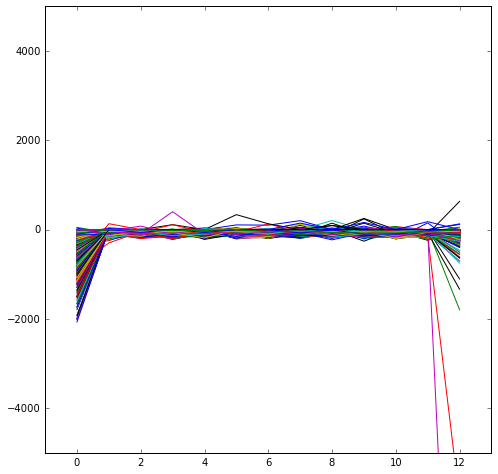

0
0.0 [-39.08331223]
1
0.0 [-78.41666668]
2
0.0 [-56.58331518]
3
0.0 [-40.25000008]
4
-77.0 [-69.91666245]
5
0.0 [-77.8415338]
6
-37.0 [-66.273446]
7
-50.0 [-49.91666667]
8
-26.0 [-42.36010294]
9
-73.0 [-47.16669643]
10
0.0 [-52.9166535]
11
-60.0 [-41.31439552]
12
-34.0 [-34.41666657]
13
0.0 [-57.83333368]
14
-51.0 [-54.89426868]
15
0.0 [-23.83333464]
16
-70.0 [-64.09835285]
17
-71.0 [-63.92467485]
18
-44.0 [-64.11802346]
19
-190.0 [-53.85930569]
20
-20.0 [-27.3174288]
21
-118.0 [-63.54678377]
22
-73.0 [-49.23618569]
23
-90.0 [-46.41666427]
24
0.0 [-56.97478992]
25
-54.0 [-49.27377497]
26
0.0 [-66.55726765]
27
0.0 [-28.92941421]
28
-43.0 [-38.34811419]
29
-49.0 [-41.05021929]
30
-49.0 [-46.83333219]
31
0.0 [-83.33333222]
32
0.0 [-31.99999613]
33
-70.0 [-64.89085873]
34
0.0 [-85.46529396]
35
0.0 [-49.23064621]
36
-57.0 [-37.28867421]
37
-60.0 [-60.]
38
-20.0 [-41.6667115]
39
-60.0 [-61.49999756]
40
-73.0 [-57.01830723]
41
0.0 [-39.9006675]
42
-157.0 [-37.3787028]
43
-43.0 [-26.77139068]

347
-640.0 [-14.67788054]
348
-37.0 [-39.06905126]
349
0.0 [-44.00000007]
350
-20.0 [-43.33333333]
351
-43.0 [-28.02507303]
352
0.0 [-74.84379567]
353
-57.0 [-50.16666667]
354
0.0 [-39.5]
355
-38.0 [-38.]
356
-81.0 [-69.06212872]
357
-70.0 [-62.91666666]
358
-15.0 [-42.41666668]
359
-27.0 [-39.80289688]
360
-41.0 [-41.41668763]
361
-40.0 [-38.77189059]
362
-50.0 [-60.76056799]
363
-80.0 [-72.14813834]
364
-60.0 [-43.35780735]
365
-91.0 [-74.42546761]
366
-117.0 [-74.85997468]
367
0.0 [-23.75000069]
368
-63.0 [-45.41906211]
369
0.0 [-55.16665512]
370
-51.0 [-50.83333335]
371
0.0 [-48.99218783]
372
-113.0 [-56.91666378]
373
0.0 [-45.99302023]
374
-64.0 [-64.]
375
-68.0 [-53.07666984]
376
-22.0 [-66.58333333]
377
-119.0 [-68.75]
378
-100.0 [-78.86674214]
379
-42.0 [-43.41666667]
380
-168.0 [-30.83333149]
381
-48.0 [-82.36036329]
382
-62.0 [-44.30756386]
383
-58.0 [-58.33333329]
384
0.0 [-66.13127366]
385
-71.0 [-23.75000068]
386
-100.0 [-91.66666673]
387
-53.0 [-53.58333333]
388
-64.0 [-6

692
-51.0 [-34.37254948]
693
-60.0 [-55.]
694
-67.0 [-60.72213189]
695
-11.0 [-51.33333339]
696
0.0 [-59.5]
697
0.0 [-43.58331201]
698
-60.0 [-60.]
699
-99.0 [-86.72487757]
700
-48.0 [-48.]
701
0.0 [-83.74999889]
702
-84.0 [-44.13474066]
703
0.0 [-84.4999989]
704
-40.0 [-69.34968935]
705
-42.0 [-27.80066029]
706
-95.0 [-66.74918764]
707
-85.0 [-48.41666667]
708
-50.0 [-50.]
709
-50.0 [-45.83333334]
710
-99.0 [-38.66666718]
711
-110.0 [-41.41666773]
712
0.0 [-83.33333333]
713
-74.0 [-50.67712374]
714
-94.0 [-54.91666638]
715
0.0 [-29.16666667]
716
-106.0 [-39.74999689]
717
-49.0 [-36.33334668]
718
-80.0 [-49.00000005]
719
0.0 [-17.0833751]
720
-86.0 [-81.41667039]
721
0.0 [-74.64875631]
722
0.0 [-31.75000163]
723
-50.0 [-50.]
724
-83.0 [-80.58333333]
725
0.0 [-46.25000028]
726
-46.0 [-32.69231739]
727
-74.0 [-57.41666689]
728
-80.0 [-80.]
729
-99.0 [-57.91665491]
730
-73.0 [-78.99999998]
731
0.0 [-24.08337188]
732
-44.0 [-24.75000002]
733
-21.0 [-31.08333333]
734
-79.0 [-39.16666646]
73

1038
-42.0 [-45.38288623]
1039
-86.0 [-110.8283778]
1040
-144.0 [-36.3308203]
1041
0.0 [-49.99992175]
1042
0.0 [-31.49999964]
1043
-80.0 [-79.16666325]
1044
-34.0 [-25.91666677]
1045
0.0 [-40.33332263]
1046
0.0 [-52.4999964]
1047
-48.0 [-46.17613349]
1048
-129.0 [-83.75034196]
1049
-60.0 [-56.66666985]
1050
-33.0 [-68.1863057]
1051
-122.0 [-59.32304049]
1052
0.0 [-37.66666849]
1053
-50.0 [-50.]
1054
-40.0 [-39.65236967]
1055
-78.0 [-78.08333332]
1056
0.0 [-18.75000459]
1057
-50.0 [-45.83333376]
1058
-48.0 [-47.73962062]
1059
-87.0 [-80.40050135]
1060
-71.0 [-66.68422328]
1061
-65.0 [-57.32704074]
1062
-86.0 [-42.86739289]
1063
-57.0 [-62.58333333]
1064
0.0 [-63.39633344]
1065
0.0 [-46.16666667]
1066
0.0 [-43.58333289]
1067
0.0 [-49.16666668]
1068
-39.0 [-39.67777175]
1069
-25.0 [-38.41774773]
1070
-106.0 [-70.25]
1071
-76.0 [-77.41666667]
1072
0.0 [-30.08333337]
1073
0.0 [-20.25000001]
1074
-70.0 [-42.92060256]
1075
-56.0 [-32.16666669]
1076
-56.0 [-38.49479891]
1077
-50.0 [-37.9166666

1371
-100.0 [-29.18365685]
1372
-87.0 [-59.1730262]
1373
-54.0 [-54.08048485]
1374
-20.0 [-35.23548592]
1375
-73.0 [-53.33333333]
1376
0.0 [-57.33043025]
1377
-76.0 [-50.81392682]
1378
-68.0 [-69.25393603]
1379
0.0 [-149.33333262]
1380
-72.0 [-47.43264332]
1381
-31.0 [-54.84786242]
1382
-84.0 [-50.16364111]
1383
-50.0 [-50.]
1384
-47.0 [-46.66666723]
1385
0.0 [-42.41666748]
1386
-27.0 [-72.83334109]
1387
-40.0 [-32.91664377]
1388
-27.0 [-42.08333333]
1389
-10.0 [-31.91666311]
1390
-51.0 [-70.08787579]
1391
0.0 [-29.4166553]
1392
-60.0 [-36.83333167]
1393
0.0 [-34.16666673]
1394
-59.0 [-56.42950778]
1395
-12.0 [-70.33332953]
1396
0.0 [-47.95537612]
1397
-19.0 [-46.08333308]
1398
-20.0 [-36.75000337]
1399
0.0 [-42.33333132]
1400
117.0 [-36.08331464]
1401
-79.0 [-80.88565407]
1402
-36.0 [-44.58315901]
1403
-170.0 [-61.58333084]
1404
-74.0 [-27.3333337]
1405
-220.0 [-79.70557631]
1406
0.0 [-72.42747496]
1407
0.0 [-20.75]
1408
0.0 [-36.74999982]
1409
-80.0 [-35.83333551]
1410
-118.0 [-75.99

1701
0.0 [-28.66669489]
1702
-111.0 [-40.333331]
1703
0.0 [-58.91667696]
1704
-82.0 [-78.48378446]
1705
-42.0 [-25.66827095]
1706
-340.0 [-68.74998504]
1707
0.0 [-48.41664578]
1708
-42.0 [-39.75]
1709
-72.0 [-63.94429675]
1710
-90.0 [-80.68204559]
1711
-41.0 [-42.0516392]
1712
-93.0 [-56.16666667]
1713
0.0 [-38.08333407]
1714
-61.0 [-44.66666869]
1715
-76.0 [-50.71524311]
1716
-98.0 [-31.66666558]
1717
-80.0 [-76.74998823]
1718
-100.0 [-81.97226409]
1719
-138.0 [-83.02362214]
1720
-60.0 [-52.79161918]
1721
-42.0 [-32.10194789]
1722
-37.0 [-39.90045611]
1723
0.0 [-83.33333333]
1724
-50.0 [-25.81432643]
1725
0.0 [-66.39035398]
1726
0.0 [-54.92336319]
1727
-157.0 [-50.87105963]
1728
-110.0 [-68.37786967]
1729
0.0 [-17.58333242]
1730
0.0 [-37.66666723]
1731
-64.0 [-51.48777726]
1732
0.0 [-36.58333333]
1733
-101.0 [-69.41666732]
1734
-31.0 [-64.42657417]
1735
-70.0 [-58.50002785]
1736
0.0 [-31.39760475]
1737
0.0 [-48.75]
1738
-212.0 [-54.99999725]
1739
-556.0 [-48.16666666]
1740
-50.0 [-65.

2031
54.0 [-46.8019853]
2032
-72.0 [-47.29056181]
2033
-82.0 [-76.08333349]
2034
-47.0 [-34.28735939]
2035
0.0 [-76.4999988]
2036
-147.0 [-72.99999994]
2037
-34.0 [-57.16666587]
2038
-1796.0 [-62.16663763]
2039
-30.0 [-61.5690536]
2040
-70.0 [-71.21135061]
2041
-63.0 [-44.86681181]
2042
0.0 [-46.74999947]
2043
0.0 [-38.33333364]
2044
-45.0 [-50.41666667]
2045
-80.0 [-51.]
2046
0.0 [-27.5]
2047
-76.0 [-69.83333415]
2048
-42.0 [-43.08333333]
2049
-54.0 [-54.25000192]
2050
-53.0 [-53.00000001]
2051
-59.0 [-59.16666665]
2052
0.0 [-24.66668378]
2053
-90.0 [-46.65775167]
2054
0.0 [-32.66665911]
2055
-133.0 [-72.66665655]
2056
-46.0 [-31.08338588]
2057
0.0 [-83.33333222]
2058
0.0 [-61.64498201]
2059
0.0 [-36.66666667]
2060
-85.0 [-65.73897795]
2061
-50.0 [-43.33332652]
2062
-47.0 [-47.33333206]
2063
-61.0 [-56.84496605]
2064
-56.0 [-27.50000469]
2065
-53.0 [-51.85074838]
2066
0.0 [-62.33333333]
2067
0.0 [-49.99992175]
2068
-82.0 [-74.41671431]
2069
-33.0 [-34.477742]
2070
0.0 [-55.91666667]
2

2362
-19.0 [-26.75]
2363
-90.0 [-37.83332816]
2364
-70.0 [-53.88511125]
2365
-54.0 [-38.91969594]
2366
-76.0 [-76.]
2367
-97.0 [-58.66666674]
2368
-45.0 [-45.]
2369
-124.0 [-73.54270669]
2370
-73.0 [-75.25]
2371
-96.0 [-54.58331816]
2372
-59.0 [-58.5]
2373
-38.0 [-45.87486205]
2374
0.0 [-38.08333333]
2375
-49.0 [-51.58333333]
2376
0.0 [-58.48602849]
2377
-65.0 [-70.47255329]
2378
0.0 [-50.49999992]
2379
0.0 [-52.7500011]
2380
-106.0 [-61.32238277]
2381
-215.0 [-122.23203559]
2382
-91.0 [-56.22587815]
2383
-50.0 [-33.25771149]
2384
0.0 [-49.75]
2385
-191.0 [-88.97271536]
2386
-67.0 [-48.07754594]
2387
-59.0 [-61.58333336]
2388
-65.0 [-44.07885295]
2389
-73.0 [-59.60478645]
2390
-50.0 [-50.]
2391
-75.0 [-48.3695367]
2392
0.0 [-30.33333333]
2393
-53.0 [-52.15044036]
2394
-36.0 [-40.23517376]
2395
0.0 [-37.0000004]
2396
0.0 [-26.61534952]
2397
-48.0 [-37.19432278]
2398
-55.0 [-46.79397425]
2399
-140.0 [-43.33335151]
2400
-76.0 [-38.16666662]
2401
-48.0 [-41.66666673]
2402
-66.0 [-52.664511

2692
0.0 [-49.99999992]
2693
-43.0 [-81.66038824]
2694
-48.0 [-31.58419079]
2695
-72.0 [-68.]
2696
-50.0 [-48.52277549]
2697
-106.0 [-79.03423319]
2698
0.0 [-52.52284885]
2699
-70.0 [-67.91194591]
2700
-140.0 [-81.11651609]
2701
-50.0 [-40.41670689]
2702
-80.0 [-93.85326014]
2703
0.0 [-89.87028072]
2704
0.0 [-34.4999977]
2705
-46.0 [-36.]
2706
0.0 [-40.66666625]
2707
-40.0 [-34.99999999]
2708
0.0 [-102.49999906]
2709
-64.0 [-39.54154725]
2710
-80.0 [-70.53309144]
2711
0.0 [-38.08333339]
2712
-59.0 [-56.58896314]
2713
-39.0 [-39.]
2714
0.0 [-15.08333342]
2715
-50.0 [-107.81373557]
2716
0.0 [-58.50239206]
2717
-120.0 [-49.27115672]
2718
-75.0 [-45.84800587]
2719
0.0 [-75.99999697]
2720
-32.0 [-41.01920804]
2721
-100.0 [-94.20674395]
2722
-52.0 [-47.75000004]
2723
0.0 [-59.75]
2724
-60.0 [-40.99082267]
2725
-54.0 [-54.]
2726
-25.0 [-39.25001463]
2727
-49.0 [-34.56633004]
2728
-66.0 [-75.67278239]
2729
-33.0 [-44.58333371]
2730
-53.0 [-58.56352667]
2731
-93.0 [-60.81872696]
2732
-42.0 [-27

3025
-24.0 [-30.19846884]
3026
-89.0 [-82.13187109]
3027
-86.0 [-76.41668317]
3028
-100.0 [-49.6217407]
3029
-90.0 [-82.50000949]
3030
0.0 [-30.41666667]
3031
-40.0 [-21.9166667]
3032
-33.0 [-33.]
3033
-69.0 [-48.51400146]
3034
-98.0 [-76.11192855]
3035
0.0 [-31.00000001]
3036
-61.0 [-56.33333332]
3037
-50.0 [-49.74999959]
3038
-44.0 [-27.02531665]
3039
0.0 [-61.00000049]
3040
-75.0 [-58.83333333]
3041
0.0 [-134.08333256]
3042
0.0 [-27.33333333]
3043
-70.0 [-47.88245224]
3044
-252.0 [-128.53924029]
3045
-78.0 [-61.61279381]
3046
0.0 [-42.5]
3047
0.0 [-91.66666543]
3048
0.0 [-83.33333333]
3049
-63.0 [-45.4554767]
3050
-92.0 [-46.91666622]
3051
-68.0 [-67.39886545]
3052
0.0 [-36.24998107]
3053
-170.0 [-61.94487255]
3054
-38.0 [-41.39958299]
3055
0.0 [-20.77554242]
3056
-78.0 [-76.03156424]
3057
-34.0 [-34.]
3058
632.0 [-71.33333785]
3059
-78.0 [-78.83333314]
3060
0.0 [-27.84565645]
3061
-40.0 [-33.25861849]
3062
-74.0 [-227.44668488]
3063
-48.0 [-49.08925446]
3064
0.0 [-45.16666673]
3065

3355
0.0 [-16.58333333]
3356
-270.0 [-78.94629417]
3357
0.0 [-25.16670838]
3358
-23.0 [-35.41666809]
3359
-55.0 [-59.41665275]
3360
-60.0 [-52.75000934]
3361
-75.0 [-43.24997416]
3362
0.0 [-28.99999464]
3363
-50.0 [-50.]
3364
-65.0 [-44.40133203]
3365
0.0 [-60.83333553]
3366
-20.0 [-22.33638492]
3367
0.0 [-27.75000263]
3368
-68.0 [-45.11086311]
3369
-50.0 [-39.06151755]
3370
0.0 [-34.41666949]
3371
0.0 [-67.83333333]
3372
-51.0 [-43.73371726]
3373
-120.0 [-90.31881805]
3374
-45.0 [-160.03004361]
3375
-44.0 [-33.41666689]
3376
-62.0 [-56.75000236]
3377
0.0 [-36.08333333]
3378
-70.0 [-54.16666667]
3379
-60.0 [-29.91666667]
3380
-83.0 [-79.47135856]
3381
-73.0 [-20.63951509]
3382
-49.0 [-22.33808193]
3383
0.0 [-59.60481544]
3384
-114.0 [-29.18961364]
3385
-61.0 [-56.52864203]
3386
-69.0 [-79.42727837]
3387
-40.0 [-40.]
3388
-120.0 [-49.99998811]
3389
-40.0 [-43.33330442]
3390
0.0 [-30.33331882]
3391
-39.0 [-38.74999999]
3392
0.0 [-74.75]
3393
-66.0 [-66.33333333]
3394
0.0 [-59.12609419]
3

3685
-78.0 [-78.58333305]
3686
-65.0 [-65.78319563]
3687
-42.0 [-47.81546282]
3688
0.0 [-33.25001597]
3689
-79.0 [-37.71689116]
3690
-30.0 [-36.58333333]
3691
-81.0 [-38.29022176]
3692
-20.0 [-55.79755709]
3693
-77.0 [-52.42243924]
3694
-103.0 [-55.74999287]
3695
0.0 [-57.41664891]
3696
-70.0 [-70.]
3697
-68.0 [-44.22630966]
3698
-109.0 [-78.48621924]
3699
-55.0 [-37.75000154]
3700
-49.0 [-31.07367413]
3701
-52.0 [-39.33333545]
3702
-44.0 [-22.08333374]
3703
-82.0 [-54.02932991]
3704
-66.0 [-42.83337487]
3705
-49.0 [-63.36234057]
3706
-60.0 [-42.10067611]
3707
-49.0 [-38.32619313]
3708
-91.0 [-70.]
3709
-351.0 [-25.75000733]
3710
-44.0 [-42.06547094]
3711
-102.0 [-37.16666667]
3712
-42.0 [-39.58333349]
3713
-88.0 [-53.45934499]
3714
-18.0 [-22.58333333]
3715
-78.0 [-37.32922465]
3716
0.0 [-28.58333333]
3717
-113.0 [-68.74999738]
3718
-51.0 [-42.08333337]
3719
-37.0 [-37.]
3720
-59.0 [-57.27724344]
3721
-12.0 [-30.10744221]
3722
-64.0 [-38.9999996]
3723
-60.0 [-44.11071669]
3724
-99.0 [

4015
-45.0 [-38.83620967]
4016
-49.0 [-48.51495353]
4017
-50.0 [-42.75000004]
4018
0.0 [-35.1666669]
4019
-57.0 [-36.70147397]
4020
-12.0 [-24.20582878]
4021
-49.0 [-50.33333333]
4022
-70.0 [-70.]
4023
-66.0 [-58.19406036]
4024
-55.0 [-39.2938561]
4025
-46.0 [-54.5]
4026
-42.0 [-26.81988783]
4027
-38.0 [-25.33012734]
4028
0.0 [-29.9590243]
4029
-33.0 [-22.41666707]
4030
-54.0 [-48.03039595]
4031
-241.0 [-55.094487]
4032
-72.0 [-70.83736389]
4033
-57.0 [-46.33333506]
4034
-7.0 [-66.41664668]
4035
0.0 [-31.83333333]
4036
-82.0 [-59.65546413]
4037
-60.0 [-60.]
4038
0.0 [-63.75]
4039
-178.0 [-54.69311907]
4040
0.0 [-27.00000078]
4041
0.0 [-42.41665878]
4042
-50.0 [-42.25]
4043
-50.0 [-49.67866215]
4044
0.0 [-52.24968624]
4045
0.0 [-55.58333401]
4046
-68.0 [-39.24999381]
4047
0.0 [-38.66666667]
4048
-56.0 [-43.]
4049
0.0 [-47.5]
4050
-102.0 [-59.21316821]
4051
0.0 [-60.75550701]
4052
0.0 [-160.99999931]
4053
0.0 [-35.66666493]
4054
0.0 [-60.66653879]
4055
-83.0 [-71.07536593]
4056
0.0 [-82.

4346
-85.0 [-32.5630451]
4347
-45.0 [-24.55222345]
4348
-544.0 [-70.83333333]
4349
-66.0 [-66.]
4350
-56.0 [-49.03056751]
4351
-54.0 [-39.45999316]
4352
-20.0 [-33.4372867]
4353
-48.0 [-33.801226]
4354
-90.0 [-42.24999959]
4355
-82.0 [-32.41686268]
4356
-50.0 [-44.83333333]
4357
-49.0 [-44.42737666]
4358
-35.0 [-36.61778604]
4359
-67.0 [-32.91666348]
4360
0.0 [-124.9999992]
4361
-18.0 [-21.5000157]
4362
0.0 [-38.16666675]
4363
-26.0 [-68.8999824]
4364
-42.0 [-30.3464864]
4365
-20.0 [-32.91666678]
4366
0.0 [-17.50002794]
4367
-57.0 [-37.09591773]
4368
-51.0 [-49.98308831]
4369
-96.0 [-53.95081601]
4370
0.0 [ 14.49772902]
4371
-60.0 [-60.]
4372
0.0 [-53.91666667]
4373
-37.0 [-71.12319043]
4374
-55.0 [-78.52338618]
4375
-60.0 [-67.91666666]
4376
-63.0 [-42.53405752]
4377
-65.0 [-64.916667]
4378
-67.0 [-42.75588618]
4379
0.0 [-34.9166668]
4380
-77.0 [-46.2535612]
4381
-30.0 [-55.58333016]
4382
-44.0 [-51.74999993]
4383
0.0 [-79.49999884]
4384
-58.0 [-58.91902256]
4385
-51.0 [-33.78419184]


4675
0.0 [-58.33215754]
4676
-55.0 [-64.92569535]
4677
-100.0 [-61.81547717]
4678
-76.0 [-49.]
4679
-234.0 [-64.83333111]
4680
-50.0 [-50.16666667]
4681
-80.0 [-51.83333253]
4682
-1335.0 [-55.00000001]
4683
-59.0 [-55.48853387]
4684
-35.0 [-12.83336299]
4685
0.0 [-66.55936464]
4686
-56.0 [-64.25]
4687
-95.0 [-69.25]
4688
-42.0 [-36.91666902]
4689
-95.0 [-44.2052486]
4690
-64.0 [-53.66666667]
4691
-74.0 [-57.13497249]
4692
-54.0 [-53.25000001]
4693
-62.0 [-64.25000559]
4694
-71.0 [-54.29523764]
4695
0.0 [-36.16666395]
4696
-13.0 [-39.99999664]
4697
-85.0 [-78.]
4698
-77.0 [-57.05488644]
4699
-48.0 [-53.7500008]
4700
-68.0 [-55.23495159]
4701
-50.0 [-41.58333333]
4702
-46.0 [-32.08414712]
4703
-60.0 [-56.91666601]
4704
0.0 [-44.30305925]
4705
-48.0 [-44.58337536]
4706
0.0 [-38.83333333]
4707
-45.0 [-44.33333434]
4708
0.0 [-30.41666703]
4709
-53.0 [-47.8613041]
4710
0.0 [-91.66666667]
4711
0.0 [-35.36189496]
4712
0.0 [-24.58333331]
4713
-200.0 [-35.83331253]
4714
-34.0 [-49.0830726]
4715


In [57]:
#Llegim les comptes del 27è cluster
accountcluster27=np.zeros((len(assignmentsclus[26]),13))
for i in np.arange(len(assignmentsclus[26])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster27[i]=accountclean[assignmentsclus[26][i].astype(int)]

print accountcluster27.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster27.shape[0]):
        plt.plot(accountcluster27[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 438.0**2 * RBF(length_scale=45.0)  # long term smooth rising trend
k2 = 32.0**2 * RBF(length_scale=0.3)
k3 = 11.5**2* RationalQuadratic(length_scale=2.0, alpha=0.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=7.2**2)  # noise terms
kernel_gpmlini = k1+k2+k3+k4


gp27 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regression1(accountcluster27,accountcluster27.shape[0],gp27,26)

(2680, 13)


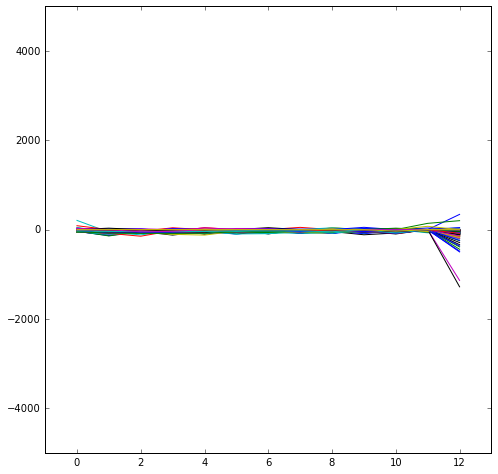

Iteracio: 1
-50.0 [ 0.]
[-10.91387703] [ 10.91387703]
[-21.39119898] [ 21.39119898]
11.0
Iteracio: 18
-1139.0 [ 0.]
[-11.24445005] [ 11.24445005]
[-22.03912209] [ 22.03912209]
10.0
Iteracio: 29
0.0 [-43.00000067]
[-56.41556107] [-29.58444027]
[-69.29449906] [-16.70550228]
50.7740090991
Iteracio: 48
-291.0 [ 0.]
[-12.89844971] [ 12.89844971]
[-25.28096143] [ 25.28096143]
5.0
Iteracio: 55
-71.0 [ 0.]
[-13.89019445] [ 13.89019445]
[-27.22478113] [ 27.22478113]
2.0
Iteracio: 69
-73.0 [-0.9806565]
[-27.17094698] [ 25.20963398]
[-52.31362584] [ 50.35231285]
43.4511219648
Iteracio: 73
-97.0 [ 0.]
[-12.23661327] [ 12.23661327]
[-23.983762] [ 23.983762]
7.0
Iteracio: 76
0.0 [-42.125]
[-63.35692575] [-20.89307425]
[-83.73957447] [-0.51042553]
54.1571786562
Iteracio: 83
-152.0 [-37.]
[-66.07074834] [-7.92925166]
[-93.97866674] [ 19.97866674]
74.3236167042
Iteracio: 91
0.0 [-36.37719639]
[-48.65050246] [-24.10389033]
[-60.43287628] [-12.32151651]
46.3141447076
Iteracio: 102
-59.0 [-1.74999973]
[-1

Iteracio: 991
0.0 [-50.87497659]
[-60.85132372] [-40.89862947]
[-70.42861696] [-31.32133622]
52.163205423
Iteracio: 1004
0.0 [-36.75000023]
[-48.42584037] [-25.0741601]
[-59.6346469] [-13.86535357]
38.9101529167
Iteracio: 1008
-47.0 [-1.37499974]
[-16.36420124] [ 13.61420176]
[-30.75383468] [ 28.0038352]
22.8473193176
Iteracio: 1026
0.0 [-57.]
[-85.73863453] [-28.26136547]
[-113.32772368] [-0.67227632]
68.4543643605
Iteracio: 1031
-74.0 [ 0.]
[-13.56051377] [ 13.56051377]
[-26.578607] [ 26.578607]
3.0
Iteracio: 1041
-62.0 [-1.2499965]
[-16.02698495] [ 13.52699195]
[-30.21289386] [ 27.71290086]
14.1774468788
Iteracio: 1049
0.0 [-33.5]
[-50.29591045] [-16.70408955]
[-66.41998448] [-0.58001552]
53.7215040743
Iteracio: 1081
-44.0 [ 0.]
[-13.56000205] [ 13.56000205]
[-26.57760402] [ 26.57760402]
3.0
Iteracio: 1106
-40.0 [ 0.]
[-13.22875663] [ 13.22875663]
[-25.92836299] [ 25.92836299]
4.0
Iteracio: 1110
-70.0 [-8.]
[-36.99139893] [ 20.99139893]
[-64.8231419] [ 48.82314191]
52.3259018078
Ite

Iteracio: 1972
-146.0 [ 0.]
[-12.23659847] [ 12.23659847]
[-23.98373299] [ 23.98373299]
7.0
Iteracio: 1977
-42.0 [ 0.]
[-13.55946282] [ 13.55946282]
[-26.57654712] [ 26.57654712]
3.0
Iteracio: 1996
0.0 [-40.87547712]
[-57.59479258] [-24.15616167]
[-73.64533541] [-8.10561883]
53.6097006147
Iteracio: 2008
-1282.0 [ 0.]
[-13.22876302] [ 13.22876302]
[-25.92837551] [ 25.92837551]
4.0
Iteracio: 2042
-135.0 [-5.62499372]
[-29.19407101] [ 17.94408358]
[-51.82038521] [ 40.57039778]
2.0
Iteracio: 2044
-50.0 [-4.99999844]
[-26.17633974] [ 16.17634286]
[-46.50562739] [ 36.50563051]
8.24621125124
Iteracio: 2046
-45.0 [ 0.]
[-17.75125709] [ 17.75125709]
[-34.7924639] [ 34.7924639]
14.8660687473
Iteracio: 2052
-98.0 [ 0.]
[-13.89019653] [ 13.89019653]
[-27.22478521] [ 27.22478521]
2.0
Iteracio: 2066
-100.0 [ 0.]
[-20.37354471] [ 20.37354471]
[-39.93214764] [ 39.93214764]
7.21110255093
Iteracio: 2072
-114.0 [ 0.]
[-11.90592626] [ 11.90592626]
[-23.33561547] [ 23.33561547]
8.0
Iteracio: 2103
0.0 [-39.

array([ 0.47504772])

In [23]:
#Llegim les comptes del 28è cluster
accountcluster28=np.zeros((len(assignmentsclus[27]),13))
for i in np.arange(len(assignmentsclus[27])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster28[i]=accountclean[assignmentsclus[27][i].astype(int)]

print accountcluster28.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster28.shape[0]):
        plt.plot(accountcluster28[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 65.0**2 * RBF(length_scale=20.0)  # long term smooth rising trend
#k2 = 3.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k2= 24.0**2 * RBF(length_scale=0.4)
k3 = 4.5**2* RationalQuadratic(length_scale=10.0, alpha=0.7)
k4 = 1.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=5.2**2)  # noise terms
kernel_gpmlini = k1+k2+k3+k4


gp28 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster28,accountcluster28.shape[0],gp28,27)

(2608, 13)


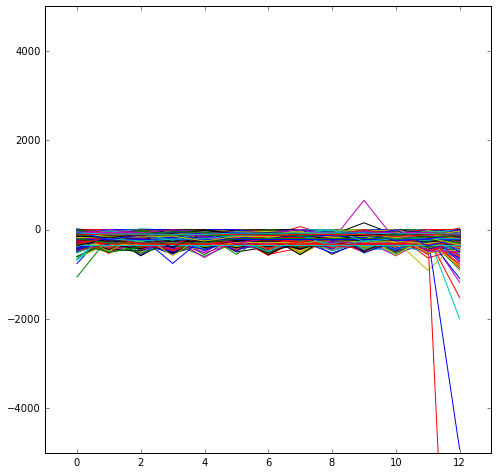

Iteracio: 1
-368.0 [-152.625]
[-231.40780483] [-73.84219517]
[-307.03929746] [ 1.78929746]
273.894140134
Iteracio: 2
-37.0 [-188.87499939]
[-254.31474686] [-123.43525192]
[-317.13690444] [-60.61309434]
217.540800771
Iteracio: 3
-71.0 [-163.25]
[-200.4244325] [-126.07556751]
[-236.11188769] [-90.38811231]
200.815836029
Iteracio: 19
-50.0 [-98.38482358]
[-122.11658767] [-74.65305949]
[-144.89908119] [-51.87056596]
107.800742112
Iteracio: 21
-476.0 [-121.87498249]
[-155.85677648] [-87.89318849]
[-188.47929871] [-55.27066626]
110.181668167
Iteracio: 25
-362.0 [-261.5]
[-285.21702092] [-237.78297908]
[-307.985361] [-215.014639]
462.857429453
Iteracio: 35
-401.0 [-127.1249945]
[-177.76726423] [-76.48272477]
[-226.38384317] [-27.86614582]
211.584498487
Iteracio: 37
-290.0 [-110.87499982]
[-136.32808383] [-85.42191581]
[-160.76304448] [-60.98695516]
104.115320679
Iteracio: 43
-55.0 [-127.74999982]
[-159.63163045] [-95.86836919]
[-190.23799586] [-65.26200378]
180.773338742
Iteracio: 44
-243.0 [

Iteracio: 426
0.0 [-159.24999512]
[-211.38378947] [-107.11620078]
[-261.43223204] [-57.06775821]
307.980518864
Iteracio: 431
-436.0 [-156.875]
[-216.45779904] [-97.29220097]
[-273.65728611] [-40.09271389]
282.260517962
Iteracio: 437
-290.0 [-165.62499901]
[-210.54343028] [-120.70656774]
[-253.6651243] [-77.58487372]
168.124953532
Iteracio: 443
-373.0 [-107.50010141]
[-182.09238078] [-32.90782203]
[-253.70096898] [ 38.70076617]
271.455337026
Iteracio: 446
-260.0 [-105.37497791]
[-169.52896675] [-41.22098908]
[-231.11679603] [ 20.36684021]
212.983567441
Iteracio: 447
-59.0 [-95.38651438]
[-112.68247267] [-78.09055609]
[-129.28659263] [-61.48643613]
93.5040106092
Iteracio: 453
-336.0 [-113.5]
[-181.28469047] [-45.71530953]
[-246.35799331] [ 19.35799331]
187.587313004
Iteracio: 458
-258.0 [-126.50000048]
[-131.44975662] [-121.55024434]
[-136.20152251] [-116.79847845]
106.742681248
Iteracio: 463
-182.0 [-79.87498258]
[-118.61271585] [-41.13724931]
[-155.80093979] [-3.94902537]
150.076647084

Iteracio: 774
-368.0 [-139.375]
[-202.92610404] [-75.82389596]
[-263.93516392] [-14.81483608]
190.483595094
Iteracio: 777
-172.0 [-162.61481484]
[-166.18462712] [-159.04500255]
[-169.61164691] [-155.61798276]
327.279696895
Iteracio: 790
-60.0 [-137.25000063]
[-174.60545693] [-99.89454433]
[-210.46669497] [-64.03330629]
113.951744173
Iteracio: 794
-201.0 [-75.25]
[-113.18003492] [-37.31996508]
[-149.59286844] [-0.90713156]
157.356283637
Iteracio: 797
-283.0 [-161.75]
[-215.61890909] [-107.88109091]
[-267.33306182] [-56.16693818]
323.814761862
Iteracio: 806
-88.0 [-95.37500002]
[-98.1109278] [-92.63907224]
[-100.73741846] [-90.01258157]
165.963851486
Iteracio: 809
-188.0 [-140.37499941]
[-164.04447021] [-116.70552862]
[-186.76716217] [-93.98283665]
81.0863737011
Iteracio: 810
0.0 [-72.125]
[-108.85522429] [-35.39477571]
[-144.1162396] [-0.1337604]
152.049334099
Iteracio: 813
-230.0 [-102.50000003]
[-167.45185078] [-37.54814928]
[-229.80562751] [ 24.80562745]
284.003521105
Iteracio: 815
-

Iteracio: 1200
-30.0 [-118.25]
[-154.97518114] [-81.52481886]
[-190.23135504] [-46.26864496]
150.442680114
Iteracio: 1207
-291.0 [-95.62500015]
[-96.61716638] [-94.63283391]
[-97.56964597] [-93.68035432]
196.77652299
Iteracio: 1212
-157.0 [-87.5]
[-119.56181721] [-55.43818279]
[-150.34116174] [-24.65883826]
183.787921257
Iteracio: 1216
-5.0 [-96.73545389]
[-107.07637728] [-86.3945305]
[-117.00366373] [-76.46724405]
163.627626029
Iteracio: 1217
-32.0 [-69.01732926]
[-83.68294143] [-54.35171709]
[-97.76192911] [-40.27272941]
116.854610521
Iteracio: 1218
-43.0 [-140.75]
[-175.23459914] [-106.26540086]
[-208.33981431] [-73.16018569]
150.505813841
Iteracio: 1223
-129.0 [-257.37506178]
[-306.3583329] [-208.39179066]
[-353.38227317] [-161.36785038]
397.626709364
Iteracio: 1224
-109.0 [-179.875]
[-200.45679755] [-159.29320246]
[-220.21532319] [-139.53467682]
201.504342385
Iteracio: 1227
-218.0 [-101.12499839]
[-138.02838078] [-64.221616]
[-173.45562787] [-28.79436891]
126.324977736
Iteracio: 1

Iteracio: 1601
-164.0 [-56.62506861]
[-104.4844986] [-8.76563862]
[-150.42955139] [ 37.17941418]
179.521586446
Iteracio: 1603
-208.0 [-44.12499988]
[-60.20420983] [-28.04578994]
[-75.64025137] [-12.60974839]
125.89678312
Iteracio: 1605
-507.0 [-234.12499999]
[-303.6581304] [-164.59186957]
[-370.4099356] [-97.84006437]
513.148126763
Iteracio: 1610
-4917.0 [-104.99999996]
[-147.30695396] [-62.69304596]
[-187.9216298] [-22.07837012]
160.717142832
Iteracio: 1614
-196.0 [-90.125]
[-122.73809753] [-57.51190247]
[-154.04667116] [-26.20332884]
120.859422471
Iteracio: 1615
-207.0 [-116.87502223]
[-152.77570592] [-80.97433855]
[-187.24036226] [-46.50968221]
204.948774088
Iteracio: 1639
-450.0 [-190.]
[-230.3112493] [-149.6887507]
[-269.01004862] [-110.98995138]
236.262565803
Iteracio: 1642
-303.0 [-196.39394191]
[-210.24602018] [-182.54186364]
[-223.54401532] [-169.2438685]
184.105947758
Iteracio: 1643
-51.0 [-157.25810322]
[-192.66144359] [-121.85476286]
[-226.64865033] [-87.86755612]
185.36450

Iteracio: 2020
-268.0 [-69.75267275]
[-110.68427133] [-28.82107416]
[-149.97860597] [ 10.47326048]
129.807549857
Iteracio: 2026
-367.0 [-202.49988325]
[-268.51879094] [-136.48097556]
[-331.89694233] [-73.10282418]
507.460343278
Iteracio: 2030
-281.0 [-250.]
[-250.00334664] [-249.99665336]
[-250.00655942] [-249.99344058]
448.523132068
Iteracio: 2034
-408.0 [-240.24998161]
[-295.43070348] [-185.06925975]
[-348.40419647] [-132.09576676]
417.100707264
Iteracio: 2037
-72.0 [-200.07007845]
[-259.88704907] [-140.25310783]
[-317.31134086] [-82.82881604]
199.499373433
Iteracio: 2039
-215.0 [-89.24999983]
[-136.47487278] [-42.02512689]
[-181.81075081] [ 3.31075114]
244.88364584
Iteracio: 2044
-253.0 [-109.20325916]
[-161.46933002] [-56.9371883]
[-211.64475804] [-6.76176027]
147.885090526
Iteracio: 2048
-339.0 [-154.00004901]
[-222.58308603] [-85.41701199]
[-288.42280157] [-19.57729645]
370.334983495
Iteracio: 2056
-168.0 [-116.]
[-132.16322704] [-99.83677296]
[-147.67992499] [-84.32007501]
106.9

Iteracio: 2448
-234.0 [-117.5]
[-158.78275761] [-76.21724239]
[-198.41420492] [-36.58579508]
190.189379304
Iteracio: 2449
0.0 [-145.87502197]
[-203.34041559] [-88.40962835]
[-258.50719347] [-33.24285048]
171.874954545
Iteracio: 2463
-318.0 [-188.625]
[-246.60979579] [-130.64020421]
[-302.27519976] [-74.97480024]
283.19604517
Iteracio: 2470
-392.0 [-174.125]
[-252.30657956] [-95.94342044]
[-327.36089593] [-20.88910407]
364.971231743
Iteracio: 2475
-390.0 [-185.75000055]
[-235.15331713] [-136.34668398]
[-282.58050104] [-88.91950007]
190.002631561
Iteracio: 2477
-216.0 [-51.99999998]
[-105.48829974] [ 1.48829977]
[-156.8370675] [ 52.83706753]
162.348390814
Iteracio: 2479
-196.0 [-62.12506076]
[-127.43095492] [ 3.18083341]
[-190.12461332] [ 65.8744918]
182.145546199
Iteracio: 2483
-52.0 [-100.125]
[-112.96476283] [-87.28523717]
[-125.29093515] [-74.95906485]
140.790624688
Iteracio: 2487
-126.0 [-113.55991218]
[-118.47089308] [-108.64893128]
[-123.18543475] [-103.93438961]
113.529731789
Ite

array([ 0.80039723])

In [59]:
#Llegim les comptes del 29è cluster
accountcluster29=np.zeros((len(assignmentsclus[28]),13))
for i in np.arange(len(assignmentsclus[28])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster29[i]=accountclean[assignmentsclus[28][i].astype(int)]

print accountcluster29.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster29.shape[0]):
        plt.plot(accountcluster29[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 440.0**2 * RBF(length_scale=50.0)  # long term smooth rising trend
k2 = 3.0**2 * RBF(length_scale=10.0) 
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
##CAL AFEGIR K2
k3 = 31.5**2* RationalQuadratic(length_scale=4.2, alpha=0.6)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=6.2**2)  # noise terms
kernel_gpmlini = k1+k2+k3+k4


gp29 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster29,accountcluster29.shape[0],gp29,28)

(1503, 13)


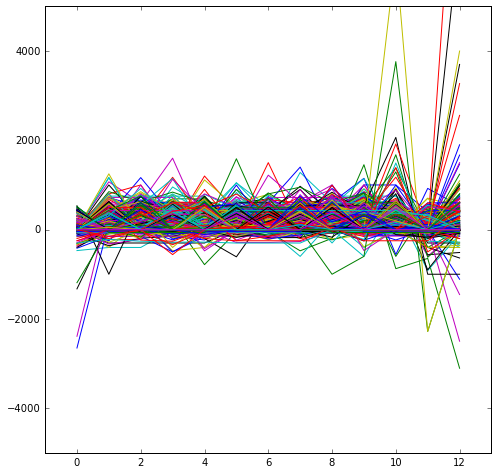

Iteracio: 55
300.0 [ 0.62500004]
[-114.90215063] [ 116.15215072]
[-225.80821528] [ 227.05821537]
120.208152802
Iteracio: 91
600.0 [ 0.]
[-198.43130628] [ 198.43130628]
[-388.9253603] [ 388.9253603]
130.0
Iteracio: 100
450.0 [ 0.]
[-165.35998431] [ 165.35998431]
[-324.10556924] [ 324.10556924]
30.0
Iteracio: 118
506.0 [ 19.00009984]
[-227.46827585] [ 265.46847552]
[-464.07791651] [ 502.07811619]
197.868643297
Iteracio: 147
379.0 [ 17.50007276]
[-123.63193398] [ 158.6320795]
[-259.11866046] [ 294.11880598]
248.557840351
Iteracio: 155
755.0 [ 41.67563081]
[-274.55003494] [ 357.90129656]
[-578.12667407] [ 661.47793569]
379.47331922
Iteracio: 163
502.0 [ 0.]
[-249.40227578] [ 249.40227578]
[-488.82846053] [ 488.82846053]
294.869462644
Iteracio: 179
419.0 [ 0.]
[-107.15292957] [ 107.15292957]
[-210.01974195] [ 210.01974195]
146.0
Iteracio: 187
700.0 [ 0.]
[-132.28756592] [ 132.28756592]
[-259.2836292] [ 259.2836292]
70.0
Iteracio: 224
1670.0 [ 62.49999023]
[-154.0063797] [ 279.00636016]
[-36

array([ 0.63127816])

In [24]:
#Llegim les comptes del 30è cluster
accountcluster30=np.zeros((len(assignmentsclus[29]),13))
for i in np.arange(len(assignmentsclus[29])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster30[i]=accountclean[assignmentsclus[29][i].astype(int)]

print accountcluster30.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster30.shape[0]):
        plt.plot(accountcluster30[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 765.0**2 * RBF(length_scale=89.0)  # long term smooth rising trend
#k2 = 3.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
#CAL AFEGIR K2
k3 = 51.5**2* RationalQuadratic(length_scale=12.0, alpha=0.9)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=9.2**2)  # noise terms
kernel_gpmlini = k1+k3+k4


gp30 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster30,accountcluster30.shape[0],gp30,29)

(3337, 13)


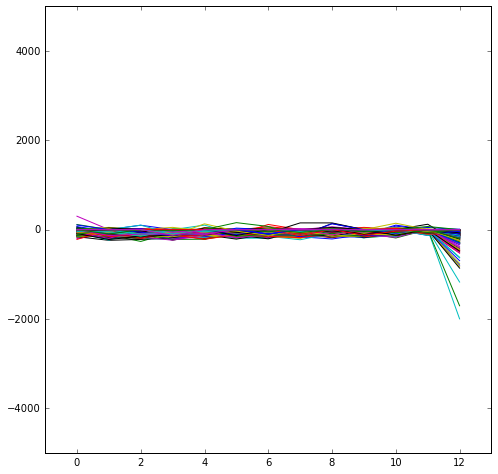

Iteracio: 2
-11.0 [ 0.]
[-0.00471405] [ 0.00471405]
[-0.00923953] [ 0.00923953]
4.0
Iteracio: 3
-13.0 [ 0.]
[-0.00334664] [ 0.00334664]
[-0.00655941] [ 0.00655941]
35.7071421427
Iteracio: 28
-155.0 [ 0.]
[-0.00334664] [ 0.00334664]
[-0.00655941] [ 0.00655941]
37.0
Iteracio: 32
-82.0 [-39.11066211]
[-44.12627194] [-34.09505228]
[-48.94125737] [-29.28006685]
40.2367990775
Iteracio: 36
-108.0 [ 0.]
[-0.00334664] [ 0.00334664]
[-0.00655941] [ 0.00655941]
1.0
Iteracio: 55
-76.0 [-14.125]
[-38.6017725] [ 10.3517725]
[-62.09947409] [ 33.84947409]
80.0874522007
Iteracio: 80
-2000.0 [ 0.]
[-0.00334664] [ 0.00334664]
[-0.00655941] [ 0.00655941]
0.0
Iteracio: 88
0.0 [-44.51051938]
[-61.37193658] [-27.64910218]
[-77.55889709] [-11.46214167]
101.488915651
Iteracio: 91
-164.0 [-5.5]
[-17.03271393] [ 6.03271393]
[-28.10411931] [ 17.10411931]
49.355850717
Iteracio: 104
-174.0 [-11.26021925]
[-30.66959341] [ 8.14915491]
[-49.3025926] [ 26.78215411]
70.8166647054
Iteracio: 115
-80.0 [-3.50019231]
[-12.7

Iteracio: 787
-44.0 [ 0.]
[-0.00471405] [ 0.00471405]
[-0.00923953] [ 0.00923953]
10.0
Iteracio: 788
-50.0 [ 0.]
[-0.00334664] [ 0.00334664]
[-0.00655941] [ 0.00655941]
0.0
Iteracio: 813
-304.0 [ 0.]
[-0.00471405] [ 0.00471405]
[-0.00923953] [ 0.00923953]
0.0
Iteracio: 819
-128.0 [-4.624988]
[-15.42929068] [ 6.17931467]
[-25.80142125] [ 16.55144524]
35.1567916625
Iteracio: 850
-245.0 [ 0.]
[-0.00471405] [ 0.00471405]
[-0.00923953] [ 0.00923953]
25.0
Iteracio: 869
-139.0 [ 0.]
[-0.00334664] [ 0.00334664]
[-0.00655941] [ 0.00655941]
34.0
Iteracio: 892
-104.0 [-0.36762321]
[-26.4972208] [ 25.76197438]
[-51.58163449] [ 50.84638807]
202.810256151
Iteracio: 905
-40.0 [-20.15619416]
[-26.15909332] [-14.153295]
[-31.92187652] [-8.3905118]
53.8516480713
Iteracio: 912
-69.0 [-7.24999994]
[-17.86545216] [ 3.36545228]
[-28.05628629] [ 13.55628642]
37.0270171631
Iteracio: 913
-100.0 [-12.49998705]
[-45.57185649] [ 20.57188239]
[-77.32085116] [ 52.32087705]
0.0
Iteracio: 915
-19.0 [-9.57237328]
[-13

Iteracio: 1576
-96.0 [ 0.]
[-0.00334664] [ 0.00334664]
[-0.00655941] [ 0.00655941]
69.7208720542
Iteracio: 1587
-30.0 [ 0.]
[-0.00334664] [ 0.00334664]
[-0.00655942] [ 0.00655942]
21.0
Iteracio: 1592
-100.0 [-8.74998416]
[-31.90028941] [ 14.40032109]
[-54.12458245] [ 36.62461414]
62.9682459657
Iteracio: 1593
-129.0 [ 0.]
[-0.00334664] [ 0.00334664]
[-0.00655941] [ 0.00655941]
18.0
Iteracio: 1598
-27.0 [ 0.]
[-0.00334664] [ 0.00334664]
[-0.00655941] [ 0.00655941]
6.0
Iteracio: 1607
-400.0 [-6.25]
[-22.78595818] [ 10.28595818]
[-38.66047803] [ 26.16047803]
50.0
Iteracio: 1615
-100.0 [ 0.]
[-0.00334664] [ 0.00334664]
[-0.00655941] [ 0.00655941]
0.0
Iteracio: 1616
-310.0 [-169.99999986]
[-213.72497411] [-126.27502561]
[-255.70094939] [-84.29905032]
301.869176962
Iteracio: 1621
-24.0 [-3.37499987]
[-12.30441262] [ 5.55441288]
[-20.87664886] [ 14.12664911]
49.3355855342
Iteracio: 1623
-47.0 [ 0.]
[-0.00334664] [ 0.00334664]
[-0.00655941] [ 0.00655941]
18.0
Iteracio: 1632
-116.0 [-6.625]
[-23

Iteracio: 2302
-58.0 [-8.99999966]
[-32.81198387] [ 14.81198455]
[-55.67148871] [ 37.6714894]
72.0277724215
Iteracio: 2308
-60.0 [-2.5]
[-9.1143781] [ 4.1143781]
[-15.46418108] [ 10.46418108]
37.4165738677
Iteracio: 2316
-131.0 [ 0.]
[-0.00471405] [ 0.00471405]
[-0.00923953] [ 0.00923953]
26.0
Iteracio: 2327
-305.0 [ 0.]
[-0.00334666] [ 0.00334666]
[-0.00655946] [ 0.00655946]
4.0
Iteracio: 2347
-9.0 [-114.25]
[-150.89611988] [-77.60388012]
[-186.07639497] [-42.42360503]
180.294204011
Iteracio: 2360
-37.0 [-4.25]
[-11.62817379] [ 3.12817379]
[-18.71122062] [ 10.21122062]
29.2232783924
Iteracio: 2363
-375.0 [ 0.]
[-0.00334664] [ 0.00334664]
[-0.00655941] [ 0.00655941]
22.0
Iteracio: 2380
-116.0 [ 0.]
[-0.00334664] [ 0.00334664]
[-0.00655941] [ 0.00655941]
16.0
Iteracio: 2392
-81.0 [-13.375]
[-32.29551915] [ 5.54551915]
[-50.45921753] [ 23.70921753]
81.3449445264
Iteracio: 2393
-863.0 [ 0.]
[-0.00572078] [ 0.00572078]
[-0.01121272] [ 0.01121272]
1.0
Iteracio: 2399
-135.0 [-21.00000071]
[-

Iteracio: 3044
-42.0 [ 0.]
[-0.00334664] [ 0.00334664]
[-0.00655941] [ 0.00655941]
37.0
Iteracio: 3045
-95.0 [ 0.]
[-0.00334664] [ 0.00334664]
[-0.00655941] [ 0.00655941]
7.0
Iteracio: 3047
-78.0 [-11.37499938]
[-34.57504574] [ 11.82504697]
[-56.84709024] [ 34.09709147]
57.8446194559
Iteracio: 3049
-46.0 [-4.24999963]
[-15.49449019] [ 6.99449093]
[-26.28920113] [ 17.78920187]
34.0587727319
Iteracio: 3052
-33.0 [ 0.]
[-0.00471405] [ 0.00471405]
[-0.00923953] [ 0.00923953]
70.4414650614
Iteracio: 3053
-93.0 [ 0.]
[-0.00334664] [ 0.00334664]
[-0.00655941] [ 0.00655941]
37.1214223865
Iteracio: 3056
-139.0 [-29.09153035]
[-68.85452336] [ 10.67146267]
[-107.02699665] [ 48.84393596]
212.004716929
Iteracio: 3061
-100.0 [ 0.]
[-0.00471405] [ 0.00471405]
[-0.00923953] [ 0.00923953]
4.0
Iteracio: 3065
-213.0 [-43.01574196]
[-71.8934223] [-14.13806162]
[-99.61599543] [ 13.5845115]
156.460857725
Iteracio: 3074
-57.0 [-8.625]
[-21.89091293] [ 4.64091293]
[-34.62618934] [ 17.37618934]
48.5695377783
I

array([ 0.52784438])

In [61]:
#Llegim les comptes del 31è cluster
accountcluster31=np.zeros((len(assignmentsclus[30]),13))
for i in np.arange(len(assignmentsclus[30])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster31[i]=accountclean[assignmentsclus[30][i].astype(int)]

print accountcluster31.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster31.shape[0]):
        plt.plot(accountcluster31[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 85.0**2 * RBF(length_scale=20.0)  # long term smooth rising trend
k2 = 3.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k3 = 20.5**2* RationalQuadratic(length_scale=2.0, alpha=0.8)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=0.2**2)  # noise terms
kernel_gpmlini = k1+k3+k4


gp31 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster31,accountcluster31.shape[0],gp31,30)

(1443, 13)


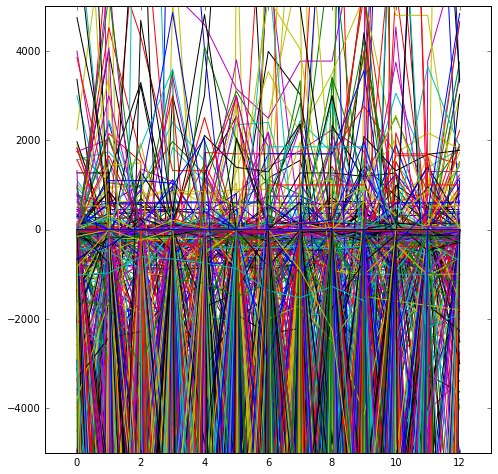

Iteracio: 4
3409.0 [-734.99991618]
[-1282.72302035] [-187.27681201]
[-1808.53720035] [ 338.537368]
10296.324587
Iteracio: 9
-8700.0 [-2237.5]
[-2869.95553203] [-1605.04446797]
[-3477.11284279] [-997.88715721]
13656.1341528
Iteracio: 13
-30000.0 [ 0.]
[-632.45553203] [ 632.45553203]
[-1239.61284279] [ 1239.61284279]
17000.0
Iteracio: 20
0.0 [-3125.]
[-3757.45553203] [-2492.54446797]
[-4364.61284279] [-1885.38715721]
38910.1529167
Iteracio: 23
-113146.0 [-8952.5]
[-9500.22414724] [-8404.77585276]
[-10026.0393286] [-7878.9606714]
156053.974714
Iteracio: 24
0.0 [-7067.75]
[-7700.20553203] [-6435.29446797]
[-8307.36284279] [-5828.13715721]
80610.7309048
Iteracio: 34
0.0 [-2875.]
[-3507.45553203] [-2242.54446797]
[-4114.61284279] [-1635.38715721]
25942.2435421
Iteracio: 40
-1920.0 [-40.23409845]
[-587.95666341] [ 507.48846651]
[-1113.77032577] [ 1033.30212888]
1978.63589374


/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 1, 'task': 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT', 'grad': array([ -1.14568829e-02,  -0.00000000e+00,  -1.14568045e-02,
        -5.84996227e-07,   5.14097403e-08,  -1.14568829e-02,
        -0.00000000e+00,  -8.85826420e+02]), 'nit': 834, 'funcalls': 15014}
  " state: %s" % convergence_dict)


Iteracio: 50
0.0 [-5862.5]
[-6494.95553203] [-5230.04446797]
[-7102.11284279] [-4622.88715721]
62756.8322974
Iteracio: 52
0.0 [-20000.]
[-20632.45553203] [-19367.54446797]
[-21239.61284279] [-18760.38715721]
369388.68418
Iteracio: 54
0.0 [-9750.]
[-10382.45553203] [-9117.54446797]
[-10989.61284279] [-8510.38715721]
147417.773691
Iteracio: 69
1000.0 [-697.]
[-1329.45553203] [-64.54446797]
[-1936.61284279] [ 542.61284279]
5343.19174277
Iteracio: 72
0.0 [-1295.51494808]
[-1843.23750559] [-747.79239056]
[-2369.0511608] [-221.97873535]
13628.3858178
Iteracio: 91
0.0 [-5261.25]
[-5893.70553203] [-4628.79446797]
[-6500.86284279] [-4021.63715721]
54163.6058622


/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 1, 'task': 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT', 'grad': array([ -1.41596028e-01,  -0.00000000e+00,  -1.41595096e-01,
        -6.90316889e-06,   6.08090881e-07,  -1.41596028e-01,
        -0.00000000e+00,  -1.09326503e+04]), 'nit': 834, 'funcalls': 15014}
  " state: %s" % convergence_dict)


Iteracio: 103
0.0 [-1250.]
[-1882.45553203] [-617.54446797]
[-2489.61284279] [-10.38715721]
12206.5556157
Iteracio: 109
0.0 [-8750.]
[-9382.45553203] [-8117.54446797]
[-9989.61284279] [-7510.38715721]
63560.9943283


/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 1, 'task': 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT', 'grad': array([ -1.25552068e+00,  -0.00000000e+00,  -9.84329889e+04,
        -8.45504935e-16,   2.63469831e-16,  -1.25552068e+00,
        -0.00000000e+00,  -9.84329889e+04]), 'nit': 834, 'funcalls': 15014}
  " state: %s" % convergence_dict)


Iteracio: 121
0.0 [-1625.]
[-2257.45553203] [-992.54446797]
[-2864.61284279] [-385.38715721]
87965.902485
Iteracio: 127
0.0 [-1750.]
[-2382.45553203] [-1117.54446797]
[-2989.61284279] [-510.38715721]
25709.9202644


/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 1, 'task': 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT', 'grad': array([ -5.09310248e-02,  -0.00000000e+00,  -5.09307314e-02,
        -2.48463597e-06,   2.18868247e-07,  -5.09310248e-02,
        -0.00000000e+00,  -3.93319425e+03]), 'nit': 834, 'funcalls': 15014}
  " state: %s" % convergence_dict)


Iteracio: 134
3491.0 [-116.75]
[-749.20553203] [ 515.70553203]
[-1356.36284279] [ 1122.86284279]
14122.4713843
Iteracio: 135
0.0 [-2125.]
[-2757.45553203] [-1492.54446797]
[-3364.61284279] [-885.38715721]
12955.3077926
Iteracio: 138
-6517.0 [-7871.125]
[-8503.58053203] [-7238.66946797]
[-9110.73784279] [-6631.51215721]
141431.830173
Iteracio: 140
0.0 [-25000.]
[-25632.45553203] [-24367.54446797]
[-26239.61284279] [-23760.38715721]
436568.436789
Iteracio: 144
0.0 [-2587.5]
[-3219.95553203] [-1955.04446797]
[-3827.11284279] [-1347.88715721]
26786.003808
Iteracio: 145
3000.0 [-7900.]
[-8532.45553203] [-7267.54446797]
[-9139.61284279] [-6660.38715721]
103062.55382
Iteracio: 147
-5800.0 [-625.]
[-1257.45553203] [ 7.45553203]
[-1864.61284279] [ 614.61284279]
7545.44902574
Iteracio: 150
-2500.0 [-700.]
[-1247.72255792] [-152.27744208]
[-1773.53621353] [ 373.53621353]
3789.4590643
Iteracio: 155
-364.0 [-3316.37500005]
[-3948.83053208] [-2683.91946801]
[-4555.98784283] [-2076.76215726]
17152.69

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 1, 'task': 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT', 'grad': array([ -2.86471068e-02,  -0.00000000e+00,  -2.86472918e-02,
         1.35659992e-06,  -1.37116728e-07,  -2.86471068e-02,
        -0.00000000e+00,  -2.17855826e+03]), 'nit': 834, 'funcalls': 15014}
  " state: %s" % convergence_dict)


Iteracio: 455
0.0 [-1875.]
[-2507.45553203] [-1242.54446797]
[-3114.61284279] [-635.38715721]
43324.3580449
Iteracio: 465
-30000.0 [-41.68247505]
[-589.4050326] [ 506.0400825]
[-1115.21868784] [ 1031.85373775]
80001.563616
Iteracio: 476
-339827.40625 [-98625.64453125]
[-99258.10006328] [-97993.18899922]
[-99865.25737404] [-97386.03168846]
803188.714984
Iteracio: 477
-1056.0 [ 3100.]
[ 2467.54446796] [ 3732.45553203]
[ 1860.38715721] [ 4339.61284278]
49508.2601593
Iteracio: 482
0.0 [-6250.]
[-6882.45553203] [-5617.54446797]
[-7489.61284279] [-5010.38715721]
61514.2259969
Iteracio: 483
0.0 [-5600.125]
[-6232.58053203] [-4967.66946797]
[-6839.73784279] [-4360.51215721]
27988.9805638
Iteracio: 485
0.0 [ 1494.5]
[ 862.04446797] [ 2126.95553203]
[ 254.88715721] [ 2734.11284279]
9126.77029403
Iteracio: 486
-60000.0 [ 0.]
[-632.45553203] [ 632.45553203]
[-1239.61284279] [ 1239.61284279]
12000.0
Iteracio: 488
-3000.0 [-1275.]
[-1907.45553203] [-642.54446797]
[-2514.61284279] [-35.38715721]
5924

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 1, 'task': 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT', 'grad': array([ -1.78222211e-02,  -0.00000000e+00,  -1.78221421e-02,
        -6.28055224e-07,   5.24800704e-08,  -1.78222211e-02,
        -0.00000000e+00,  -1.37739935e+03]), 'nit': 834, 'funcalls': 15014}
  " state: %s" % convergence_dict)


Iteracio: 649
-2300.0 [-920.375]
[-1552.83053203] [-287.91946797]
[-2159.98784279] [ 319.23784279]
4963.00161193
Iteracio: 658
-7860.0 [-909.]
[-1541.45553203] [-276.54446797]
[-2148.61284279] [ 330.61284279]
12496.6767582
Iteracio: 661
390.0 [-1609.125]
[-2241.58053203] [-976.66946797]
[-2848.73784279] [-369.51215721]
112656.652467
Iteracio: 662
-2000.0 [-4000.]
[-4632.45553203] [-3367.54446797]
[-5239.61284279] [-2760.38715721]
128035.151423
Iteracio: 664
0.0 [-10918.75]
[-11551.20553203] [-10286.29446797]
[-12158.36284279] [-9679.13715721]
126338.52342
Iteracio: 667
0.0 [-11302.375]
[-11934.83053203] [-10669.91946797]
[-12541.98784279] [-10062.76215721]
55038.6248011
Iteracio: 671
-20000.0 [ 0.]
[-632.45553203] [ 632.45553203]
[-1239.61284279] [ 1239.61284279]
0.0
Iteracio: 688
1905.0 [-102.375]
[-734.83053203] [ 530.08053203]
[-1341.98784279] [ 1137.23784279]
78559.8325927
Iteracio: 695
0.0 [-1381.25]
[-2013.70553203] [-748.79446797]
[-2620.86284279] [-141.63715721]
13393.7485418
I

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 1, 'task': 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT', 'grad': array([ -2.78781865e+00,  -0.00000000e+00,  -2.78780335e+00,
        -9.79600073e-05,   8.18550325e-06,  -2.78781865e+00,
        -0.00000000e+00,  -2.15223974e+05]), 'nit': 834, 'funcalls': 15014}
  " state: %s" % convergence_dict)


Iteracio: 751
4660.0 [ 1099.99999733]
[ 467.5444653] [ 1732.45552936]
[-139.61284546] [ 2339.61284011]
17876.303421
Iteracio: 752
0.0 [-1271.875]
[-1904.33053203] [-639.41946797]
[-2511.48784279] [-32.26215721]
12708.6938747
Iteracio: 755
0.0 [ 2031.75]
[ 1399.29446797] [ 2664.20553203]
[ 792.13715721] [ 3271.36284279]
19266.7973467
Iteracio: 770
-75000.0 [ 0.]
[-632.45553203] [ 632.45553203]
[-1239.61284279] [ 1239.61284279]
37000.0
Iteracio: 771
3750.0 [ 643.75]
[ 11.29446797] [ 1276.20553203]
[-595.86284279] [ 1883.36284279]
9548.56010087
Iteracio: 777
0.0 [-5000.]
[-5632.45553203] [-4367.54446797]
[-6239.61284279] [-3760.38715721]
58000.0
Iteracio: 778
0.0 [-2249.99999997]
[-2797.72299136] [-1702.27700857]
[-3323.5370631] [-1176.46293683]
51264.0224719
Iteracio: 781
-2419.0 [ 335.375]
[-297.08053203] [ 967.83053203]
[-904.23784279] [ 1574.98784279]
3964.49353638
Iteracio: 795
0.0 [-4125.00552216]
[-4757.4610542] [-3492.54999013]
[-5364.61836495] [-2885.39267938]
68315.444813
Iterac

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 1, 'task': 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT', 'grad': array([ -1.41470244e-02,  -0.00000000e+00,  -1.41469764e-02,
        -4.32710439e-07,   3.67026266e-08,  -1.41470244e-02,
        -0.00000000e+00,  -1.09341496e+03]), 'nit': 834, 'funcalls': 15014}
  " state: %s" % convergence_dict)


Iteracio: 802
-3391.0 [ 288.75]
[-343.70553203] [ 921.20553203]
[-950.86284279] [ 1528.36284279]
8308.26293517
Iteracio: 804
-1838.0 [-686.12499978]
[-1233.84823576] [-138.40176379]
[-1759.66254231] [ 387.41254275]
13956.9633875


/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 1, 'task': 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT', 'grad': array([ -1.43215897e-01,  -0.00000000e+00,  -1.43214927e-01,
        -6.98211145e-06,   6.15044825e-07,  -1.43215897e-01,
        -0.00000000e+00,  -1.10576834e+04]), 'nit': 834, 'funcalls': 15014}
  " state: %s" % convergence_dict)


Iteracio: 814
-7914.0 [-5274.75]
[-5822.4737327] [-4727.0262673]
[-6348.28851608] [-4201.21148392]
43842.4347408
Iteracio: 815
-3167.0 [-1354.6248698]
[-1987.08040183] [-722.16933777]
[-2594.23771259] [-115.01202701]
7303.90361382
Iteracio: 816
0.0 [-11437.875]
[-11985.59756179] [-10890.15243822]
[-12511.4112211] [-10364.33877891]
41199.1378308
Iteracio: 822
-1700.0 [-4080.]
[-4712.45553203] [-3447.54446797]
[-5319.61284279] [-2840.38715721]
34673.3919598
Iteracio: 831
-2730.0 [-661.25]
[-1293.70553203] [-28.79446797]
[-1900.86284279] [ 578.36284279]
4024.48754502
Iteracio: 833
-9500.0 [-4500.00000052]
[-5132.45553255] [-3867.54446848]
[-5739.6128433] [-3260.38715773]
24439.0589017
Iteracio: 837
-590.0 [-2631.25]
[-3263.70553203] [-1998.79446797]
[-3870.86284279] [-1391.63715721]
21314.1408459
Iteracio: 841
0.0 [-13750.]
[-14382.45553203] [-13117.54446797]
[-14989.61284279] [-12510.38715721]
163868.849999
Iteracio: 846
-54000.0 [-4500.]
[-5132.45553203] [-3867.54446797]
[-5739.61284279

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 1, 'task': 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT', 'grad': array([ -2.26308898e-02,  -0.00000000e+00,  -2.26307824e-02,
        -1.12135022e-06,   9.88647826e-08,  -2.26308898e-02,
        -0.00000000e+00,  -1.74840781e+03]), 'nit': 834, 'funcalls': 15014}
  " state: %s" % convergence_dict)
/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 1, 'task': 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT', 'grad': array([ -2.21318603e-02,  -0.00000000e+00,  -2.21319247e-02,
         4.24265945e-07,  -4.58918776e-08,  -2.21318603e-02,
        -0.00000000e+00,  -1.68336705e+03]), 'nit': 834, 'funcalls': 15014}
  " state: %s" % convergence_dict)


Iteracio: 887
0.0 [-3750.]
[-4382.45553203] [-3117.54446797]
[-4989.61284279] [-2510.38715721]
31112.6983722
Iteracio: 889
0.0 [-15250.]
[-15882.45553203] [-14617.54446797]
[-16489.61284279] [-14010.38715721]
132431.114169
Iteracio: 893
0.0 [-6508.25]
[-7140.70553203] [-5875.79446797]
[-7747.86284279] [-5268.63715721]
113109.727592
Iteracio: 894
0.0 [-2250.]
[-2882.45553203] [-1617.54446797]
[-3489.61284279] [-1010.38715721]
102396.288995
Iteracio: 897
-2527.0 [ 279.5]
[-352.95553203] [ 911.95553203]
[-960.11284279] [ 1519.11284279]
52043.1849237
Iteracio: 899
0.0 [-1500.]
[-2132.45553203] [-867.54446797]
[-2739.61284279] [-260.38715721]
21377.5583264
Iteracio: 900
0.0 [-12500.]
[-13132.45553203] [-11867.54446797]
[-13739.61284279] [-11260.38715721]
319455.787238
Iteracio: 902
0.0 [-2250.]
[-2882.45553203] [-1617.54446797]
[-3489.61284279] [-1010.38715721]
12489.9959968
Iteracio: 910
0.0 [-3124.99995271]
[-3757.45548474] [-2492.54442067]
[-4364.61279549] [-1885.38710992]
70498.2269281


/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 1, 'task': 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT', 'grad': array([ -2.49084598e-03,  -0.00000000e+00,  -2.49082998e-03,
        -1.29228351e-07,   1.13566475e-08,  -2.49084598e-03,
        -0.00000000e+00,  -1.93611705e+02]), 'nit': 834, 'funcalls': 15014}
  " state: %s" % convergence_dict)


Iteracio: 1008
0.0 [-4875.]
[-5507.45553203] [-4242.54446797]
[-6114.61284279] [-3635.38715721]
49829.7100132
Iteracio: 1014
-25330.0 [-15609.375]
[-16241.83053203] [-14976.91946797]
[-16848.98784279] [-14369.76215721]
85463.919861
Iteracio: 1019
70.0 [-1745.5]
[-2377.95553203] [-1113.04446797]
[-2985.11284279] [-505.88715721]
11130.7267058
Iteracio: 1034
0.0 [-7500.]
[-8132.45553203] [-6867.54446797]
[-8739.61284279] [-6260.38715721]
109836.241742
Iteracio: 1042
0.0 [-6817.5]
[-7449.95553203] [-6185.04446797]
[-8057.11284279] [-5577.88715721]
65231.3551676


/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 1, 'task': 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT', 'grad': array([ -6.35378128e-03,  -0.00000000e+00,  -6.35374445e-03,
        -3.43247732e-07,   3.02660041e-08,  -6.35378128e-03,
        -0.00000000e+00,  -4.91867439e+02]), 'nit': 834, 'funcalls': 15014}
  " state: %s" % convergence_dict)


Iteracio: 1069
-4033.0 [-1951.99999986]
[-2499.72294998] [-1404.27704974]
[-3025.5369821] [-878.46301762]
74082.5083944
Iteracio: 1074
0.0 [-8749.99999999]
[-9382.45553202] [-8117.54446795]
[-9989.61284277] [-7510.3871572]
67438.8612003
Iteracio: 1077
0.0 [-14875.]
[-15507.45553203] [-14242.54446797]
[-16114.61284279] [-13635.38715721]
180590.697435


/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 1, 'task': 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT', 'grad': array([ -5.66591933e-01,  -0.00000000e+00,  -5.66588089e-01,
        -2.76152242e-05,   2.43258803e-06,  -5.66591933e-01,
        -0.00000000e+00,  -4.37426002e+04]), 'nit': 834, 'funcalls': 15014}
  " state: %s" % convergence_dict)


Iteracio: 1081
0.0 [-2250.]
[-2882.45553203] [-1617.54446797]
[-3489.61284279] [-1010.38715721]
20223.7484162
Iteracio: 1087
0.0 [-10625.]
[-11257.45553203] [-9992.54446797]
[-11864.61284279] [-9385.38715721]
145371.936769
Iteracio: 1102
0.0 [-2250.]
[-2882.45553203] [-1617.54446797]
[-3489.61284279] [-1010.38715721]
21633.3076528
Iteracio: 1103
0.0 [-2831.25]
[-3378.97256006] [-2283.52743994]
[-3904.78621772] [-1757.71378228]
12650.0
Iteracio: 1104
50000.0 [-946.375]
[-1578.83053203] [-313.91946797]
[-2185.98784279] [ 293.23784279]
65823.0911003
Iteracio: 1112
0.0 [-2805.75]
[-3438.20553203] [-2173.29446797]
[-4045.36284279] [-1566.13715721]
34098.6873208
Iteracio: 1113
0.0 [-1477.5]
[-2109.95553203] [-845.04446797]
[-2717.11284279] [-237.88715721]
39325.9867772
Iteracio: 1129
0.0 [-1459.]
[-2091.45553203] [-826.54446797]
[-2698.61284279] [-219.38715721]
13275.3750983
Iteracio: 1151
0.0 [-3749.99999905]
[-4382.45553108] [-3117.54446701]
[-4989.61284183] [-2510.38715626]
44271.8872424


/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 1, 'task': 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT', 'grad': array([ -5.69535880e-03,  -0.00000000e+00,  -5.69532646e-03,
        -2.92127652e-07,   2.56723138e-08,  -5.69535880e-03,
        -0.00000000e+00,  -4.41023030e+02]), 'nit': 834, 'funcalls': 15014}
  " state: %s" % convergence_dict)


Iteracio: 1312
0.0 [-5000.]
[-5632.45553203] [-4367.54446797]
[-6239.61284279] [-3760.38715721]
63316.6644731
Iteracio: 1316
1152.0 [-117.125]
[-749.58053203] [ 515.33053203]
[-1356.73784279] [ 1122.48784279]
30557.5657571
Iteracio: 1321
0.0 [-5843.375]
[-6391.09755751] [-5295.65244249]
[-6916.91121273] [-4769.83878727]
47828.7509768
Iteracio: 1326
0.0 [-2122.5]
[-2754.95553203] [-1490.04446797]
[-3362.11284279] [-882.88715721]
19621.1425508
Iteracio: 1329
0.0 [-2500.]
[-3132.45553203] [-1867.54446797]
[-3739.61284279] [-1260.38715721]
28635.6421266
Iteracio: 1331
0.0 [-5000.]
[-5632.45553203] [-4367.54446797]
[-6239.61284279] [-3760.38715721]
98711.701434
Iteracio: 1338
-10000.0 [ 0.]
[-632.45553203] [ 632.45553203]
[-1239.61284279] [ 1239.61284279]
49000.0
Iteracio: 1354
0.0 [-6288.75]
[-6921.20553203] [-5656.29446797]
[-7528.36284279] [-5049.13715721]
82010.9581458


/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 1, 'task': 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT', 'grad': array([ -5.39569070e-03,  -0.00000000e+00,  -5.39566974e-03,
        -1.90492264e-07,   1.59246932e-08,  -5.39569070e-03,
        -0.00000000e+00,  -4.18024895e+02]), 'nit': 834, 'funcalls': 15014}
  " state: %s" % convergence_dict)


Iteracio: 1356
-1800.0 [-3316.]
[-3948.45553203] [-2683.54446797]
[-4555.61284279] [-2076.38715721]
178631.643045
Iteracio: 1359
-30000.0 [-2500.]
[-3132.45553203] [-1867.54446797]
[-3739.61284279] [-1260.38715721]
83642.0946653
Iteracio: 1363
1489.0 [-44.24959767]
[-676.70512971] [ 588.20593436]
[-1283.86244046] [ 1195.36324511]
2434.93367466
Iteracio: 1364
-300.0 [-1740.125]
[-2372.58053203] [-1107.66946797]
[-2979.73784279] [-500.51215721]
10435.112697


/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 1, 'task': 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT', 'grad': array([ -1.28843441e-02,  -0.00000000e+00,  -1.28843225e-02,
        -1.30724424e-07,   8.75108585e-09,  -1.28843441e-02,
        -0.00000000e+00,  -9.95922537e+02]), 'nit': 834, 'funcalls': 15014}
  " state: %s" % convergence_dict)


Iteracio: 1374
1000.0 [ 3078.125]
[ 2445.66946797] [ 3710.58053203]
[ 1838.51215721] [ 4317.73784279]
94271.0251032
Iteracio: 1382
-15369.0 [-419.5]
[-967.22256728] [ 128.22256728]
[-1493.03623188] [ 654.03623188]
2043.95768058
Iteracio: 1384
-991.0 [ 675.625]
[ 43.16946796] [ 1308.08053203]
[-563.98784279] [ 1915.23784278]
7819.14745992
Iteracio: 1385
3361.0 [-1197.875]
[-1830.33053203] [-565.41946797]
[-2437.48784279] [ 41.73784279]
23392.2708603
Iteracio: 1408
0.0 [-1888.25]
[-2520.70553203] [-1255.79446797]
[-3127.86284279] [-648.63715721]
27897.3517919
Iteracio: 1424
0.0 [-23375.]
[-24007.45553203] [-22742.54446797]
[-24614.61284279] [-22135.38715721]
171764.373489
Iteracio: 1425
0.0 [-1750.]
[-2382.45553203] [-1117.54446797]
[-2989.61284279] [-510.38715721]
18973.665961
Iteracio: 1434
0.0 [-2350.]
[-2982.45553203] [-1717.54446797]
[-3589.61284279] [-1110.38715721]
100780.355229
Iteracio: 1435
4840.0 [ 294.62500086]
[-337.83053117] [ 927.0805329]
[-944.98784192] [ 1534.23784365]
3

array([ 0.29370281])

In [25]:
#Llegim les comptes del 32è cluster
accountcluster32=np.zeros((len(assignmentsclus[31]),13))
for i in np.arange(len(assignmentsclus[31])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster32[i]=accountclean[assignmentsclus[31][i].astype(int)]

print accountcluster32.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster32.shape[0]):
        plt.plot(accountcluster32[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 3640.0**2 * RBF(length_scale=675.0)  # long term smooth rising trend
#k2 = 3.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k3 = 45.5**2* RationalQuadratic(length_scale=32.0, alpha=0.5)
k4 = 0.5**2 * RBF(length_scale=0.6) \
    + WhiteKernel(noise_level=10.2**2)  # noise terms
kernel_gpmlini = k1+k3+k4


gp32 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster32,accountcluster32.shape[0],gp32,31)

(3770, 13)


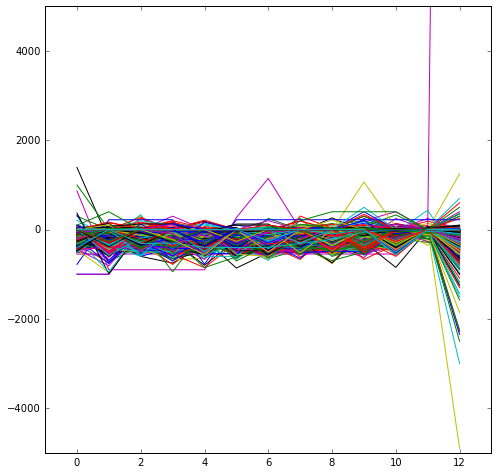

Iteracio: 2
-300.0 [-31.25]
[-113.92972777] [ 51.42972777]
[-193.30226642] [ 130.80226642]
101.212647431
Iteracio: 13
-28.0 [-329.76119098]
[-444.80496734] [-214.71741463]
[-555.24699264] [-104.27538932]
547.104194829
Iteracio: 19
-7.0 [ 0.]
[-0.00334665] [ 0.00334665]
[-0.00655943] [ 0.00655943]
118.0
Iteracio: 21
-60.0 [ 0.]
[-0.00334664] [ 0.00334664]
[-0.00655941] [ 0.00655941]
246.0
Iteracio: 63
-50.0 [ 0.]
[-0.00334664] [ 0.00334664]
[-0.00655941] [ 0.00655941]
49.0
Iteracio: 71
-15.0 [-1.875]
[-6.83579809] [ 3.08579809]
[-11.59816425] [ 7.84816425]
64.7610994348
Iteracio: 76
-111.0 [-44.58917311]
[-61.44978295] [-27.72856328]
[-77.63596839] [-11.54237783]
86.0232526704
Iteracio: 85
91.0 [ 4.99997712]
[-8.22871513] [ 18.22866937]
[-20.92825969] [ 30.92821393]
397.461947864
Iteracio: 87
701.0 [ 24.24999419]
[-39.91235789] [ 88.41234626]
[-101.50821588] [ 150.00820425]
265.392162657
Iteracio: 92
-19.0 [-2.37500016]
[-8.65865824] [ 3.90865793]
[-14.69097001] [ 9.94096969]
62.1128006

Iteracio: 1058
-464.0 [ 0.]
[-0.00334664] [ 0.00334664]
[-0.00655941] [ 0.00655941]
144.0
Iteracio: 1073
-270.0 [ 0.]
[-0.00572078] [ 0.00572078]
[-0.01121272] [ 0.01121272]
40.0
Iteracio: 1082
-500.0 [-232.37496638]
[-331.69505719] [-133.05487558]
[-427.04234437] [-37.7075884]
515.736366761
Iteracio: 1095
-64.0 [ 0.]
[-0.00471405] [ 0.00471405]
[-0.00923954] [ 0.00923954]
165.0
Iteracio: 1097
-300.0 [-37.49999566]
[-136.71567379] [ 61.71568247]
[-231.96272479] [ 156.96273348]
87.7610391917
Iteracio: 1117
-332.0 [ 0.]
[-0.00471405] [ 0.00471405]
[-0.00923953] [ 0.00923953]
207.0
Iteracio: 1134
-263.0 [ 0.]
[-0.00334664] [ 0.00334664]
[-0.00655941] [ 0.00655941]
28.0
Iteracio: 1137
-153.0 [ 0.]
[-0.00334664] [ 0.00334664]
[-0.00655941] [ 0.00655941]
161.0
Iteracio: 1160
-278.0 [-6.12497896]
[-22.3308304] [ 10.08087248]
[-37.88844778] [ 25.63848986]
136.747943312
Iteracio: 1164
-160.0 [-17.4999991]
[-40.27621278] [ 5.27621459]
[-62.14137792] [ 27.14137972]
81.4616474177
Iteracio: 1173
40

Iteracio: 2070
-137.0 [-28.]
[-75.32079082] [ 19.32079082]
[-120.74875001] [ 64.74875001]
212.960090158
Iteracio: 2071
-458.0 [-252.]
[-264.14445687] [-239.85554313]
[-275.80313546] [-228.19686454]
329.387310017
Iteracio: 2072
-160.0 [ 0.]
[-0.00572078] [ 0.00572078]
[-0.01121272] [ 0.01121272]
47.0
Iteracio: 2117
-370.0 [-2.49999989]
[-9.11434566] [ 4.11434587]
[-15.46411759] [ 10.46411781]
103.735239914
Iteracio: 2120
-370.0 [ 0.]
[-0.00334664] [ 0.00334664]
[-0.00655941] [ 0.00655941]
37.0
Iteracio: 2121
-853.0 [-3.75000052]
[-10.41628548] [ 2.91628444]
[-16.81591905] [ 9.31591801]
117.017092769
Iteracio: 2125
-283.0 [-53.74998375]
[-140.39834103] [ 32.89837353]
[-223.58076401] [ 116.08079651]
101.163234428
Iteracio: 2129
-362.0 [ 0.]
[-0.00334664] [ 0.00334664]
[-0.00655941] [ 0.00655941]
101.0
Iteracio: 2146
-200.0 [ 0.]
[-0.00471409] [ 0.00471409]
[-0.00923962] [ 0.00923962]
81.0
Iteracio: 2152
-366.0 [-45.7499962]
[-166.79312008] [ 75.29312768]
[-282.994519] [ 191.4945266]
94.50

Iteracio: 2954
19.0 [ 1.11685735]
[-6.59719486] [ 8.83090955]
[-14.00268497] [ 16.23639967]
175.2740711
Iteracio: 2960
-140.0 [-303.75]
[-367.57345182] [-239.92654818]
[-428.84396557] [-178.65603443]
387.309953397
Iteracio: 2975
-187.0 [ 0.]
[-0.00572078] [ 0.00572078]
[-0.01121272] [ 0.01121272]
23.0
Iteracio: 2978
-32.0 [-1.82912461]
[-5.81020982] [ 2.15196059]
[-9.63205162] [ 5.9738024]
108.990825302
Iteracio: 2989
-365.0 [ 0.]
[-0.00334664] [ 0.00334664]
[-0.00655941] [ 0.00655941]
8.0
Iteracio: 3001
-1857.0 [ 0.]
[-0.00471405] [ 0.00471405]
[-0.00923953] [ 0.00923953]
36.0
Iteracio: 3031
-234.0 [ 0.]
[-0.00471405] [ 0.00471405]
[-0.00923953] [ 0.00923953]
66.0
Iteracio: 3033
-250.0 [ 0.]
[-0.00334664] [ 0.00334664]
[-0.00655941] [ 0.00655941]
19.0
Iteracio: 3042
-40.0 [-6.25]
[-22.78601965] [ 10.28601965]
[-38.66059852] [ 26.16059852]
94.1328847959
Iteracio: 3043
-21.0 [ 0.]
[-0.00334667] [ 0.00334667]
[-0.00655947] [ 0.00655947]
72.256487598
Iteracio: 3048
-263.0 [-5.49999955]
[-

array([ 0.63133891])

In [63]:
#Llegim les comptes del 33è cluster
accountcluster33=np.zeros((len(assignmentsclus[32]),13))
for i in np.arange(len(assignmentsclus[32])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster33[i]=accountclean[assignmentsclus[32][i].astype(int)]

print accountcluster33.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster33.shape[0]):
        plt.plot(accountcluster33[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 240.0**2 * RBF(length_scale=65.0)  # long term smooth rising trend
k2 = 3.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k3 = 4.5**2* RationalQuadratic(length_scale=2.0, alpha=0.8)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=13.2**2)  # noise terms
kernel_gpmlini = k1+k2+k3+k4


gp33 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster33,accountcluster33.shape[0],gp33,32)

(1838, 13)


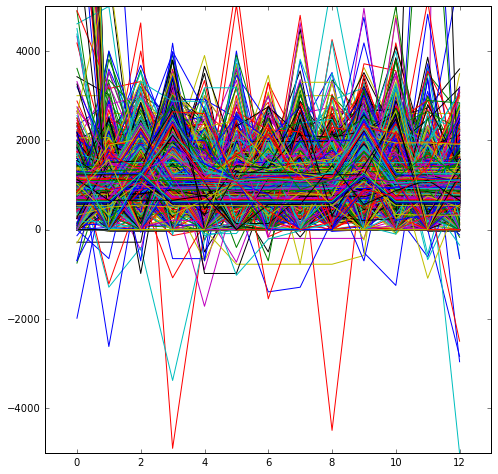

Iteracio: 7
1465.0 [ 1333.74999252]
[ 1284.14319827] [ 1383.35678678]
[ 1236.52067578] [ 1430.97930927]
1536.78202748
Iteracio: 31
1492.0 [ 1134.37499963]
[ 1102.56326875] [ 1166.18673052]
[ 1072.0240071] [ 1196.72599217]
1157.05401775
Iteracio: 63
3197.0 [ 837.2502519]
[ 204.79471987] [ 1469.70578393]
[-402.36259089] [ 2076.86309468]
2468.86674408
Iteracio: 68
1486.0 [ 374.5]
[-72.71361443] [ 821.71361443]
[-502.03868428] [ 1251.03868428]
2904.32160754
Iteracio: 70
900.0 [ 672.5]
[ 615.54601926] [ 729.45398074]
[ 560.87019775] [ 784.12980225]
1413.37468493
Iteracio: 80
2825.0 [ 1362.87500416]
[ 1301.88840425] [ 1423.86160408]
[ 1243.34126834] [ 1482.40873999]
2017.01611297
Iteracio: 93
2130.0 [ 1193.75]
[ 1105.5821754] [ 1281.9178246]
[ 1020.94106378] [ 1366.55893621]
1384.32221683
Iteracio: 97
3600.0 [ 2108.26623865]
[ 1482.11155568] [ 2734.42092162]
[ 881.00306002] [ 3335.52941728]
3263.66435161
Iteracio: 101
1771.0 [ 446.25003905]
[-0.96405649] [ 893.4641346]
[-430.28958821] [ 1322

Iteracio: 734
2553.0 [ 1038.28156569]
[ 492.12464268] [ 1584.43848869]
[-32.1860034] [ 2108.74913477]
2798.15635732
Iteracio: 735
1750.0 [ 1531.2499775]
[ 1448.57110547] [ 1613.92884953]
[ 1369.19938832] [ 1693.30056668]
1860.46983313
Iteracio: 749
2110.0 [ 908.125]
[ 360.40244242] [ 1455.84755758]
[-165.41121286] [ 1981.66121286]
2850.41698704
Iteracio: 755
0.0 [ 904.625]
[ 878.87166286] [ 930.37833714]
[ 854.1484592] [ 955.1015408]
1587.18902466
Iteracio: 786
2160.0 [ 525.05705663]
[-107.3984752] [ 1157.51258846]
[-714.55578576] [ 1764.66989901]
3744.54963914
Iteracio: 792
0.0 [ 862.50000001]
[ 435.48294889] [ 1289.51705113]
[ 25.54657981] [ 1699.4534202]
1872.32155358
Iteracio: 794
0.0 [ 1207.375]
[ 857.91546358] [ 1556.83453642]
[ 522.43430862] [ 1892.31569138]
1231.83318676
Iteracio: 800
-2500.0 [ 1059.50001288]
[ 427.04448084] [ 1691.95554491]
[-180.11282991] [ 2299.11285566]
5468.69655402
Iteracio: 801
1141.0 [ 601.]
[ 600.99665336] [ 601.00334664]
[ 600.99344059] [ 601.00655941

Iteracio: 1521
2340.0 [ 1309.25]
[ 1008.05966208] [ 1610.44033792]
[ 718.91693768] [ 1899.58306232]
1631.61545715
Iteracio: 1539
1600.0 [ 806.24999538]
[ 503.72165222] [ 1108.77833854]
[ 213.29444279] [ 1399.20554798]
1580.97817822
Iteracio: 1545
2970.0 [ 1049.75005272]
[ 636.90796021] [ 1462.59214523]
[ 240.57955139] [ 1858.92055404]
1692.97666847
Iteracio: 1546
0.0 [ 704.50000877]
[ 488.91550696] [ 920.08451057]
[ 281.95438523] [ 1127.0456323]
1419.14199431
Iteracio: 1554
1800.0 [ 724.62496834]
[ 423.99694191] [ 1025.25299477]
[ 135.39403654] [ 1313.85590014]
1377.36160829
Iteracio: 1556
2200.0 [ 831.24999965]
[ 283.52709476] [ 1378.97290453]
[-242.28689392] [ 1904.78689322]
2650.99679366
Iteracio: 1562
1820.0 [ 651.03583167]
[ 111.88942329] [ 1190.18224004]
[-405.69112875] [ 1707.76279208]
2151.57058913
Iteracio: 1563
1610.0 [ 1060.625]
[ 913.9295238] [ 1207.3204762]
[ 773.10186665] [ 1348.14813335]
937.037886107
Iteracio: 1573
1000.0 [ 681.25]
[ 564.15628787] [ 798.34371213]
[ 451.

array([ 0.56705468])

In [64]:
#Llegim les comptes del 34è cluster
accountcluster34=np.zeros((len(assignmentsclus[33]),13))
for i in np.arange(len(assignmentsclus[33])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster34[i]=accountclean[assignmentsclus[33][i].astype(int)]

print accountcluster34.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster34.shape[0]):
        plt.plot(accountcluster34[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 1740.0**2 * RBF(length_scale=459.0)  # long term smooth rising trend
k2 = 3.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k3 = 45.5**2* RationalQuadratic(length_scale=25.0, alpha=0.8)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=13.2**2)  # noise terms
kernel_gpmlini = k1+k2+ k3+k4


gp34 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster34,accountcluster34.shape[0],gp34,33)

(968, 13)


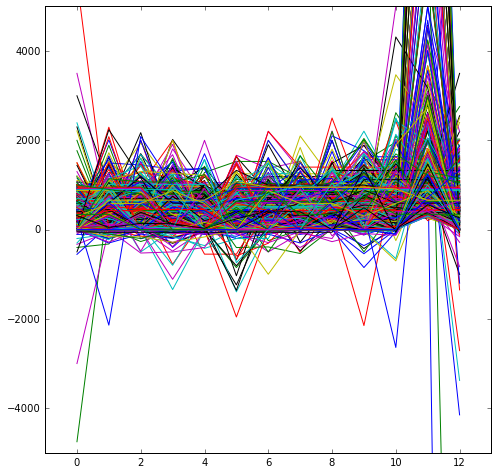

Iteracio: 2
1630.0 [ 1004.05206034]
[ 823.30197055] [ 1184.80215012]
[ 649.78188436] [ 1358.32223632]
2546.00805183
Iteracio: 4
600.0 [ 93.75]
[-135.97468039] [ 323.47468039]
[-356.51037356] [ 544.01037356]
621.470031458
Iteracio: 8
1000.0 [ 0.]
[-0.00471405] [ 0.00471405]
[-0.00923953] [ 0.00923953]
342.05262753
Iteracio: 15
1233.0 [ 0.]
[-0.00572078] [ 0.00572078]
[-0.01121272] [ 0.01121272]
955.33763665
Iteracio: 22
703.0 [ 384.88978227]
[ 287.84897374] [ 481.9305908]
[ 194.68979755] [ 575.08976699]
611.588096679
Iteracio: 23
624.0 [ 0.]
[-0.00471406] [ 0.00471406]
[-0.00923957] [ 0.00923957]
326.632821376
Iteracio: 25
925.0 [ 856.51422253]
[ 826.70870949] [ 886.31973557]
[ 798.09541697] [ 914.93302809]
1982.20987789
Iteracio: 48
2200.0 [ 156.25000007]
[-49.05057105] [ 361.55057119]
[-246.13911932] [ 558.63911947]
599.166087158
Iteracio: 49
1317.0 [ 0.]
[-0.00572082] [ 0.00572082]
[-0.0112128] [ 0.0112128]
1931.1626032
Iteracio: 50
943.0 [ 4.5]
[-7.40593044] [ 16.40593044]
[-18.8356

Iteracio: 319
1085.0 [ 663.49983425]
[ 510.02965293] [ 816.97001557]
[ 362.69827886] [ 964.30138964]
652.216988433
Iteracio: 326
0.0 [ 586.90795127]
[ 565.8578665] [ 607.95803604]
[ 545.64978512] [ 628.16611741]
275.23262888
Iteracio: 341
1662.0 [ 236.]
[-328.27742813] [ 800.27742813]
[-869.98375914] [ 1341.98375914]
3489.00788191
Iteracio: 346
1063.0 [ 258.125]
[-117.70493292] [ 633.95493292]
[-478.50166852] [ 994.75166852]
1277.57465535
Iteracio: 358
502.0 [ 1315.625]
[ 915.38846086] [ 1715.86153914]
[ 531.16138328] [ 2100.08861671]
5516.01078679
Iteracio: 364
1400.0 [ 0.]
[-0.00572078] [ 0.00572078]
[-0.01121273] [ 0.01121273]
1371.19983956
Iteracio: 367
425.0 [ 0.]
[-0.00334665] [ 0.00334665]
[-0.00655944] [ 0.00655944]
237.200337268
Iteracio: 376
0.0 [ 619.625]
[ 577.57759299] [ 661.67240701]
[ 537.21208226] [ 702.03791774]
327.757532331
Iteracio: 383
1267.0 [ 490.00000089]
[ 304.79686096] [ 675.20314081]
[ 127.00184663] [ 852.99815514]
448.107130048
Iteracio: 391
1247.0 [ 250.000

Iteracio: 738
564.0 [ 70.49999261]
[-59.511194] [ 200.51117922]
[-184.32193315] [ 325.32191837]
2037.53453958
Iteracio: 739
1300.0 [ 568.7500082]
[ 353.78276182] [ 783.71725457]
[ 147.4142053] [ 990.0858111]
1516.41023473
Iteracio: 746
1800.0 [ 503.00008971]
[ 161.70638275] [ 844.29379668]
[-165.93557594] [ 1171.93575536]
998.507386052
Iteracio: 752
-3380.0 [  1.30015716e-12]
[-491.30530265] [ 491.30530265]
[-962.9583932] [ 962.9583932]
2477.50176589
Iteracio: 758
201.0 [ 0.]
[-0.00572078] [ 0.00572078]
[-0.01121272] [ 0.01121272]
892.415262084
Iteracio: 764
0.0 [ 573.0000035]
[ 337.05012163] [ 808.94988538]
[ 110.53823502] [ 1035.46177199]
1415.61294145
Iteracio: 766
156.0 [ 401.65835843]
[ 348.24455855] [ 455.0721583]
[ 296.96731067] [ 506.34940619]
411.933247019
Iteracio: 770
984.0 [ 0.]
[-0.00471406] [ 0.00471406]
[-0.00923956] [ 0.00923956]
656.667343485
Iteracio: 778
322.0 [ 581.75]
[ 522.8820297] [ 640.6179703]
[ 466.36877821] [ 697.13122179]
739.064273254
Iteracio: 779
0.0 [ 87

array([ 1.47633169])

In [65]:
#Llegim les comptes del 35è cluster
accountcluster35=np.zeros((len(assignmentsclus[34]),13))
for i in np.arange(len(assignmentsclus[34])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster35[i]=accountclean[assignmentsclus[34][i].astype(int)]

print accountcluster35.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster35.shape[0]):
        plt.plot(accountcluster35[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 1250.0**2 * RBF(length_scale=420.0)  # long term smooth rising trend
k2 = 3.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k3 = 32.5**2* RationalQuadratic(length_scale=19.0, alpha=0.9)
k4 = 1.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=13.2**2)  # noise terms
kernel_gpmlini = k1+k2+k3+k4


gp35 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster35,accountcluster35.shape[0],gp35,34)

(4437, 13)


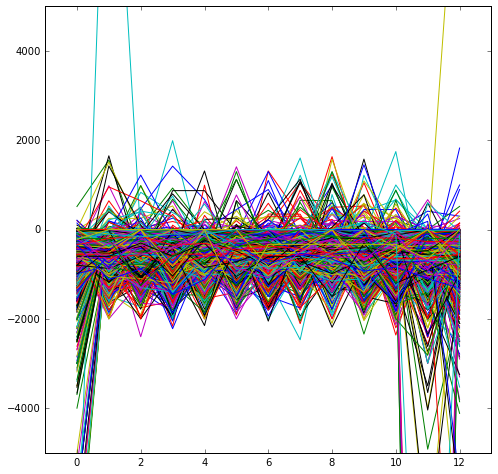

Iteracio: 9
-478.0 [-361.125]
[-417.29314293] [-304.95685707]
[-471.21456014] [-251.03543986]
672.210532497
Iteracio: 13
-8.0 [-291.25]
[-358.49907305] [-224.00092695]
[-423.05818319] [-159.44181681]
681.981671308
Iteracio: 34
-1324.0 [-447.32465855]
[-620.69024365] [-273.95907346]
[-787.12120534] [-107.52811176]
683.054170619
Iteracio: 46
0.0 [-298.69315587]
[-438.37798033] [-159.0083314]
[-572.47541182] [-24.91089992]
484.045452411
Iteracio: 47
-758.0 [-536.25]
[-591.20851004] [-481.29148996]
[-643.96867969] [-428.53132031]
994.982914426
Iteracio: 51
-1400.0 [-488.75]
[-736.25950531] [-241.24049469]
[-973.8686304] [-3.6313696]
872.582374335
Iteracio: 52
-442.0 [-263.75]
[-346.75027279] [-180.74972721]
[-426.43053467] [-101.06946533]
634.511623219
Iteracio: 66
-830.0 [-198.47012108]
[-372.25535172] [-24.68489044]
[-539.08917314] [ 142.14893097]
552.086949674
Iteracio: 72
-1250.0 [-463.75000002]
[-668.86817587] [-258.63182417]
[-865.78162468] [-61.71837536]
983.361581515
Iteracio: 110


Iteracio: 549
-46.0 [-428.74998143]
[-547.05148144] [-310.44848141]
[-660.62092146] [-196.8790414]
570.867760519
Iteracio: 552
-1100.0 [-587.5]
[-770.78617195] [-404.21382805]
[-946.74089703] [-228.25910297]
1306.06278563
Iteracio: 553
-590.0 [-192.29109215]
[-264.67158526] [-119.91059904]
[-334.15685864] [-50.42532566]
530.612853218
Iteracio: 560
-900.0 [-218.74998541]
[-447.79337249] [ 10.29340167]
[-667.67502408] [ 230.17505327]
730.47929471
Iteracio: 568
-830.0 [-255.875]
[-538.19991332] [ 26.44991333]
[-809.23183011] [ 297.48183012]
663.446305288
Iteracio: 571
-250.0 [-472.37499996]
[-494.13469608] [-450.61530385]
[-515.02400435] [-429.72599557]
717.504703817
Iteracio: 576
-1193.0 [-284.87508135]
[-408.90557129] [-160.8445914]
[-527.97484164] [-41.77532106]
706.817515346
Iteracio: 582
-1828.0 [-627.00000018]
[-1076.48366049] [-177.51633987]
[-1507.98797439] [ 253.98797403]
4759.94138619
Iteracio: 590
-611.0 [-330.5]
[-448.93247057] [-212.06752943]
[-562.62764231] [-98.37235769]
55

Iteracio: 1083
-1050.0 [-275.]
[-520.53441447] [-29.46558553]
[-756.24745236] [ 206.24745236]
941.277854834
Iteracio: 1093
0.0 [-418.75]
[-601.1904562] [-236.3095438]
[-776.33329414] [-61.16670585]
1546.70617766
Iteracio: 1096
-1220.0 [-505.00001082]
[-700.64024117] [-309.35978048]
[-888.4548623] [-121.54515934]
1203.91029566
Iteracio: 1097
-800.0 [-150.]
[-343.6535534] [ 43.65355339]
[-529.56096466] [ 229.56096465]
728.971878744
Iteracio: 1106
-1520.0 [-527.375]
[-848.71396194] [-206.03603806]
[-1157.19936541] [ 102.44936541]
1284.6373029
Iteracio: 1109
-605.0 [-150.75]
[-363.94284125] [ 62.44284125]
[-568.60796885] [ 267.10796885]
629.143862721
Iteracio: 1125
-619.0 [-624.50309084]
[-625.52574578] [-623.48043591]
[-626.50749452] [-622.49868717]
1344.35337616
Iteracio: 1134
-600.0 [-395.89939037]
[-478.36197469] [-313.43680605]
[-557.52605564] [-234.2727251]
675.425791631
Iteracio: 1135
-1000.0 [-466.25212513]
[-697.41543846] [-235.08881181]
[-919.33221925] [-13.17203102]
640.54664154

Iteracio: 1509
0.0 [-759.30794494]
[-1129.13550584] [-389.48038404]
[-1484.1699643] [-34.44592557]
1650.94548668
Iteracio: 1528
-920.0 [-629.375]
[-662.97165748] [-595.77834251]
[-695.22444867] [-563.52555133]
2180.41097044
Iteracio: 1533
-356.0 [-335.]
[-339.06201882] [-330.93798118]
[-342.96155689] [-327.03844311]
710.152800459
Iteracio: 1534
-974.0 [-405.24994952]
[-588.06598574] [-222.43391329]
[-763.56938051] [-46.93051852]
700.975035219
Iteracio: 1543
-1067.0 [-466.5]
[-719.54643697] [-213.45356303]
[-962.47101646] [ 29.47101646]
798.263740878
Iteracio: 1553
-920.0 [-371.74992669]
[-473.60487994] [-269.89497345]
[-571.38563505] [-172.11421834]
731.458816339
Iteracio: 1564
-750.0 [-34.875]
[-97.05371176] [ 27.30371176]
[-156.74527505] [ 86.99527505]
2195.54366843
Iteracio: 1571
-1000.0 [-199.99999135]
[-512.24977083] [ 112.24978812]
[-812.00955913] [ 412.00957642]
974.371592361
Iteracio: 1584
-600.0 [-212.50000712]
[-329.09172459] [-95.90828965]
[-441.01977336] [ 16.01975912]
666.

Iteracio: 1986
-373.0 [-296.25]
[-329.84594987] [-262.65405013]
[-362.09806175] [-230.40193825]
603.778933054
Iteracio: 1988
-669.0 [-310.75]
[-386.53053497] [-234.96946503]
[-459.27984854] [-162.22015146]
503.053675069
Iteracio: 2000
-1219.0 [-193.11283876]
[-348.57021176] [-37.65546576]
[-497.80928983] [ 111.58361231]
526.070337503
Iteracio: 2001
-350.0 [-757.28592497]
[-828.80547857] [-685.76637138]
[-897.46425001] [-617.10759993]
750.901458249
Iteracio: 2009
-439.0 [-181.74999963]
[-284.46753346] [-79.03246579]
[-383.07636594] [ 19.57636669]
536.226631192
Iteracio: 2014
-1697.0 [-274.24998944]
[-654.44464683] [ 105.94466795]
[-1019.43151792] [ 470.93153904]
1225.78301506
Iteracio: 2015
-680.0 [-549.99999893]
[-600.99035525] [-499.00964261]
[-649.94109732] [-450.05890054]
748.1978348
Iteracio: 2019
-2100.0 [-512.48258358]
[-971.77891997] [-53.18624719]
[-1412.7034029] [ 387.73823575]
1576.89568457
Iteracio: 2028
-700.0 [-635.75]
[-667.57667906] [-603.92332094]
[-698.13029096] [-573.

Iteracio: 2368
-1800.0 [-293.74999248]
[-532.80736193] [-54.69262302]
[-762.30243661] [ 174.80245165]
835.763124336
Iteracio: 2374
-1018.0 [-435.25]
[-732.05581203] [-138.44418797]
[-1016.98939159] [ 146.48939159]
840.745502515
Iteracio: 2378
-700.0 [-392.50000156]
[-525.42407092] [-259.5759322]
[-653.0311775] [-131.96882562]
1126.27705295
Iteracio: 2379
-2000.0 [-249.99989963]
[-683.01288342] [ 183.01308417]
[-1098.70534785] [ 598.7055486]
1286.00155521
Iteracio: 2390
-1170.0 [-675.]
[-888.36590428] [-461.63409572]
[-1093.19717238] [-256.80282762]
1188.19190369
Iteracio: 2395
-1220.0 [-510.]
[-703.9716699] [-316.0283301]
[-890.184473] [-129.815527]
1354.84316436
Iteracio: 2400
-780.0 [-244.99999927]
[-385.00018496] [-104.99981358]
[-519.40036323] [ 29.40036469]
553.80501984
Iteracio: 2404
-539.0 [-193.125]
[-337.3639951] [-48.8860049]
[-475.83343039] [ 89.58343039]
519.913454336
Iteracio: 2415
-1116.0 [-277.87496723]
[-670.76155312] [ 115.01161866]
[-1047.93267557] [ 492.18274111]
103

Iteracio: 2863
-1260.0 [-458.75000001]
[-667.46120426] [-250.03879576]
[-867.82396035] [-49.67603967]
798.56120617
Iteracio: 2864
-505.0 [-235.875]
[-359.01669119] [-112.73330881]
[-477.23271473] [ 5.48271473]
571.281016663
Iteracio: 2887
-1256.0 [-471.]
[-742.9319808] [-199.0680192]
[-1003.98668236] [ 61.98668236]
945.519962772
Iteracio: 2903
-372.0 [-191.375]
[-259.46267534] [-123.28732466]
[-324.82684367] [-57.92315633]
498.414486146
Iteracio: 2909
-555.0 [-49.75]
[-181.37610031] [ 81.87610031]
[-307.73715662] [ 208.23715662]
1066.51254095
Iteracio: 2920
-766.0 [-238.875]
[-504.80304729] [ 27.05304729]
[-760.0939727] [ 282.3439727]
737.602196309
Iteracio: 2925
-195.0 [-427.74999999]
[-544.08447684] [-311.41552314]
[-655.76557462] [-199.73442536]
3770.17864298
Iteracio: 2932
-1800.0 [-298.75001123]
[-564.24143674] [-33.25858572]
[-819.11320523] [ 221.61318276]
871.091269615
Iteracio: 2936
-1685.0 [-149.9999942]
[-343.66252788] [ 43.66253947]
[-529.57856021] [ 229.5785718]
530.9199563

Iteracio: 3313
-1889.0 [-368.5]
[-667.63124691] [-69.36875309]
[-954.79724394] [ 217.79724394]
694.875528422
Iteracio: 3314
-703.0 [-72.]
[-262.49377574] [ 118.49377574]
[-445.36780045] [ 301.36780045]
711.268584994
Iteracio: 3323
-740.0 [-499.6083097]
[-552.20719103] [-447.00942837]
[-602.7021171] [-396.5145023]
1187.89730196
Iteracio: 3325
-135.0 [-333.99999912]
[-425.07609415] [-242.92390408]
[-512.50914538] [-155.49085285]
570.987740674
Iteracio: 3329
-852.0 [-305.875]
[-485.2095977] [-126.5404023]
[-657.37081149] [ 45.62081149]
575.60837381
Iteracio: 3330
-1074.0 [-293.5]
[-605.31684917] [ 18.31684917]
[-904.66102437] [ 317.66102437]
1217.52782309
Iteracio: 3333
-1000.0 [-362.49998995]
[-655.32018094] [-69.67979897]
[-936.42756428] [ 211.42758438]
974.217634823
Iteracio: 3339
-928.0 [-402.625]
[-574.97416404] [-230.27583596]
[-740.42936152] [-64.82063849]
664.391450878
Iteracio: 3341
-1342.0 [-591.875]
[-970.15449508] [-213.59550492]
[-1333.30281036] [ 149.55281036]
1219.74915454


Iteracio: 3885
-1888.0 [-256.375]
[-610.72756848] [ 97.97756848]
[-950.90603421] [ 438.15603421]
1042.66725277
Iteracio: 3889
-300.0 [-94.38189366]
[-197.90588276] [ 9.14209543]
[-297.2889123] [ 108.52512497]
695.269731831
Iteracio: 3890
-800.0 [-573.08912525]
[-684.86864067] [-461.30960984]
[-792.17697546] [-354.00127504]
919.347594765
Iteracio: 3892
-113.0 [-314.375]
[-403.23435223] [-225.51564777]
[-488.53933037] [-140.21066963]
549.382380496
Iteracio: 3904
-586.0 [-247.62423705]
[-363.34234537] [-131.90612873]
[-474.43172936] [-20.81674474]
477.804353266
Iteracio: 3911
-695.0 [-488.12500509]
[-592.07386222] [-384.17614796]
[-691.86476507] [-284.38524511]
777.616229255
Iteracio: 3922
-844.0 [-308.125]
[-570.86438426] [-45.38561574]
[-823.09419315] [ 206.84419315]
716.685426111
Iteracio: 3924
-618.0 [-452.375]
[-534.46784141] [-370.28215859]
[-613.27696916] [-291.47303084]
856.952157358
Iteracio: 3927
0.0 [-462.62501216]
[-642.4950154] [-282.75500891]
[-815.17021852] [-110.07980579]


Iteracio: 4311
-5960.0 [ 0.]
[-0.00334664] [ 0.00334664]
[-0.00655941] [ 0.00655941]
2361.64540099
Iteracio: 4316
-527.0 [-355.00024185]
[-414.47098724] [-295.52949645]
[-471.56290283] [-238.43758087]
581.679464998
Iteracio: 4317
-814.0 [-358.24994524]
[-586.75453885] [-129.74535163]
[-806.11894871] [ 89.61905824]
595.545128433
Iteracio: 4334
-670.0 [-352.50000136]
[-500.29775732] [-204.7022454]
[-642.18360305] [-62.81639967]
608.604962188
Iteracio: 4338
-1460.0 [-273.5]
[-473.28480228] [-73.71519772]
[-665.07821248] [ 118.07821248]
706.284645168
Iteracio: 4353
-760.0 [-182.74999999]
[-475.49687038] [ 109.99687041]
[-756.53386596] [ 391.03386599]
994.884415397
Iteracio: 4373
-730.0 [-326.25]
[-444.45919535] [-208.04080465]
[-557.94002288] [-94.55997712]
640.936814358
Iteracio: 4384
-942.0 [-117.74999473]
[-429.28714862] [ 193.78715916]
[-728.36281635] [ 492.86282689]
900.105549366
Iteracio: 4387
-960.0 [-522.5]
[-634.94441432] [-410.05558568]
[-742.89105206] [-302.10894794]
1176.095234

array([ 0.81648616])

In [66]:
#Llegim les comptes del 36è cluster
accountcluster36=np.zeros((len(assignmentsclus[35]),13))
for i in np.arange(len(assignmentsclus[35])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster36[i]=accountclean[assignmentsclus[35][i].astype(int)]

print accountcluster36.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster36.shape[0]):
        plt.plot(accountcluster36[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 1840.0**2 * RBF(length_scale=230.0)  # long term smooth rising trend
#k2 = 3.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k3 = 11.5**2* RationalQuadratic(length_scale=21.0, alpha=0.8)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=14.2**2)  # noise terms
kernel_gpmlini = k1+k3+k4


gp36 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster36,accountcluster36.shape[0],gp36,35)

(860, 13)


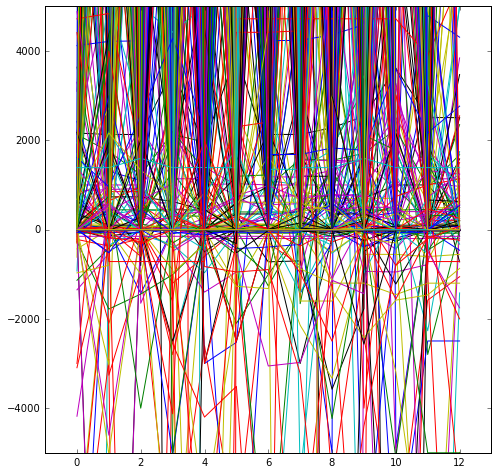

Iteracio: 2
18390.0 [ 1059.]
[ 426.54446797] [ 1691.45553203]
[-180.61284279] [ 2298.61284279]
12033.3766666
Iteracio: 3
26000.0 [ 0.]
[-0.00471406] [ 0.00471406]
[-0.00923956] [ 0.00923956]
1564.0
Iteracio: 5
147.0 [ 0.]
[-0.00572081] [ 0.00572081]
[-0.01121279] [ 0.01121279]
44464.0
Iteracio: 7
85160.0 [ 30403.75]
[ 29771.29446797] [ 31036.20553203]
[ 29164.13715721] [ 31643.36284279]
175474.042228
Iteracio: 11
0.0 [-18687.5]
[-19319.95553203] [-18055.04446797]
[-19927.11284279] [-17447.88715721]
207598.643772
Iteracio: 20
0.0 [-2500.]
[-3132.45553203] [-1867.54446797]
[-3739.61284279] [-1260.38715721]
32722.4418557
Iteracio: 21
0.0 [ 2500.]
[ 1867.54446797] [ 3132.45553203]
[ 1260.38715721] [ 3739.61284279]
50493.7669025
Iteracio: 26
0.0 [ 9750.]
[ 9117.54446797] [ 10382.45553203]
[ 8510.38715721] [ 10989.61284279]
93665.5954767
Iteracio: 45
0.0 [ 1774.5]
[ 1142.04446797] [ 2406.95553203]
[ 534.88715721] [ 3014.11284279]
15386.7033831
Iteracio: 47
0.0 [ 5261.25]
[ 4628.79446797] [ 5

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 1, 'task': 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT', 'grad': array([ -2.65985548e+00,  -0.00000000e+00,  -2.64939647e+00,
        -0.00000000e+00,  -0.00000000e+00,  -2.65985548e+00,
        -0.00000000e+00,  -2.05360742e+05]), 'nit': 834, 'funcalls': 15014}
  " state: %s" % convergence_dict)


Iteracio: 124
10022.0 [ 6267.75]
[ 5635.29446797] [ 6900.20553203]
[ 5028.13715721] [ 7507.36284279]
81669.0116262
Iteracio: 128
0.0 [ 2606.125]
[ 1973.66946797] [ 3238.58053203]
[ 1366.51215721] [ 3845.73784279]
28997.3475511
Iteracio: 136
0.0 [ 3755.625]
[ 3123.16946797] [ 4388.08053203]
[ 2516.01215721] [ 4995.23784279]
57963.6764362
Iteracio: 145
200.0 [-3132.50000265]
[-3764.95553468] [-2500.04447061]
[-4372.11284543] [-1892.88715986]
34662.8811843
Iteracio: 150
54260.0 [ 5234.25]
[ 4601.79446797] [ 5866.70553203]
[ 3994.63715721] [ 6473.86284279]
38437.9007751
Iteracio: 159
0.0 [ 2623.12499305]
[ 1990.66946101] [ 3255.58052508]
[ 1383.51215026] [ 3862.73783583]
20544.9342905
Iteracio: 160
554.0 [ 0.]
[-0.00334664] [ 0.00334664]
[-0.00655941] [ 0.00655941]
1215.0
Iteracio: 168
0.0 [ 3873.125]
[ 3240.66946797] [ 4505.58053203]
[ 2633.51215721] [ 5112.73784279]
142862.590166
Iteracio: 172
0.0 [ 1499.99999073]
[ 867.5444587] [ 2132.45552277]
[ 260.38714795] [ 2739.61283352]
12489.967

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 1, 'task': 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT', 'grad': array([ -1.41596036e-01,  -0.00000000e+00,  -1.41596050e-01,
        -1.87445637e-09,   1.73206418e-10,  -1.41596036e-01,
        -0.00000000e+00,  -1.09326503e+04]), 'nit': 834, 'funcalls': 15014}
  " state: %s" % convergence_dict)


Iteracio: 188
38803.0 [ 755.25000002]
[ 122.79446798] [ 1387.70553205]
[-484.36284277] [ 1994.8628428]
21200.9440828
Iteracio: 199
5006.0 [ 0.]
[-0.00572078] [ 0.00572078]
[-0.01121273] [ 0.01121273]
480.0
Iteracio: 215
0.0 [ 2500.]
[ 1867.54446797] [ 3132.45553203]
[ 1260.38715721] [ 3739.61284279]
22125.3122916
Iteracio: 217
-2495.0 [-1162.75000981]
[-1795.20554184] [-530.29447778]
[-2402.3628526] [ 76.86283297]
16919.4244878
Iteracio: 221
999.0 [ 4029.5]
[ 3397.04446797] [ 4661.95553203]
[ 2789.88715721] [ 5269.11284279]
45222.5133534


/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 1, 'task': 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT', 'grad': array([ -5.09310205e-02,  -0.00000000e+00,  -5.09310174e-02,
        -6.74666455e-10,   6.23415735e-11,  -5.09310205e-02,
        -0.00000000e+00,  -3.93319425e+03]), 'nit': 834, 'funcalls': 15014}
  " state: %s" % convergence_dict)


Iteracio: 229
700.0 [ 2787.25]
[ 2154.79446797] [ 3419.70553203]
[ 1547.63715721] [ 4026.86284279]
20287.6587856
Iteracio: 236
0.0 [ 1875.]
[ 1242.54446797] [ 2507.45553203]
[ 635.38715721] [ 3114.61284279]
31402.0244093
Iteracio: 245
0.0 [ 1562500.18359375]
[ 1561867.72806172] [ 1563132.63912578]
[ 1561260.57075096] [ 1563739.79643654]
31285098.7447
Iteracio: 247
57259.0 [ 0.]
[-0.00334665] [ 0.00334665]
[-0.00655944] [ 0.00655944]
536.0
Iteracio: 250
30000.0 [ 0.]
[-0.00471405] [ 0.00471405]
[-0.00923954] [ 0.00923954]
18452.0
Iteracio: 258
31202.0 [ 2345.625]
[ 1713.16946797] [ 2978.08053203]
[ 1106.01215721] [ 3585.23784279]
13154.718127
Iteracio: 259
0.0 [ 6875.]
[ 6242.54446797] [ 7507.45553203]
[ 5635.38715721] [ 8114.61284279]
70725.1532059
Iteracio: 285
0.0 [ 3294.125]
[ 2661.66946797] [ 3926.58053203]
[ 2054.51215721] [ 4533.73784279]
33135.6028767
Iteracio: 294
0.0 [ 3762.375]
[ 3129.91946797] [ 4394.83053203]
[ 2522.76215721] [ 5001.98784279]
498375.793109
Iteracio: 300
-72

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 1, 'task': 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT', 'grad': array([ -1.44372408e-02,  -0.00000000e+00,  -1.44372269e-02,
        -1.95433084e-10,   1.80208252e-11,  -1.44372408e-02,
        -0.00000000e+00,  -1.11591322e+03]), 'nit': 834, 'funcalls': 15014}
  " state: %s" % convergence_dict)


Iteracio: 393
0.0 [ 1589.375]
[ 956.91946797] [ 2221.83053203]
[ 349.76215721] [ 2828.98784279]
16923.5961013
Iteracio: 395
1748.0 [ 268.125]
[ 102.73720826] [ 433.51279173]
[-56.03507181] [ 592.2850718]
8297.37801959
Iteracio: 405
0.0 [ 23677.125]
[ 23044.66946797] [ 24309.58053203]
[ 22437.51215721] [ 24916.73784279]
244477.408431
Iteracio: 412
0.0 [ 1249.99999473]
[ 617.5444627] [ 1882.45552677]
[ 10.38715195] [ 2489.61283752]
12227.2358283
Iteracio: 414
0.0 [ 6256.]
[ 5623.54446797] [ 6888.45553203]
[ 5016.38715721] [ 7495.61284279]
93436.2237465
Iteracio: 431
60000.0 [ 0.]
[-0.00334664] [ 0.00334664]
[-0.00655941] [ 0.00655941]
19464.0
Iteracio: 438
0.0 [ 2249.99999358]
[ 1617.54446155] [ 2882.45552561]
[ 1010.38715079] [ 3489.61283637]
39770.5330113
Iteracio: 439
10000.0 [-209.25]
[-624.41615821] [ 205.91615821]
[-1022.97567008] [ 604.47567008]
1423.33868071
Iteracio: 444
0.0 [ 5625.]
[ 4992.54446797] [ 6257.45553203]
[ 4385.38715721] [ 6864.61284279]
56681.278179
Iteracio: 449
5

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 1, 'task': 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT', 'grad': array([ -5.66591960e-01,  -0.00000000e+00,  -5.66591959e-01,
        -7.49851826e-09,   6.92889685e-10,  -5.66591960e-01,
        -0.00000000e+00,  -4.37426002e+04]), 'nit': 834, 'funcalls': 15014}
  " state: %s" % convergence_dict)


Iteracio: 634
0.0 [ 9375.]
[ 8742.54446797] [ 10007.45553203]
[ 8135.38715721] [ 10614.61284279]
187720.567493
Iteracio: 637
0.0 [ 8748.875]
[ 8116.41946797] [ 9381.33053203]
[ 7509.26215721] [ 9988.48784279]
315506.836397
Iteracio: 643
0.0 [-1812.5]
[-2444.95553203] [-1180.04446797]
[-3052.11284279] [-572.88715721]
87929.8352381
Iteracio: 646
0.0 [ 2250.]
[ 1617.54446797] [ 2882.45553203]
[ 1010.38715721] [ 3489.61284279]
18177.7692801
Iteracio: 650
631.0 [ 6891.]
[ 6258.54446797] [ 7523.45553203]
[ 5651.38715721] [ 8130.61284279]
24779.7422101
Iteracio: 654
0.0 [ 1507.34049298]
[ 965.66500417] [ 2049.0159818]
[ 445.6565349] [ 2569.02445107]
27369.0279879
Iteracio: 666
34409.0 [ 544.125]
[-88.33053203] [ 1176.58053203]
[-695.48784279] [ 1783.73784279]
29963.3597248
Iteracio: 670
-1200.0 [ 1111.125]
[ 478.66946797] [ 1743.58053203]
[-128.48784279] [ 2350.73784279]
24674.0542271
Iteracio: 679
0.0 [ 2250.125]
[ 1617.66946797] [ 2882.58053203]
[ 1010.51215721] [ 3489.73784279]
67893.82370

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 1, 'task': 'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT', 'grad': array([ -2.99787141e-01,  -0.00000000e+00,  -2.99786805e-01,
        -1.77110917e-09,   1.55979290e-10,  -2.99787141e-01,
        -0.00000000e+00,  -2.31453428e+04]), 'nit': 834, 'funcalls': 15014}
  " state: %s" % convergence_dict)


Iteracio: 705
91167.0 [ 0.]
[-0.00334664] [ 0.00334664]
[-0.00655941] [ 0.00655941]
52208.0
Iteracio: 706
3473.0 [ 0.]
[-0.00334664] [ 0.00334664]
[-0.00655941] [ 0.00655941]
3953.0
Iteracio: 707
0.0 [ 6285.375]
[ 5652.91946797] [ 6917.83053203]
[ 5045.76215721] [ 7524.98784279]
98434.913613
Iteracio: 708
0.0 [ 2376.75]
[ 1744.29446797] [ 3009.20553203]
[ 1137.13715721] [ 3616.36284279]
15537.0361395
Iteracio: 709
5544.0 [ 52071.75]
[ 51439.29446797] [ 52704.20553203]
[ 50832.13715721] [ 53311.36284279]
556597.626032
Iteracio: 710
1.0 [ 0.]
[-0.00334664] [ 0.00334664]
[-0.00655941] [ 0.00655941]
69464.0
Iteracio: 716
617.0 [ 9414.875]
[ 8782.41946797] [ 10047.33053203]
[ 8175.26215721] [ 10654.48784279]
72482.5678698
Iteracio: 717
5000.0 [ 786.25]
[ 153.79446797] [ 1418.70553203]
[-453.36284279] [ 2025.86284279]
7764.08816282
Iteracio: 719
0.0 [ 13750.]
[ 13117.54446797] [ 14382.45553203]
[ 12510.38715721] [ 14989.61284279]
448477.886402
Iteracio: 723
-716.0 [ 1855.25]
[ 1222.79446797]

array([ 0.20827522])

In [67]:
#Llegim les comptes del 37è cluster
accountcluster37=np.zeros((len(assignmentsclus[36]),13))
for i in np.arange(len(assignmentsclus[36])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster37[i]=accountclean[assignmentsclus[36][i].astype(int)]

print accountcluster37.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster37.shape[0]):
        plt.plot(accountcluster37[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 3165.0**2 * RBF(length_scale=630.0)  # long term smooth rising trend
#k2 = 3.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k3 = 24.5**2* RationalQuadratic(length_scale=87.0, alpha=0.9)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=14.2**2)  # noise terms
kernel_gpmlini = k1+k3+k4


gp37 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster37,accountcluster37.shape[0],gp37,36)

(2083, 13)


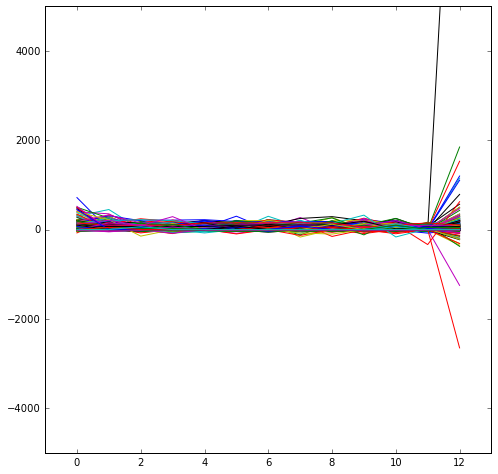

Iteracio: 17
300.0 [ 12.5]
[-20.57189225] [ 45.57189225]
[-52.3209088] [ 77.3209088]
104.694794522
Iteracio: 18
-87.0 [-7.375]
[-26.88741962] [ 12.13741962]
[-45.61934246] [ 30.86934246]
65.099923195
Iteracio: 26
106.0 [ 0.]
[-0.00471405] [ 0.00471405]
[-0.00923953] [ 0.00923953]
34.205262753
Iteracio: 43
150.0 [ 0.]
[-0.00471405] [ 0.00471405]
[-0.00923953] [ 0.00923953]
11.0
Iteracio: 65
105.0 [ 0.]
[-0.00334665] [ 0.00334665]
[-0.00655943] [ 0.00655943]
31.2569992162
Iteracio: 69
788.0 [ 14.4999925]
[-23.86304025] [ 52.86302525]
[-60.69155169] [ 89.69153669]
245.825141106
Iteracio: 76
-75.0 [ 18.99999991]
[-14.09454462] [ 52.09454444]
[-45.86530736] [ 83.86530719]
107.939798036
Iteracio: 112
-150.0 [ 0.]
[-0.00471405] [ 0.00471405]
[-0.00923953] [ 0.00923953]
44.0
Iteracio: 130
150.0 [ 0.]
[-0.00471405] [ 0.00471405]
[-0.00923953] [ 0.00923953]
31.9530906173
Iteracio: 149
100.0 [ 0.]
[-0.00334664] [ 0.00334664]
[-0.00655941] [ 0.00655941]
41.0
Iteracio: 150
1152.0 [ 0.]
[-0.00471405

Iteracio: 1239
240.0 [ 8.625]
[-4.72544698] [ 21.97544698]
[-17.54187608] [ 34.79187608]
74.0135122799
Iteracio: 1292
57.0 [ 6.51256833]
[-11.14779796] [ 24.17293461]
[-28.10174959] [ 41.12688625]
82.3528991597
Iteracio: 1298
140.0 [ 0.]
[-0.00334665] [ 0.00334665]
[-0.00655943] [ 0.00655943]
31.0161248385
Iteracio: 1303
115.0 [ 0.]
[-0.00471405] [ 0.00471405]
[-0.00923954] [ 0.00923954]
18.0
Iteracio: 1310
310.0 [ 0.]
[-0.00471405] [ 0.00471405]
[-0.00923954] [ 0.00923954]
19.0
Iteracio: 1339
80.0 [ 6.25]
[-10.28597414] [ 22.78597414]
[-26.16050931] [ 38.66050931]
107.335921294
Iteracio: 1347
271.0 [ 105.00000004]
[ 93.33219538] [ 116.66780471]
[ 82.1311029] [ 127.86889719]
292.723418947
Iteracio: 1357
500.0 [ 12.5]
[-20.57193394] [ 45.57193394]
[-52.32099053] [ 77.32099053]
90.3493220783
Iteracio: 1368
60.0 [ 0.]
[-0.00334665] [ 0.00334665]
[-0.00655943] [ 0.00655943]
11.0
Iteracio: 1372
120.0 [ 12.50053874]
[-20.57135304] [ 45.57243053]
[-52.32036915] [ 77.32144664]
306.042480711
It

array([ 0.88584276])

In [68]:
#Llegim les comptes del 38è cluster
accountcluster38=np.zeros((len(assignmentsclus[37]),13))
for i in np.arange(len(assignmentsclus[37])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster38[i]=accountclean[assignmentsclus[37][i].astype(int)]

print accountcluster38.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster38.shape[0]):
        plt.plot(accountcluster38[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 76.0**2 * RBF(length_scale=21.0)  # long term smooth rising trend
#k2 = 3.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k3 = 9.5**2* RationalQuadratic(length_scale=10.0, alpha=0.4)
k4 = 0.7**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=5.2**2)  # noise terms
kernel_gpmlini = k1+k3+k4


gp38 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster38,accountcluster38.shape[0],gp38,37)

(2065, 13)


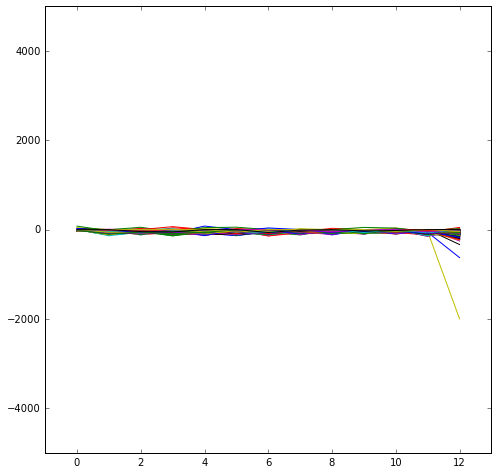

Iteracio: 3
0.0 [-90.01867198]
[-116.72049748] [-63.31684648]
[-142.35424995] [-37.683094]
63.7965516309
Iteracio: 5
-66.0 [-9.74999978]
[-25.20964479] [ 5.70964524]
[-40.05090401] [ 20.55090446]
41.3521462563
Iteracio: 12
-123.0 [-16.74999883]
[-49.05301935] [ 15.5530217]
[-80.06391905] [ 46.5639214]
76.01973428
Iteracio: 28
-100.0 [-5.]
[-32.83883715] [ 22.83883715]
[-59.56412081] [ 49.56412081]
66.0984114786
Iteracio: 42
-135.0 [ 0.]
[-16.60524263] [ 16.60524263]
[-32.54627555] [ 32.54627555]
16.0934769394
Iteracio: 63
-104.0 [-22.125]
[-61.15046676] [ 16.90046676]
[-98.61491485] [ 54.36491485]
87.5785361832
Iteracio: 103
-115.0 [-2.25]
[-22.54431897] [ 18.04431897]
[-42.02686517] [ 37.52686517]
23.2594066992
Iteracio: 114
-109.0 [-5.75]
[-38.05107716] [ 26.55107716]
[-69.06011124] [ 57.56011124]
51.6623654124
Iteracio: 145
-228.0 [ 2.75000172]
[-28.67149412] [ 34.17149756]
[-58.83613013] [ 64.33613357]
63.0238050264
Iteracio: 190
-52.0 [-2.75000001]
[-20.13849858] [ 14.63849857]
[-

Iteracio: 931
-115.0 [-12.25000088]
[-42.05531304] [ 17.55531129]
[-70.66841272] [ 46.16841096]
43.3704968844
Iteracio: 935
-113.0 [-17.27828349]
[-61.12969707] [ 26.57313008]
[-103.2270541] [ 68.67048711]
92.0163029033
Iteracio: 939
-80.0 [-3.75]
[-40.12908373] [ 32.62908373]
[-75.05300411] [ 67.55300411]
97.5141015443
Iteracio: 947
-176.0 [-6.625]
[-30.01305175] [ 16.76305175]
[-52.46558143] [ 39.21558143]
40.0124980475
Iteracio: 951
-90.0 [-9.87499792]
[-32.85286765] [ 13.10287181]
[-54.9116226] [ 35.16162676]
49.193495505
Iteracio: 969
-94.0 [-8.25000303]
[-33.63644495] [ 17.13643889]
[-58.00742919] [ 41.50742313]
33.6154726279
Iteracio: 994
0.0 [-62.58849711]
[-85.52829771] [-39.64869651]
[-107.55050628] [-17.62648793]
32.3573793747
Iteracio: 996
-153.0 [-18.24992363]
[-50.93184672] [ 14.43199946]
[-82.30649288] [ 45.80664562]
68.6367248636
Iteracio: 1022
-50.0 [-2.49999993]
[-22.50000295] [ 17.50000309]
[-41.70000584] [ 36.70000598]
26.7207784318
Iteracio: 1036
-98.0 [-11.]
[-39.

Iteracio: 1793
-118.0 [-8.75]
[-29.36552886] [ 11.86552886]
[-49.15643656] [ 31.65643656]
57.8273291792
Iteracio: 1803
-101.0 [-12.5000002]
[-47.65634669] [ 22.65634629]
[-81.40643933] [ 56.40643892]
78.0704809771
Iteracio: 1840
-40.0 [-4.]
[-19.71639791] [ 11.71639791]
[-34.80413989] [ 26.80413989]
32.0156211872
Iteracio: 1849
-3.0 [-65.6800106]
[-90.79877268] [-40.56124852]
[-114.91278428] [-16.44723692]
65.2916533716
Iteracio: 1889
-40.0 [-12.49999787]
[-25.72880033] [ 0.72880459]
[-38.42845069] [ 13.42845495]
38.9743505398
Iteracio: 1900
-76.0 [-3.25]
[-23.62617289] [ 17.12617289]
[-43.18729887] [ 36.68729887]
29.6141857899
Iteracio: 1901
-88.0 [-3.25]
[-23.42980169] [ 16.92980169]
[-42.80241132] [ 36.30241132]
27.7668867538
Iteracio: 1910
-161.0 [-16.125]
[-56.93534644] [ 24.68534644]
[-96.11327902] [ 63.86327902]
101.405128075
Iteracio: 1926
-90.0 [-2.5]
[-24.82567451] [ 19.82567451]
[-46.25832203] [ 41.25832203]
44.598206242
Iteracio: 1927
-59.0 [-2.5]
[-20.4230163] [ 15.4230163

array([ 0.6866136])

In [70]:
#Llegim les comptes del 39è cluster
accountcluster39=np.zeros((len(assignmentsclus[38]),13))
for i in np.arange(len(assignmentsclus[38])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster39[i]=accountclean[assignmentsclus[38][i].astype(int)]

print accountcluster39.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster39.shape[0]):
        plt.plot(accountcluster39[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 23.0**2 * RBF(length_scale=10.0)  # long term smooth rising trend
k2 = 3.0**2 * RBF(length_scale=0.3) 
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k3 = 4.5**2* RationalQuadratic(length_scale=1.0, alpha=0.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=0.2**2)  # noise terms
kernel_gpmlini = k1+k2+k3+k4


gp39 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster39,accountcluster39.shape[0],gp39,38)

(111, 13)


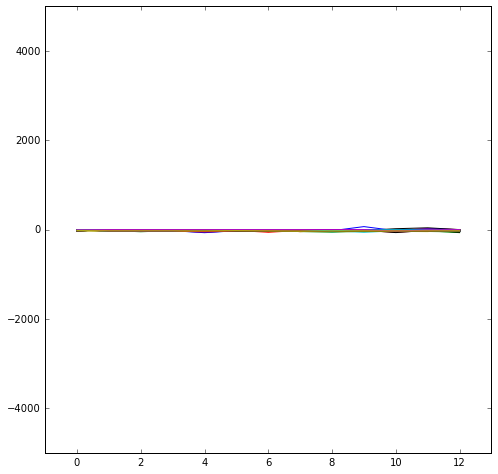

Iteracio: 8
-35.0 [-0.12499996]
[-6.89782329] [ 6.64782337]
[-13.39973369] [ 13.14973377]
4.69041575982
Iteracio: 12
0.0 [-35.625]
[-52.58082369] [-18.66917631]
[-68.85841442] [-2.39158558]
68.7386354243
Iteracio: 44
-32.0 [ 0.]
[-12.3555481] [ 12.3555481]
[-24.21687427] [ 24.21687427]
22.825424421
Iteracio: 57
-68.0 [-33.75]
[-48.08706934] [-19.41293065]
[-61.8506559] [-5.64934409]
71.3302180005
Iteracio: 90
-60.0 [-13.75]
[-28.42087867] [ 0.92087867]
[-42.50492219] [ 15.00492219]
37.7491721764
Iteracio: 91
-39.0 [-2.5000001]
[-11.08890746] [ 6.08890726]
[-19.33425853] [ 14.33425832]
19.2093727123
La predicció de compte en negatiu en predicció i real correctes és de: 0.855855855856
La predicció de compte en negatiu en predicció i real o 0 correctes és de: 0.981981981982
La predicció de compte esta compresa en la zona determinada: 0.864864864865
La predicció de compte ens permet assegurar el signe final: 0.945945945946
Comptes signe 0.981981981982
The Mean Absolute Scaled error is [ 0.

array([ 0.28866675])

In [26]:
#Llegim les comptes del 40è cluster
accountcluster40=np.zeros((len(assignmentsclus[39]),13))
for i in np.arange(len(assignmentsclus[39])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster40[i]=accountclean[assignmentsclus[39][i].astype(int)]

print accountcluster40.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster40.shape[0]):
        plt.plot(accountcluster40[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 40.0**2 * RBF(length_scale=20.0)  # long term smooth rising trend
#k2 = 3.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k3 = 1.5**2* RationalQuadratic(length_scale=2.0, alpha=0.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=0.2**2)  # noise terms
kernel_gpmlini = k1+k3+k4


gp40 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster40,accountcluster40.shape[0],gp40,39)

In [38]:

def regression1(accountclean,quant,gp,clusternum):
    #np.arange(accountclean.shape[0])
    a=np.arange(12)+1 #vector del 1 al 12
    a=a.reshape(-1,1)
    xs=np.arange(13,14,1).reshape(-1,1) #vector que conte el 13
    compt=0
    compt1=0
    compt2=0
    compt3=0
    errort=0
    errorrmse=0
    denom=0
    errormae=0
    lambd=10
    mase=0
    for i in np.arange(quant):
        error=0
        gp.fit(a, accountclean[i][0:12])
        print i
        #print("GPML kernel: %s" % gp.kernel_)
        #print("Log-marginal-likelihood: %.3f"
        #   %gp.log_marginal_likelihood(gp.kernel_.theta))
        y_pred, sigmapred = gp.predict(xs, return_std=True)
        print accountclean[i][12], y_pred
        if (accountclean[i][12]<0 and y_pred<0) or (accountclean[i][12]>0 and y_pred>0) or (accountclean[i][12]==0 and y_pred==0):
            compt+=1
        if (accountclean[i][12]<=0 and y_pred<0) or (accountclean[i][12]>0 and y_pred>0) or (accountclean[i][12]==0 and y_pred==0):
            compt1+=1
        if (accountclean[i][12]<=(y_pred+sigmapred)) and ((accountclean[i][12]>=(y_pred-sigmapred))) or (np.abs((accountclean[i][12]-y_pred))<=1e-2):
            compt2+=1 
        if (accountclean[i][12]<=(y_pred+1.9600*sigmapred)) and ((accountclean[i][12]>=(y_pred-1.9600*sigmapred))) or (np.abs((accountclean[i][12]-y_pred))<=1e-1):
            compt3+=1
        #print compt1
        error=np.abs(y_pred-accountclean[i][12])
        denom=np.sum(np.abs(np.asarray([t - s for s, t in zip(accountclean[i], accountclean[i][1:12])][:]))) #naive
        errort+=error/float((denom/float(11))+lambd)
        errorrmse+=error**2
        errormae+=error
    
    mae=errormae/float(quant)    
    mase=errort/float(quant)
    rmse=np.sqrt(errorrmse/float(quant)) 
    print 'La predicció de compte en negatiu en predicció i real correctes és de:',compt/float(quant)
    print 'La predicció de compte en negatiu en predicció i real o 0 correctes és de:',compt1/float(quant)
    print 'La predicció de compte esta compresa en la zona indeterminada:',compt2/float(quant)  
    print 'La predicció de compte ens permet assegurar el signe final:',compt3/float(quant)
    print 'The Mean Absolute Scaled error is',mase 
    print 'The MAE error is',mae
    print 'The RMSE is',rmse